# `preprocess_eval_data.py`

## Summary

This script provides a comprehensive pipeline for evaluating DeepDISC models in the context of Roman/LSST data. It processes, predicts, and compares detections against ground truth and the test set catalog.

---

### **Key Components Table**

| Component              | Purpose                                                                                   |
|------------------------|-------------------------------------------------------------------------------------------|
| Helper Functions       | Coordinate scaling, annotation extraction, catalog matching                               |
| `ModelEvaluator` Class | Model loading, prediction, evaluation, sky coordinate extraction, region filtering        |
| Main Script            | Argument parsing, data loading, catalog matching, prediction, output saving, logging      |

---

### **Key Functions**

- **Helper Functions**:  
  - **Coordinate Scaling**: Functions to convert between upsampled image coordinates and original World Coordinate System (WCS) coordinates.
  - **Annotation Extraction**: Extracts Right Ascension (RA) and Declination (Dec) of ground truth objects from test data, applying coordinate scaling as needed.
  - **Catalog Matching**: Matches detected objects to ground truth or external catalogs using sky coordinate matching, ensuring only unique, one-to-one matches are retained.

- **ModelEvaluator Class**:  
  Encapsulates the evaluation workflow:
  - Loads model configuration and checkpoints.
  - Registers and loads test datasets.
  - Sets detection thresholds (score, NMS, top-k).
  - Runs predictions and evaluates model performance.
  - Extracts predictions in sky coordinates.
  - Filters external catalogs to match the test set's sky coverage.

- **Main Script Workflow**:
  1. **Parse Arguments**: Handles command-line options for data folder, scaling, model checkpoint, config file, and thresholds.
  2. **Load Test Data**: Reads test image/annotation data and saves ground truth sky coordinates.
  3. **Catalog Matching**:  
     - Matches test set ground truth to LSST truth catalog.
     - Matches LSST detection catalog to the matched truth subset.
  4. **Model Prediction**:  
     - Loads model and test data.
     - Runs predictions, saves outputs (full instance data and sky coordinates).
     - Matches model predictions to LSST truth catalog.
  5. **Sky Region Filtering**:  
     - Filters LSST detection catalog to only those detections within the test set's sky coverage.
  6. **Timing and Logging**:  
     - Reports file creation, matching results, and total runtime.

### **How to Use**

1. **Configure**: Set paths and thresholds via command-line args in job script.
2. **Run**: Submit the script on HAL to process data, run model predictions, match catalogs, and save results.
3. **Analyze**: Use saved outputs (JSON files) for further analysis in this notebook.

# After `preprocess_eval_data.py`

## Detection Completeness

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# same for all SNR levels
def truth_catalog_cut(baseline_mag_5sigma_10yr, years, flag='default'):
    """
    Calculate truth catalog magnitude cut at Rubin's nominal 5sigma depth adjusted 
    for the specified number of observation years.
    
    This cut is intended to be used consistently for defining the faint 
    limit of the truth sample for analysis (e.g., completeness), 
    including FOF matching.
    
    Parameters:
    baseline_mag_5sigma_10yr (float): 10-year 5σ depth (e.g., 26.8 for i-band)
    years (float): Analysis time baseline in years
    
    Returns:
    float: Magnitude cut for truth catalog
    """
    time_factor = np.sqrt(10 / years) # represents (sqrt(N_obs_10yr) / sqrt(N_obs_years))
    # delta_mag = 2.5 * log10(SNR_ratio)
    # SNR_ratio corresponds to 1 / time_factor for reaching the *same* SNR
    m_cut = baseline_mag_5sigma_10yr - 2.5 * np.log10(time_factor)
    return m_cut

In [3]:
# for all SNR levels
baseline_mag_5sigma_10yr_i = 26.8  # From Rubin key numbers
years = 5
truth_mag_limit = truth_catalog_cut(baseline_mag_5sigma_10yr_i, years)
print(f"Truth catalog cut: mag_i ≤ {truth_mag_limit}")  # 26.42

Truth catalog cut: mag_i ≤ 26.423712505420024


### Completeness and Plotting Functions

In [5]:
def calculate_completeness(matched_truth_df, full_truth_df, mag_col='mag_i', bins=None, n_bootstrap=1000):
    """
    Calculates both overall and binned completeness with bootstrap errors
    
    Parameters:
    -----------
    matched_truth_df : pandas DataFrame
        DataFrame with matched objects of test set
    full_truth_df : pandas DataFrame 
        DataFrame with all truth objects
    mag_col : str, optional 
        Column name for mag vals. Default is mag_i
    bins : array-like, optional
        Mag bins for calculating binned completeness
    n_bootstrap : int, optional
        Number of bootstrap iterations for error estimation
        
    Returns:
    --------
    dict:
        - 'overall': (float) Overall completeness
        - 'overall_error': (float) Bootstrap error on overall completeness
        - 'binned': dict:
            - 'bin_centers': (array) Centers of magnitude bins
            - 'completeness': (array) Completeness values per bin
            - 'errors': (array) Bootstrap errors per bin
            - 'total_counts': (array) Total number of objects per bin
    """
    if len(full_truth_df) == 0:
        print("Warning: Empty full truth cat")
        return None
        
    # overall DC
    total_objects = len(full_truth_df)
    matched_objects = len(matched_truth_df)
    overall_completeness = matched_objects / total_objects if total_objects > 0 else 0
    
    if bins is None:
        min_mag = full_truth_df[mag_col].min()
        max_mag = full_truth_df[mag_col].max()
        bins = np.arange(np.floor(min_mag), np.ceil(max_mag), 0.5)
    
    # binned completeness
    total_counts, _ = np.histogram(full_truth_df[mag_col], bins=bins)
    matched_counts, _ = np.histogram(matched_truth_df[mag_col], bins=bins)
    completeness = np.divide(matched_counts, total_counts, 
                           out=np.zeros_like(matched_counts, dtype=float), 
                           where=total_counts != 0)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Bootstrap resampling for both overall and binned
    bootstrap_overall = []
    bootstrap_binned = []
    
    for _ in range(n_bootstrap):
        boot_full = full_truth_df.sample(frac=1, replace=True)
        boot_matched = matched_truth_df.sample(frac=1, replace=True)
        
        bootstrap_overall.append(len(boot_matched) / len(boot_full))
        
        boot_total, _ = np.histogram(boot_full[mag_col], bins=bins)
        boot_matched, _ = np.histogram(boot_matched[mag_col], bins=bins)
        boot_completeness = np.divide(boot_matched, boot_total,
                                    out=np.zeros_like(boot_matched, dtype=float),
                                    where=boot_total != 0)
        bootstrap_binned.append(boot_completeness)
    
    # errors
    overall_error = np.std(bootstrap_overall)
    binned_errors = np.std(bootstrap_binned, axis=0)
    
    return {
        'overall': overall_completeness,
        'overall_err': overall_error,
        'binned': {
            'bin_centers': bin_centers,
            'completeness': completeness,
            'errors': binned_errors,
            'total_counts': total_counts
        }
    }

def plot_completeness(completeness_data, label=None, title=None, 
                     mag_col=r'$i$-mag', show_errors=True, output_path=None, color=None, show_truth_dist=False):
    """
    Plots a single completeness curve with optional error bands.
    
    Parameters:
    -----------
    completeness_data : dict
        Output from calculate_completeness function
    label : str, optional
        Label for completeness curve
    title : str, optional
        Plot title
    mag_col : str, optional
        Mag column name for x-axis label
    show_errors : bool, optional
        Whether to show error bands
    output_path : str, optional
        Path to save the plot
    color : str, optional
        Color for the plot. Overridden if label is 'LSST' or 'Roman + LSST'.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bin_centers = completeness_data['binned']['bin_centers']
    completeness = completeness_data['binned']['completeness']
    total_counts = completeness_data['binned']['total_counts']

    plot_color = color
    if label == "LSST":
        plot_color = "red"
    elif label == "Roman + LSST":
        plot_color = "green"
    elif plot_color is None:
        plot_color = "blue"

    ax.plot(bin_centers, completeness, 'o-', markersize=7, label=label, color=plot_color)
    
    if show_errors:
        errors = completeness_data['binned']['errors']
        ax.fill_between(bin_centers,
                       completeness - errors,
                       completeness + errors,
                       alpha=0.3, color=plot_color)
    
    # vertical line at the 5 sigma mag limit which should be truth catalog limit
    if len(bin_centers) > 0:
        ax.axvline(max(bin_centers), linestyle='dotted', alpha=0.7, color='black', label=r'5$\sigma$ Magnitude Limit')

    # overall completeness info
    if 'overall' in completeness_data:
        overall_text = f"Overall: {completeness_data['overall']:.2f}"
        if 'overall_error' in completeness_data:
            overall_text += f" ± {completeness_data['overall_error']:.3f}"
        ax.text(0.05, 0.05, overall_text, transform=ax.transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
    
    ax.set_xlabel(mag_col, fontsize=14)
    ax.set_ylabel('Detection Completeness', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # --- Truth Dist Plotting ---
    ax2 = None
    if show_truth_dist:
        ax2 = ax.twinx()
        color_ax2 = 'tab:grey'
        ax2.set_ylabel('Number of Truth Objects (log)', color=color_ax2, fontsize=14)
        # step plot for hist
        ax2.step(bin_centers, total_counts, where='mid', color=color_ax2, alpha=0.6, label='Truth Count')
        ax2.tick_params(axis='y', labelcolor=color_ax2)
        ax2.set_yscale('log')
        # prevents zero counts from breaking log scale
        min_val = np.min(total_counts[total_counts > 0]) if np.any(total_counts > 0) else 1
        ax2.set_ylim(bottom=max(0.5, min_val / 2))
    
    handles, legend_labels = ax.get_legend_handles_labels()
    if label or (len(bin_centers) > 0): # checks if any label was set or if axvline was plotted
        ax.legend(handles, legend_labels, fontsize=12)

    if title:
        plt.title(title, fontsize=16)
    else:
        plt.title('Detection Completeness', fontsize=16)
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()

def plot_completeness_comparison(completeness_data_list, labels=None, colors=None,
                               title=None, mag_col=r'$i$-mag', show_errors=True,
                               error_style='band', show_truth_dist=False, output_path=None):
    """
    Plots multiple completeness curves for comparison.
    
    Parameters:
    -----------
    completeness_data_list : list
        List of completeness data dictionaries from calculate_completeness
    labels : list of str, optional
        Labels for each completeness curve
    colors : list of str
        Colors for each curve provided by the user.
    title : str, optional
        Plot title
    mag_col : str, optional
        Mag column name for x-axis label
    show_errors : bool, optional
        Whether to show errors
    error_style : {'band', 'bars', None}, optional
        Style of error visualization
    output_path : str, optional
        Path to save the plot
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # must pass in colors
    if colors is None:
        # if user forgets, fallback to default
        # raise an error: raise ValueError("Colors must be provided for comparison plots.")
        print("Warning: Colors for comparison plot not provided. Using default matplotlib cycle.")
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        
    max_mag_val = -np.inf
    ax2 = None

    for i, comp_data in enumerate(completeness_data_list):
        color = colors[i % len(colors)] 
        label = labels[i] if labels is not None and i < len(labels) else f"Dataset {i+1}"
        
        bin_centers = comp_data['binned']['bin_centers']
        if len(bin_centers) > 0:
            max_mag_val = max(max_mag_val, max(bin_centers))
        completeness = comp_data['binned']['completeness']
        total_counts = comp_data['binned']['total_counts']
        
        # main curve
        ax.plot(bin_centers, completeness, 'o-', color=color,
                markersize=7, label=label)
        
        if show_errors and error_style:
            errors = comp_data['binned']['errors']
            if error_style == 'band':
                ax.fill_between(bin_centers,
                              completeness - errors,
                              completeness + errors,
                              color=color, alpha=0.3)
            elif error_style == 'bars':
                ax.errorbar(bin_centers, completeness, yerr=errors,
                          fmt='none', ecolor=color, capsize=4,
                          elinewidth=1.2, alpha=0.7)
        
        # DOESN'T FULLY WORK
#         if show_truth_dist:
#             if ax2 is None:
#                 ax2 = ax.twinx()
#                 color_ax2_label = 'tab:grey'
#                 ax2.set_ylabel('Number of Truth Objects (log)', color=color_ax2_label, fontsize=14)
#                 ax2.set_yscale('log')
#                 ax2.tick_params(axis='y', labelcolor=color_ax2_label)
#                 # Set bottom limit once based on typical counts or a default
#                 # This is tricky with multiple datasets; maybe set later based on all counts?
#                 # Let's calculate overall min > 0 count across all datasets first
#                 all_min_counts = []
#                 for cd in completeness_data_list:
#                     tc = cd['binned']['total_counts']
#                     if np.any(tc > 0):
#                          all_min_counts.append(np.min(tc[tc > 0]))
#                 min_val_overall = min(all_min_counts) if all_min_counts else 1
#                 ax2.set_ylim(bottom=max(0.5, min_val_overall / 2))
#             # Plot truth count for this dataset using same color but different style/alpha
#             ax2.step(bin_centers, total_counts, where='mid', color=color,
#                      alpha=0.4, linestyle='--', label=f'{label} Truth Count') # Dashed line

    # vertical line at the 5 sigma mag limit which should be truth catalog limit
    if max_mag_val > -np.inf:
        ax.axvline(max_mag_val, linestyle='dotted', alpha=0.7, color='black', label=r'5$\sigma$ Magnitude Limit')

    overall_text_lines = []
    for i, comp_data in enumerate(completeness_data_list):
        if 'overall' in comp_data:
            current_label = labels[i] if labels is not None and i < len(labels) else f"Dataset {i+1}"
            text = f"{current_label} Overall: {comp_data['overall']:.2f}"
            if 'overall_error' in comp_data:
                text += f" ± {comp_data['overall_error']:.3f}"
            overall_text_lines.append(text)
    
    if overall_text_lines:
        text_x_pos = 0.05
        text_ha = 'left'
        if len(completeness_data_list) >= 3:
            text_x_pos = 0.95
            text_ha = 'right'
        ax.text(text_x_pos, 0.05, '\n'.join(overall_text_lines), transform=ax.transAxes,
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.7,
                                        boxstyle='round,pad=0.5'),
                 va='bottom', ha=text_ha) # text box starts at bottom
    
    ax.set_xlabel(mag_col, fontsize=14)
    ax.set_ylabel('Detection Completeness', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    handles, legend_labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, legend_labels, fontsize=12)

    if title:
        plt.title(title, fontsize=16)
    else:
        plt.title('Detection Completeness Comparison', fontsize=16) # Default title
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()

### When `lvl=2` in newest annotation code

In [4]:
run_dir_lsst = 'run6_sm_dlvl2'
run_dir_both = 'run6_ups_roman_dlvl2'

In [5]:
matched_lsst_det_truth_fi = f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/test_lsst_det_truth11_info.json' 
matched_lsst_det_truth = pd.read_json(matched_lsst_det_truth_fi, orient='records')
matched_lsst_det_truth = matched_lsst_det_truth[matched_lsst_det_truth['mag_i'] < truth_mag_limit]

In [6]:
# lsst_runs/run5_sm_dlvl5/lsst_dlvl5.pth
matched_dd_truth_filename = f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/dd_truth11_info_s0.3_n0.5.json'
matched_dd_truth = pd.read_json(matched_dd_truth_filename, orient='records')
matched_truth = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/test_truth11_cat.json')

In [89]:
# lsst_runs/run5_sm_dlvl5/lsst_dlvl5.pth
matched_dd_truth_filename_ups = f'./lsst_runs/{run_dir_both}/dd_truth11_info_s0.3_n0.5.json'
matched_dd_truth_ups = pd.read_json(matched_dd_truth_filename_ups, orient='records')
matched_truth_ups = pd.read_json(f'./lsst_runs/{run_dir_both}/test_truth11_cat.json')

In [8]:
truth_mask = (matched_truth['mag_i'] < truth_mag_limit) & (matched_truth['mag_i'] > 15.5)
#truth_mask_ups = (matched_truth_ups['mag_i'] < truth_mag_limit) & (matched_truth_ups['mag_i'] > 15.5)

In [11]:
matched_dd_truth

tract patch      mag_u       flux_i       flux_z         ra  redshift  \
0       3075   6,5  25.862589  1554.472534  1791.852051  50.956909  0.192422   
1       3075   6,5  26.357548   746.312073   817.719788  50.950755  0.638968   
2       3075   6,5  27.146908  2669.933105  3620.756836  50.951756  0.373149   
3       3075   6,5  27.840252   764.063538  1166.156372  50.950359  0.779685   
4       3075   6,5  26.486019   623.442261   761.613708  50.952734  0.812006   
...      ...   ...        ...          ...          ...        ...       ...   
12209   3077   5,5  26.603363   114.621918   140.495010  54.975104  1.633876   
12210   3077   5,5  27.035530   150.615509   153.092560  54.972294  2.529842   
12211   3077   5,5  28.677179   118.735054   136.713120  54.976407  0.403801   
12212   3077   5,5  28.934383   333.894745   650.626526  54.978398  0.948270   
12213   3077   5,5  26.013138   151.703552   159.787903  54.977851  1.580162   

         id_string      mag_z      mag_i  ...  size_minor_true  size_true  \
0      10250027433  23.266745  23.421041  ...         0.270302   0.276552   
1      10250767290  24.118488  24.217699  ...         0.178791   0.184518   
2      10250189345  22.503002  22.833750  ...         0.211749   0.262153   
3      10251182647  23.733109  24.192177  ...         0.229041   0.258451   
4      10251360287  24.195663  24.413010  ...         0.178295   0.192688   
...            ...        ...        ...  ...              ...        ...   
12209  10318922015  26.030848  26.251831  ...         0.081897   0.082075   
12210  10329213006  25.937614  25.955326  ...         0.159894   0.160785   
12211  10312752651  26.060474  26.213552  ...         0.053105   0.086291   
12212  10314473924  24.366669  25.090977  ...         0.210228   0.343959   
12213  10318500018  25.891140  25.947512  ...         0.243056   0.390488   

       mag_true_g  mag_true_r   shear_1  position_angle_true_dc2  \
0       24.430471   23.675262  0.001512                44.832934   
1       25.762648   24.797459  0.017868                83.880330   
2       24.950682   23.418930  0.010744                72.079777   
3       26.594124   25.258526  0.026424               135.740522   
4       26.080015   25.413431  0.028498               128.053563   
...           ...         ...       ...                      ...   
12209   26.448717   26.486887  0.030085               145.919449   
12210   26.136808   25.878744  0.031305               160.129111   
12211   27.595394   26.472473  0.002918               119.099060   
12212   27.610489   26.078566  0.022946                37.526091   
12213   25.977961   26.141865  0.031549                80.237197   

       ellipticity_1_true  position_angle_true  size_bulge_true  mag_true_i  
0               -0.000306          -134.233078         0.206049   23.393114  
1               -0.002002          -131.351135         0.114078   24.202076  
2               -0.045510           -57.666943         0.186524   22.808346  
3                0.046115           -20.073532         0.135969   24.176128  
4                0.029251           -20.532150         0.116652   24.400372  
...                   ...                  ...              ...         ...  
12209            0.000412           -33.878067         0.055488   26.235760  
12210           -0.000500          -129.814255         0.152108   25.941633  
12211           -0.233730           -95.480255         0.045515   26.192705  
12212           -0.220038          -102.119171         0.201708   25.075895  
12213            0.192186          -162.837891         0.155849   25.931126  

[12214 rows x 52 columns]


Overall Completeness Statistics:
LSST Pipeline: 0.8725 ± 0.0000
LSST: 0.7850 ± 0.0000
Roman + LSST: 0.9172 ± 0.0000


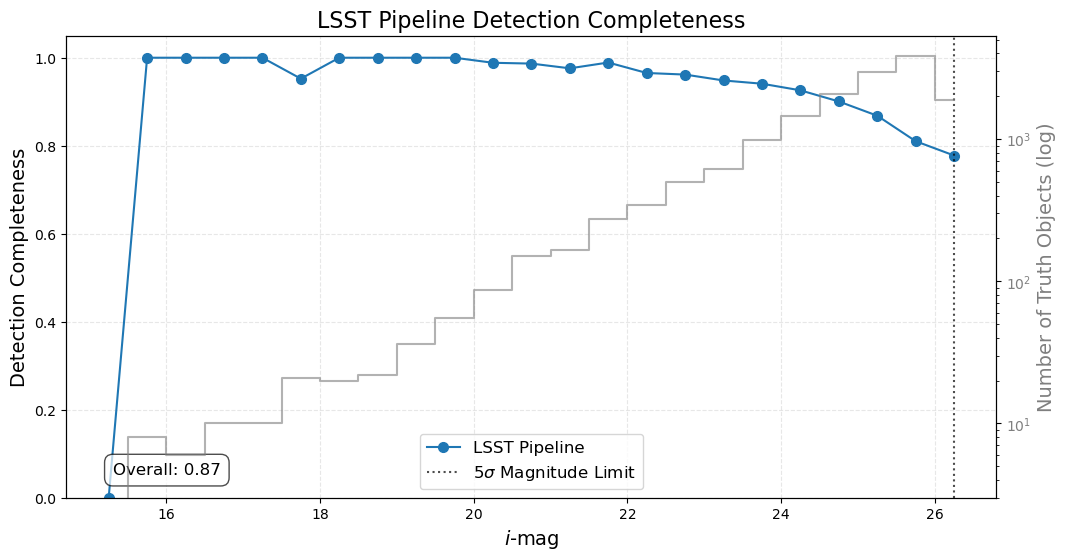

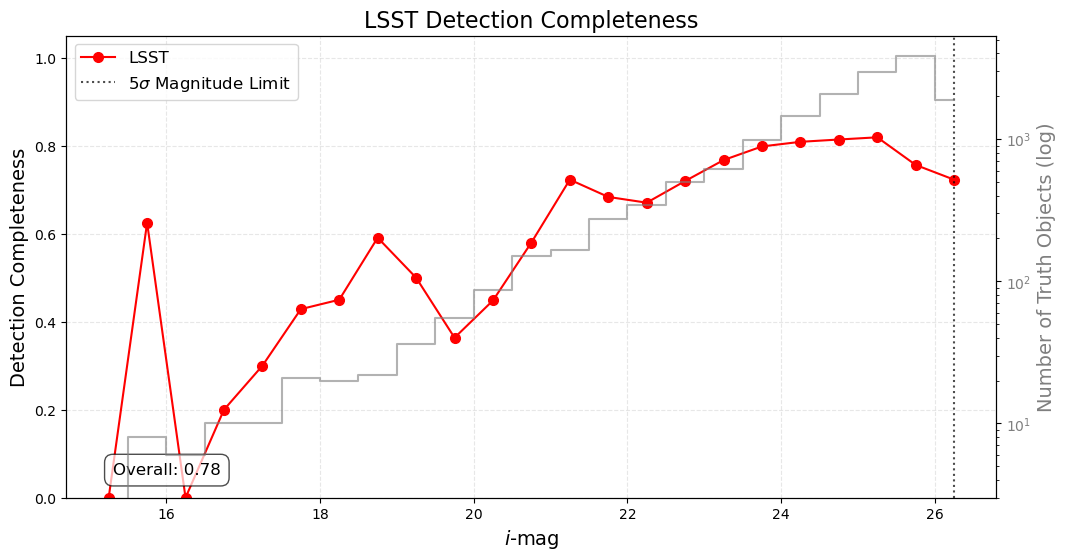

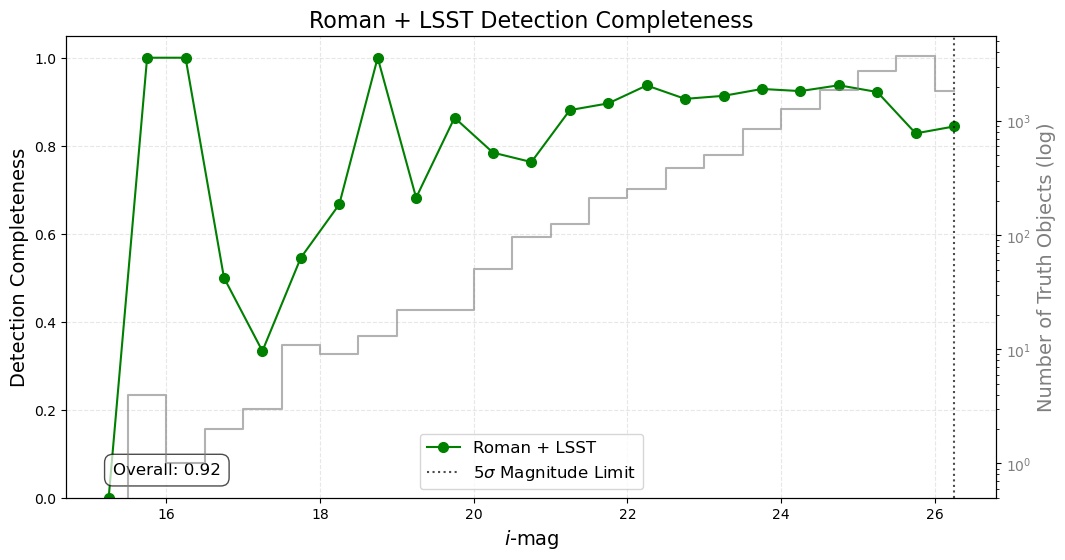

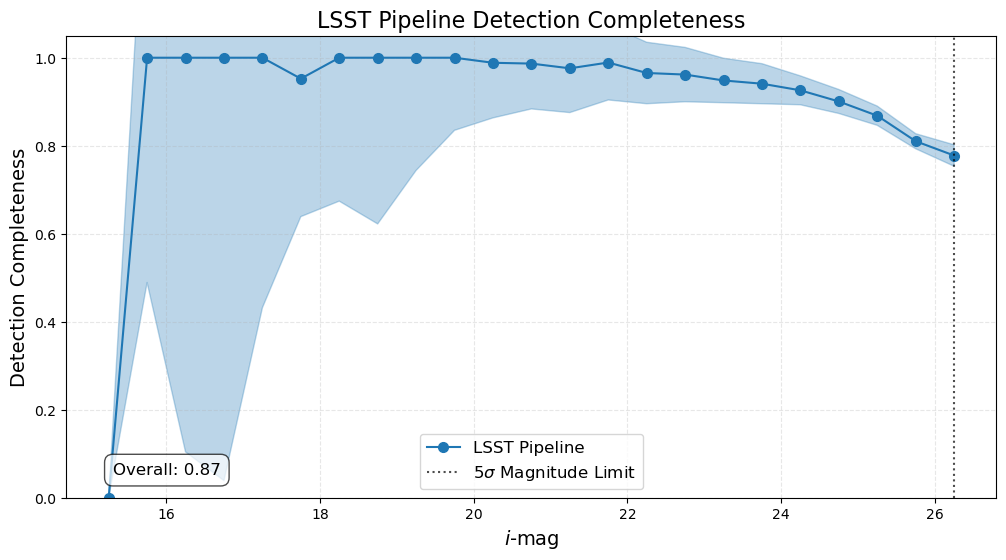

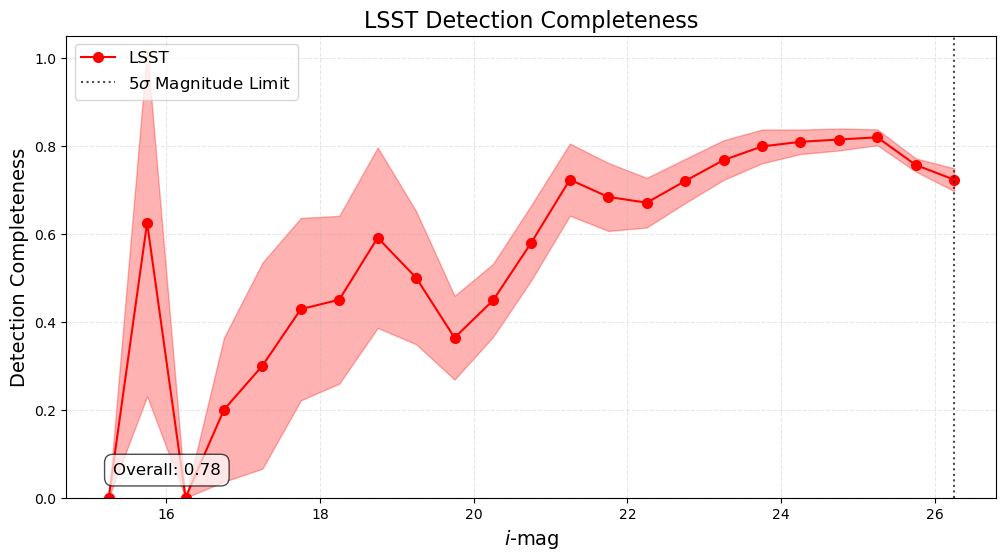

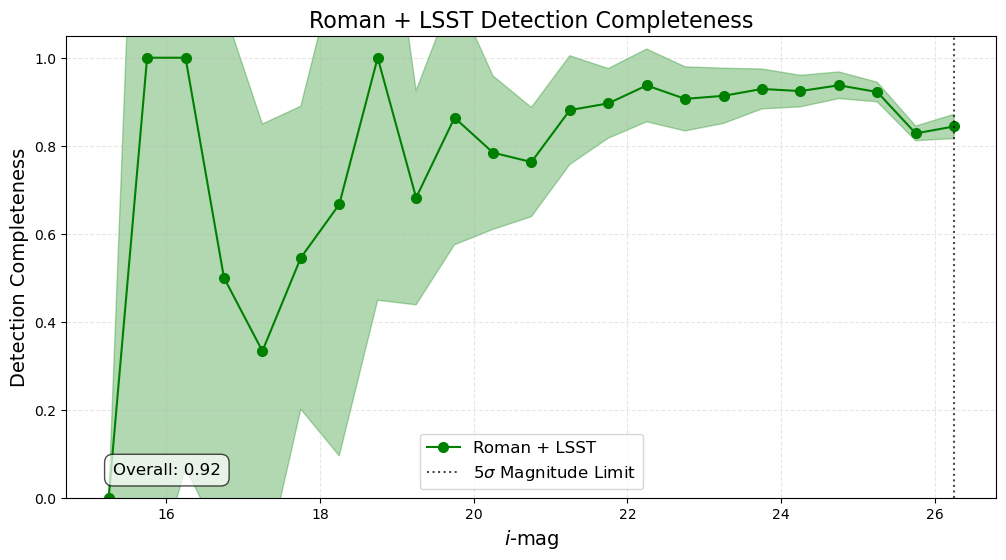

In [91]:
comp_data1 = calculate_completeness(matched_dd_truth, matched_truth[truth_mask])
comp_data2 = calculate_completeness(matched_dd_truth_ups, matched_truth_ups[truth_mask_ups])
comp_data3 = calculate_completeness(matched_lsst_det_truth, matched_truth[truth_mask])

# overall completeness stats
print(f"\nOverall Completeness Statistics:")
print(f"LSST Pipeline: {comp_data3['overall']:.4f} ± {comp_data3['overall_err']:.4f}")
print(f"LSST: {comp_data1['overall']:.4f} ± {comp_data1['overall_err']:.4f}")
print(f"Roman + LSST: {comp_data2['overall']:.4f} ± {comp_data2['overall_err']:.4f}")

# --- single completeness curves ---
plot_completeness(
    comp_data3,
    label="LSST Pipeline",
    title="LSST Pipeline Detection Completeness",
    show_errors=False,
    color='tab:blue',
    show_truth_dist=True
)

plot_completeness(
    comp_data1, 
    label="LSST", 
    title="LSST Detection Completeness",
    show_errors=False,
    show_truth_dist=True
)

plot_completeness(
    comp_data2,
    label="Roman + LSST",
    title="Roman + LSST Detection Completeness", 
    show_errors=False,
    show_truth_dist=True
)

plot_completeness(
    comp_data3,
    label="LSST Pipeline",
    title="LSST Pipeline Detection Completeness",
    show_errors=True,
    color='tab:blue'
)

plot_completeness(
    comp_data1, 
    label="LSST", 
    title="LSST Detection Completeness", 
    show_errors=True
)

plot_completeness(
    comp_data2,
    label="Roman + LSST",
    title="Roman + LSST Detection Completeness",
    show_errors=True
)

#### Why is LSST Pipeline Lower than LSST + Roman when it doesn't look like it on the graph? (Overall Completeness)

1.  **Truth Distribution Shape:** In all three plots, the 'Number of Truth Objects' follows a similar pattern. There are relatively few objects at brighter magnitudes (e.g., < 20) and the number increases significantly towards fainter magnitudes, peaking around mag 25-26 where there are thousands of objects per bin.

2.  **Weighting Effect:** Since the overall completeness is calculated across all objects, the performance in the magnitude bins with the *most objects* has the largest impact on the final overall score. In this case, the performance on faint objects (mag > 23) will have the greatest impact

3.  **Comparing LSST Pipeline (Overall: 0.87) and Roman + LSST (Overall: 0.92):**
    * **Faint End (mag > 23):** The region where the grey line (truth counts) is highest. In these bins, the **Roman + LSST** completeness curve (green) is generally **higher** than the LSST Pipeline curve (blue). The Roman+LSST curve stays mostly above 0.9, while the LSST Pipeline curve declines more steadily from ~0.95 down towards ~0.8.
    * **Brighter/Mid Range (mag < 23):** In this region, the **LSST Pipeline** curve (blue) is more consistently high (at or near 1.0) compared to the Roman + LSST curve (green), which has noticeable dips. However, the grey line shows there are significantly *fewer* truth objects in these bins compared to the faint end.

So, the overall completeness is dominated by the performance on the most numerous objects, which are the faint ones (mag > 23). In this faint regime, Roman + LSST demonstrates higher detection completeness than the LSST Pipeline. This better performance on the vast majority of the objects outweighs the LSST Pipeline's better performance on the less numerous brighter/mid-range objects.

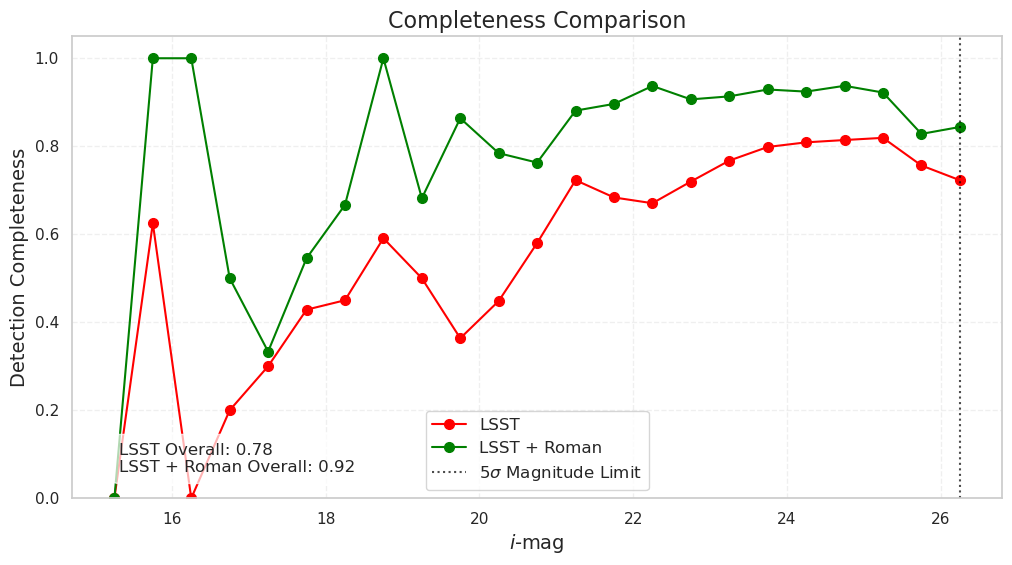

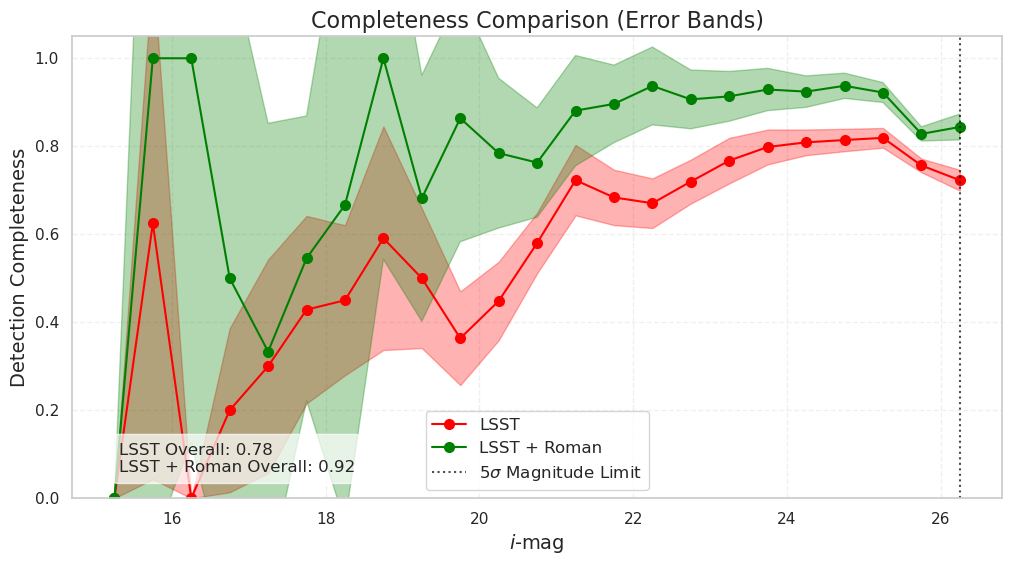

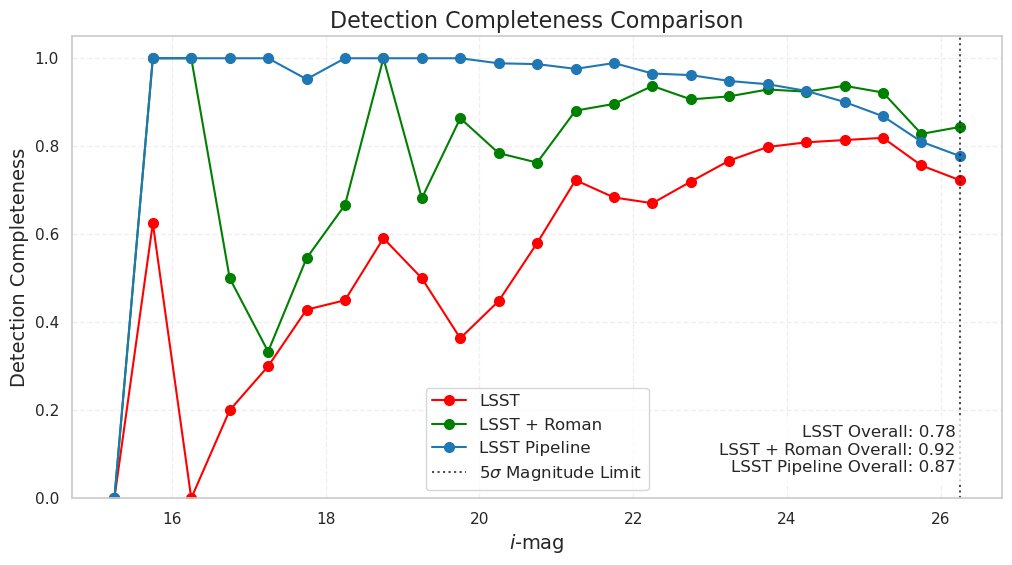

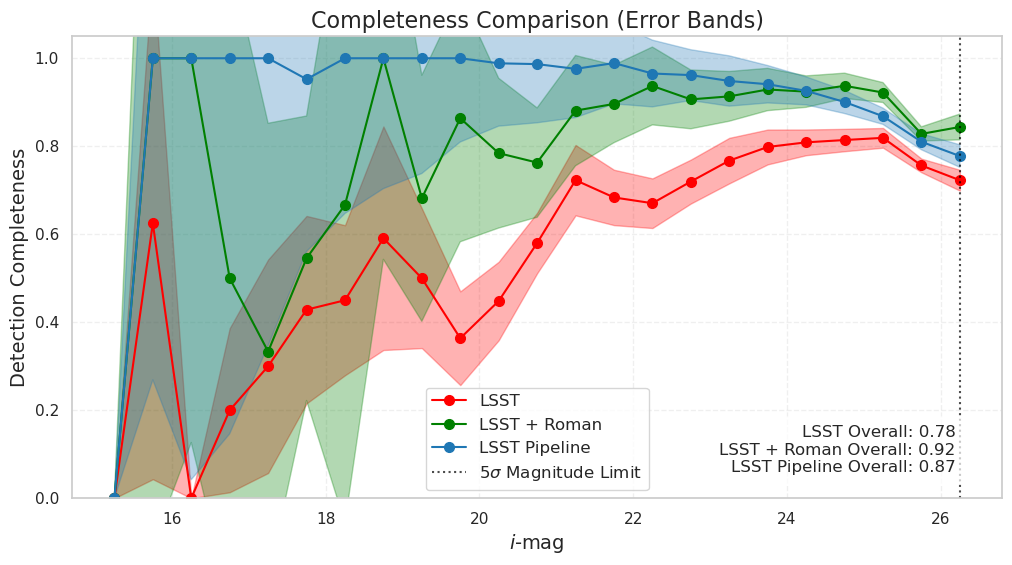

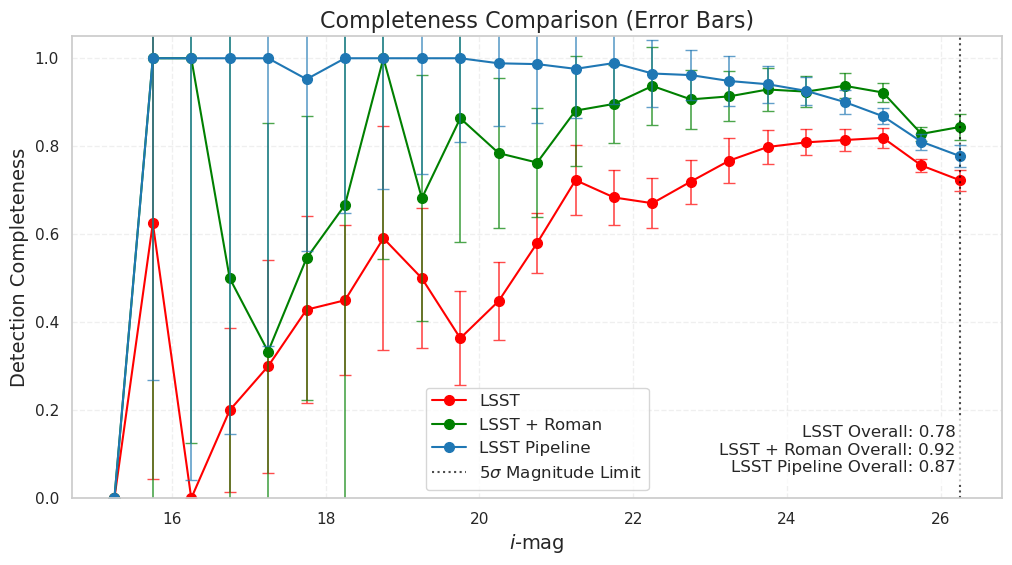

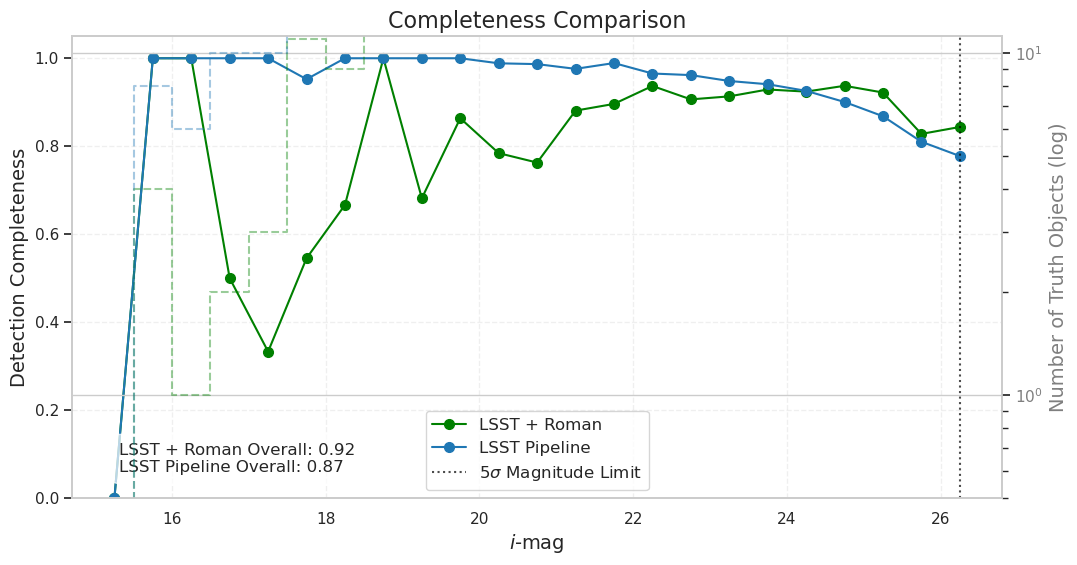

In [319]:
# --- comparison curves ---
# colors for the comparison plots
# order shld correspond to order of datasets in completeness_data_list
comparison_plot_colors = ["red", "green", "tab:blue"] # LSST, LSST + Roman, LSST pipeline respectively

# JUST LSST and ROMAN AND LSST
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2],
    labels=["LSST", "LSST + Roman"],       # labels for each dataset
    colors=comparison_plot_colors[:2],     # pass colors   
    title="Completeness Comparison", 
    show_errors=False,                      
)
# with error bands
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2],
    labels=["LSST", "LSST + Roman"],       
    colors=comparison_plot_colors[:2],         
    title="Completeness Comparison (Error Bands)", 
    show_errors=True,                      
    error_style='band'                     # filled bands for errors
)

# ALL THREE
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Detection Completeness Comparison", 
    show_errors=False,                      
)

# with error bands
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Completeness Comparison (Error Bands)", 
    show_errors=True,                      
    error_style='band'                    
)

# with error bars
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Completeness Comparison (Error Bars)",  
    show_errors=True,                      
    error_style='bars'                     # error bars
)

plot_completeness_comparison(
    completeness_data_list=[comp_data2, comp_data3],
    labels=["LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors[1:],         
    title="Completeness Comparison",  
    show_errors=False,                      
    show_truth_dist=True
)

#### If we use the same truth catalog for both LSST and LSST + Roman catalogs

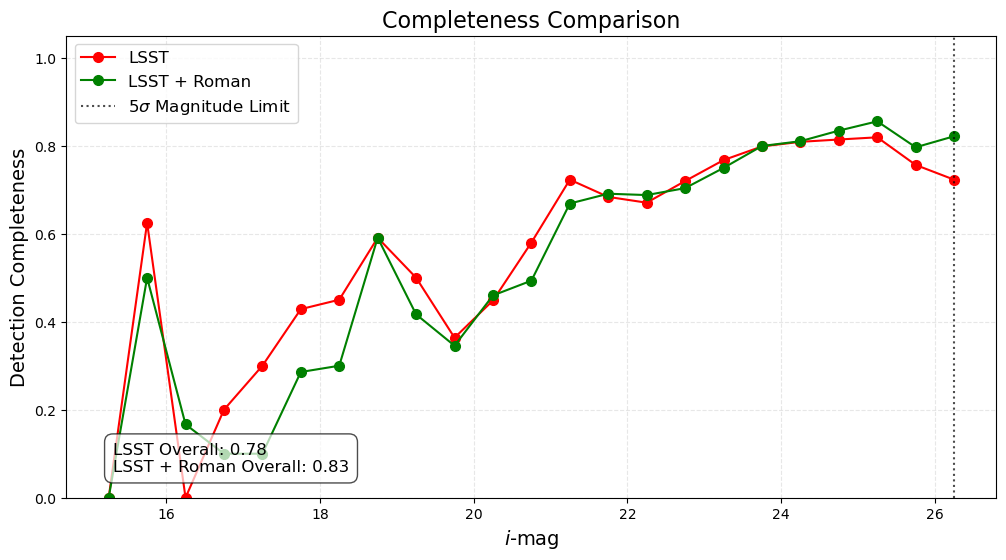

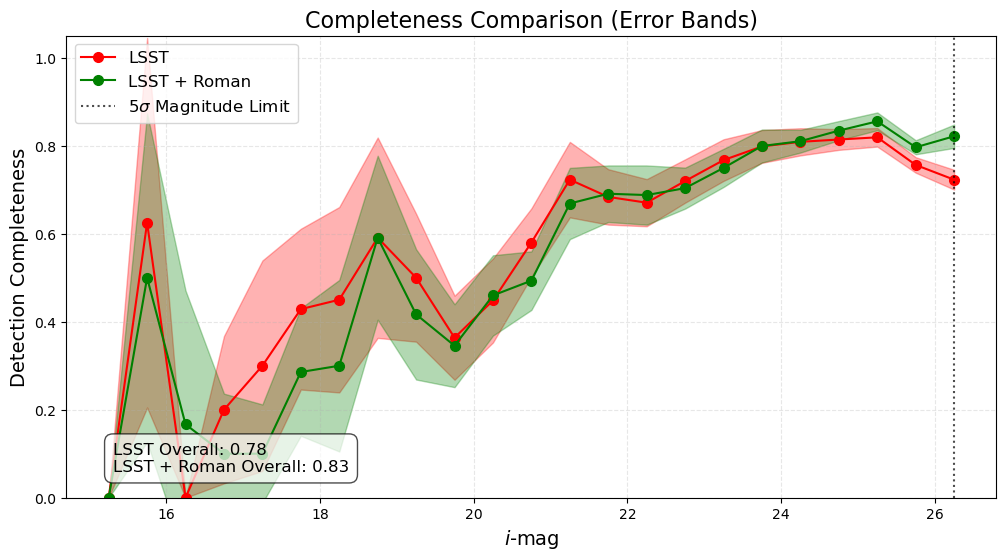

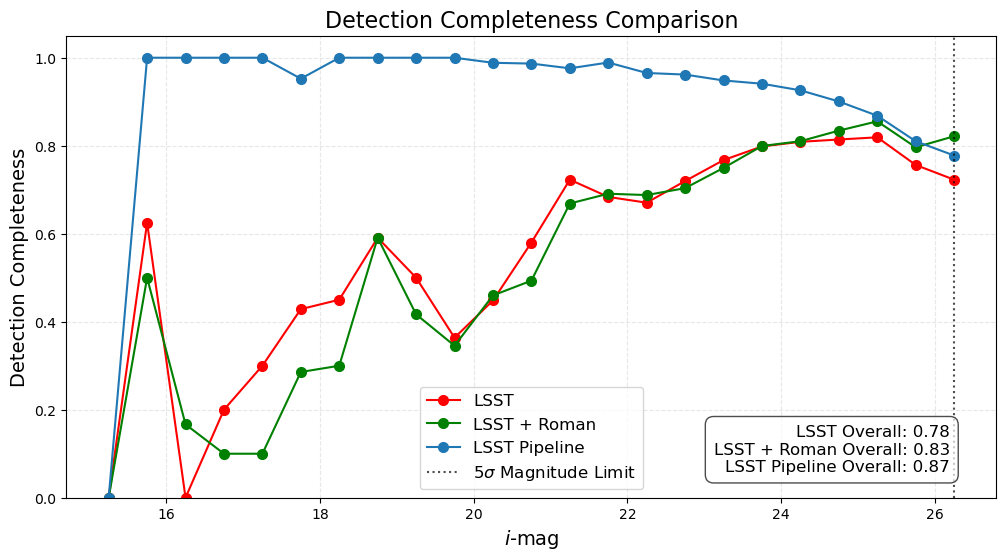

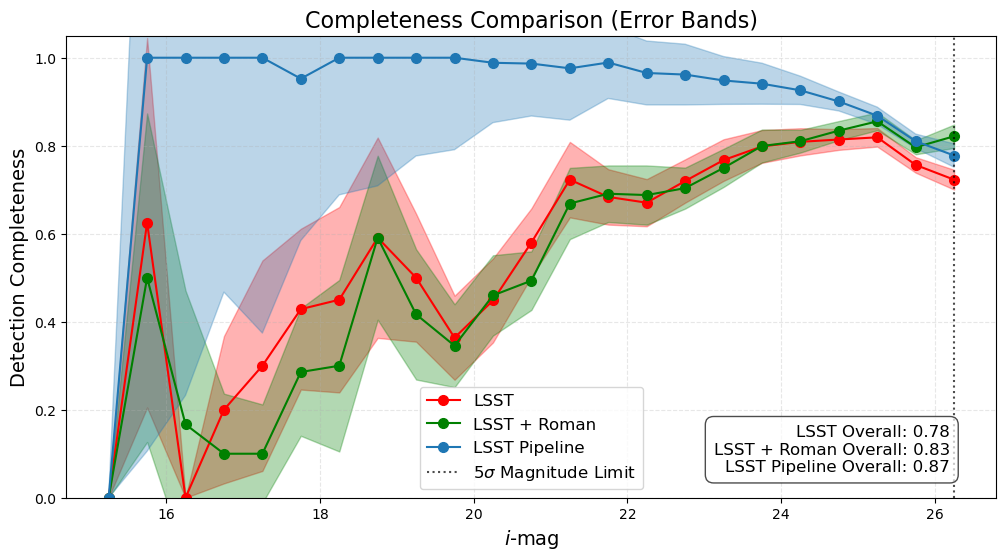

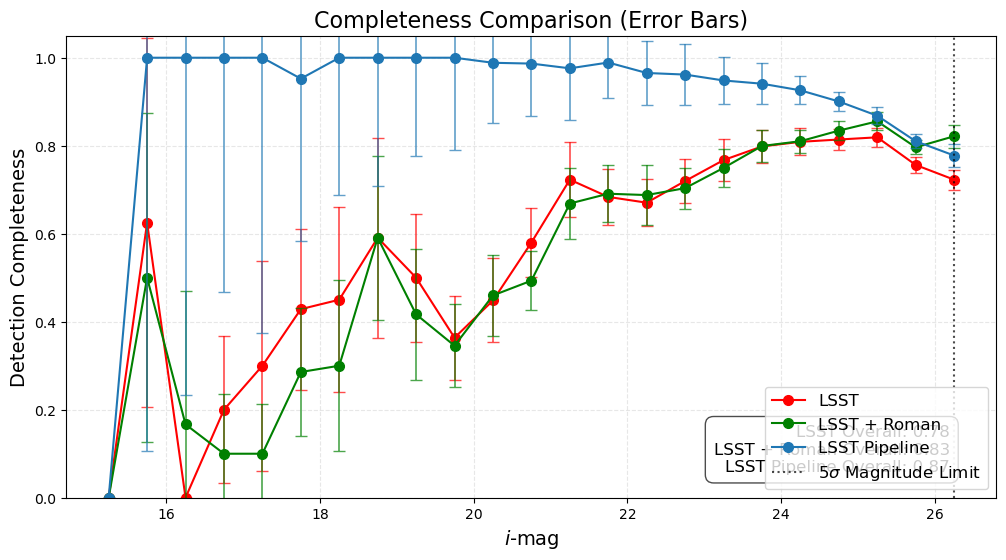

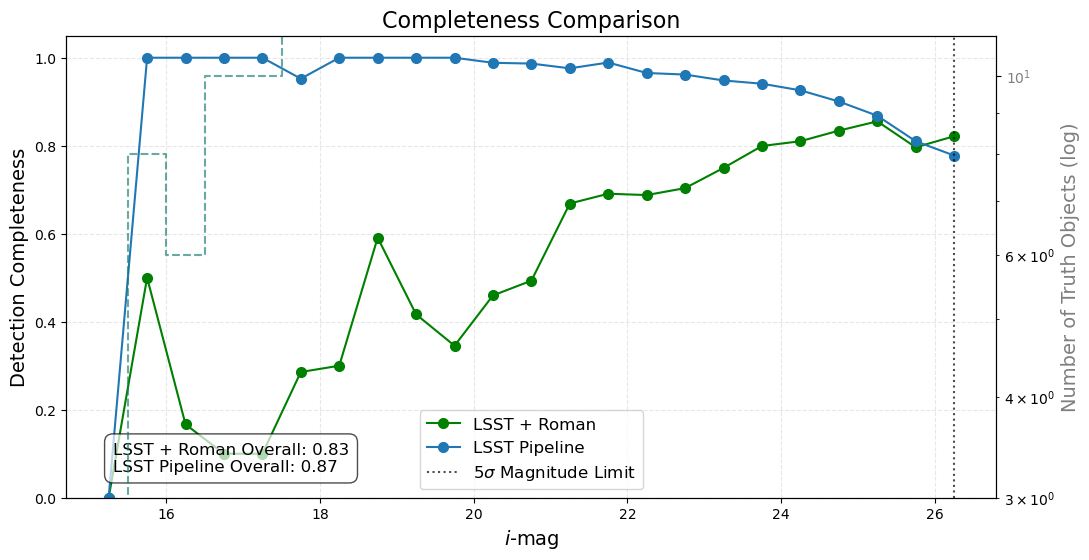

In [24]:
# --- comparison curves ---
# colors for the comparison plots
# order shld correspond to order of datasets in completeness_data_list
comparison_plot_colors = ["red", "green", "tab:blue"] # LSST, LSST + Roman, LSST pipeline respectively

# JUST LSST and ROMAN AND LSST
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2],
    labels=["LSST", "LSST + Roman"],       # labels for each dataset
    colors=comparison_plot_colors[:2],     # pass colors   
    title="Completeness Comparison", 
    show_errors=False,                      
)
# with error bands
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2],
    labels=["LSST", "LSST + Roman"],       
    colors=comparison_plot_colors[:2],         
    title="Completeness Comparison (Error Bands)", 
    show_errors=True,                      
    error_style='band'                     # filled bands for errors
)

# ALL THREE
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Detection Completeness Comparison", 
    show_errors=False,                      
)

# with error bands
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Completeness Comparison (Error Bands)", 
    show_errors=True,                      
    error_style='band'                    
)

# with error bars
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Completeness Comparison (Error Bars)",  
    show_errors=True,                      
    error_style='bars'                     # error bars
)

plot_completeness_comparison(
    completeness_data_list=[comp_data2, comp_data3],
    labels=["LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors[1:],         
    title="Completeness Comparison",  
    show_errors=False,                      
    show_truth_dist=True
)

### When `lvl=5` in newest annotation code

In [6]:
run_dir_lsst = 'run5_sm_dlvl5'
run_dir_both = 'run5_ups_roman_dlvl5'

In [7]:
matched_lsst_det_truth_fi = f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/test_lsst_det_truth11_info.json' 
matched_lsst_det_truth = pd.read_json(matched_lsst_det_truth_fi, orient='records')
matched_lsst_det_truth = matched_lsst_det_truth[matched_lsst_det_truth['mag_i'] < truth_mag_limit]

In [8]:
# lsst_runs/run5_sm_dlvl5/lsst_dlvl5.pth
matched_dd_truth_filename = f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/dd_truth11_info_s0.3_n0.5.json'
matched_dd_truth = pd.read_json(matched_dd_truth_filename, orient='records')
matched_truth = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/test_truth11_cat.json')

In [9]:
# lsst_runs/run5_sm_dlvl5/lsst_dlvl5.pth
matched_dd_truth_filename_ups = f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_both}/dd_truth11_info_s0.3_n0.5.json'
matched_dd_truth_ups = pd.read_json(matched_dd_truth_filename_ups, orient='records')
matched_truth_ups = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/test_truth11_cat.json')

In [10]:
truth_mask = (matched_truth['mag_i'] < truth_mag_limit) & (matched_truth['mag_i'] > 15.5)
truth_mask_ups = (matched_truth_ups['mag_i'] < truth_mag_limit) & (matched_truth_ups['mag_i'] > 15.5)

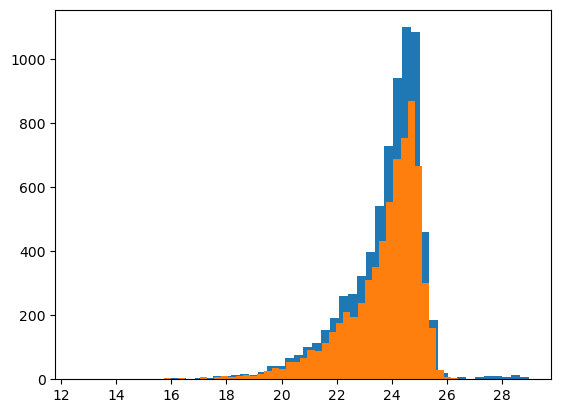

In [15]:
plt.hist(matched_truth.mag_i,bins=50);
plt.hist(matched_lsst_det_truth.mag_i,bins=50);


Overall Completeness Statistics:
LSST Pipeline: 0.9383 ± 0.0000
LSST: 0.8303 ± 0.0000
Roman + LSST: 0.8590 ± 0.0000


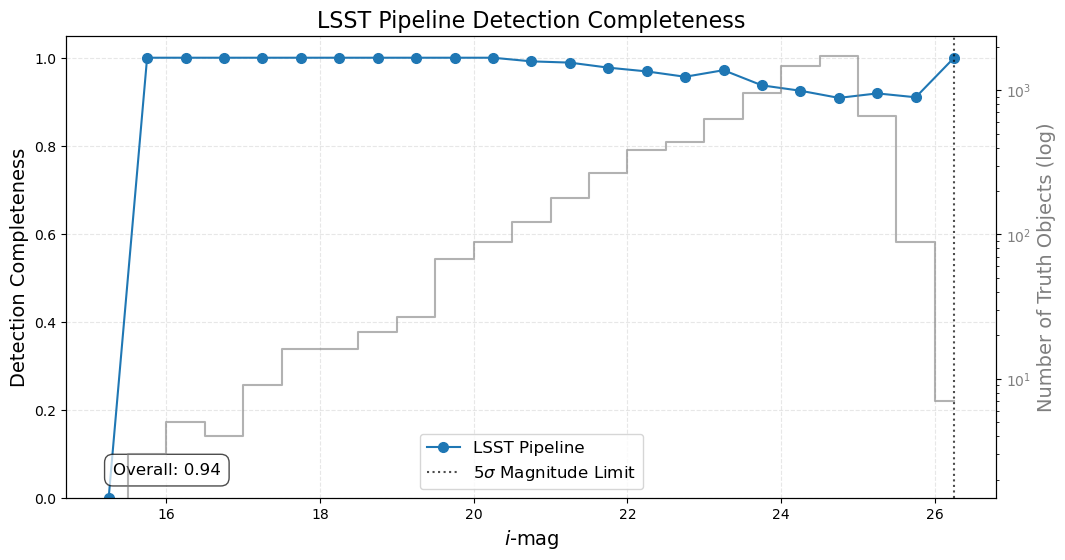

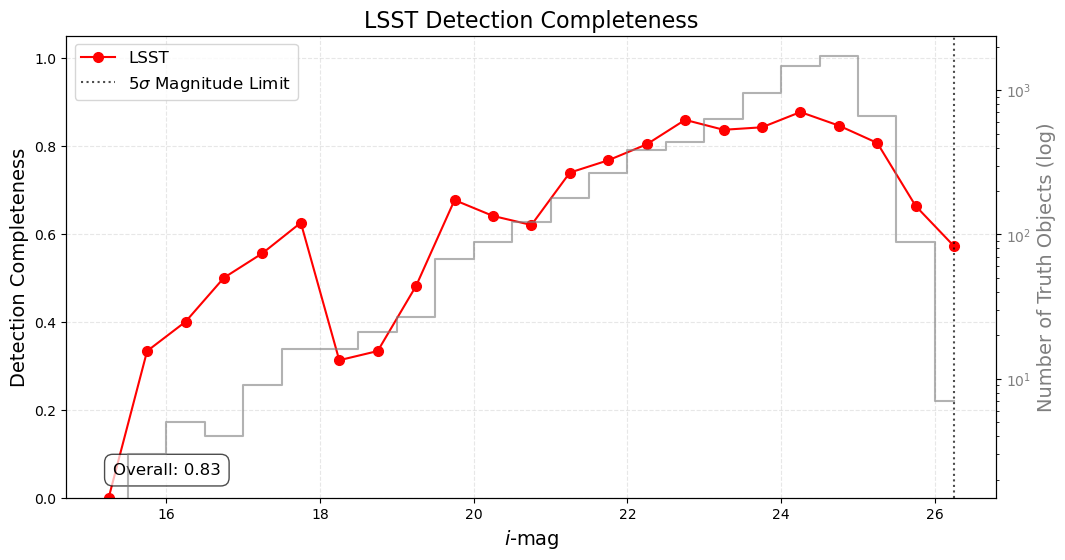

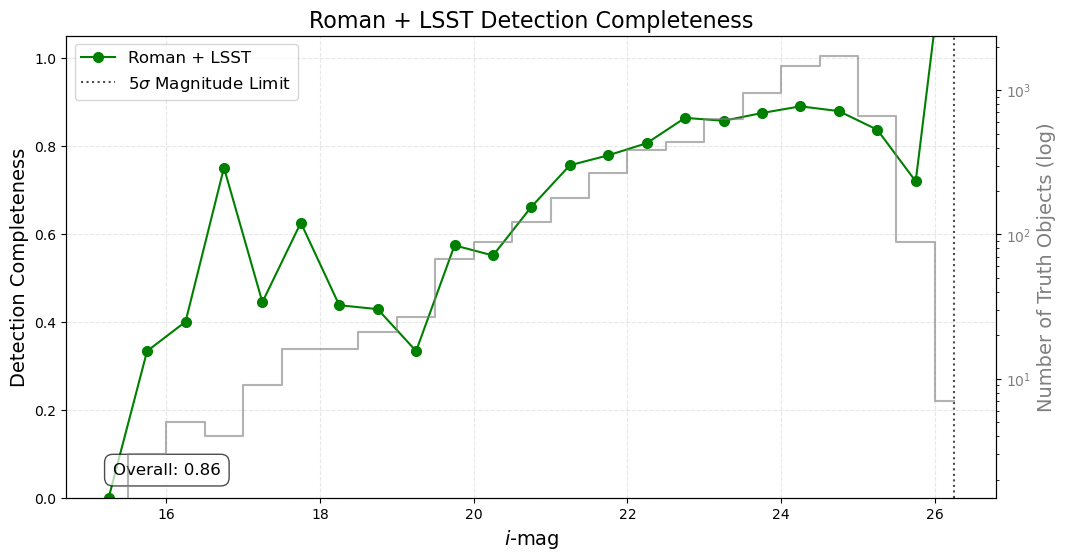

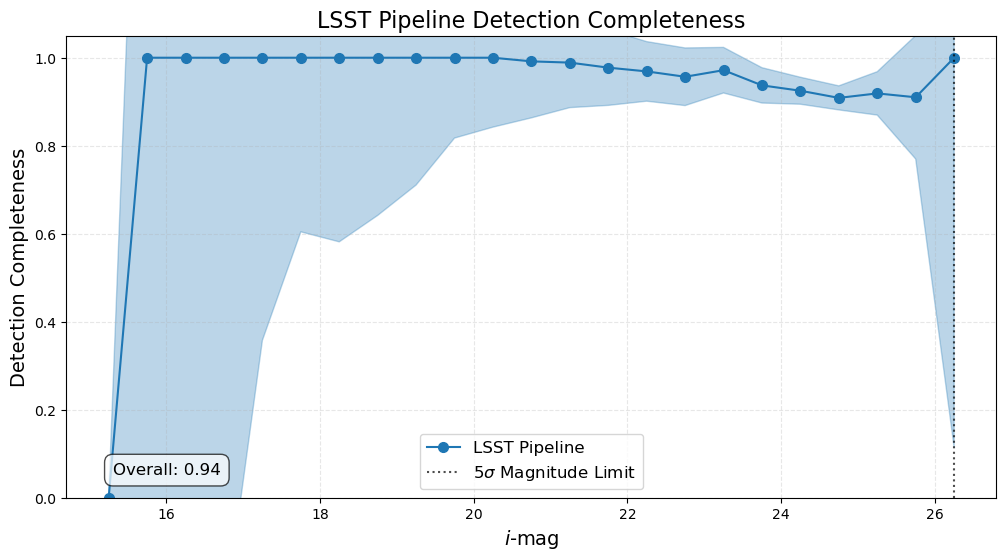

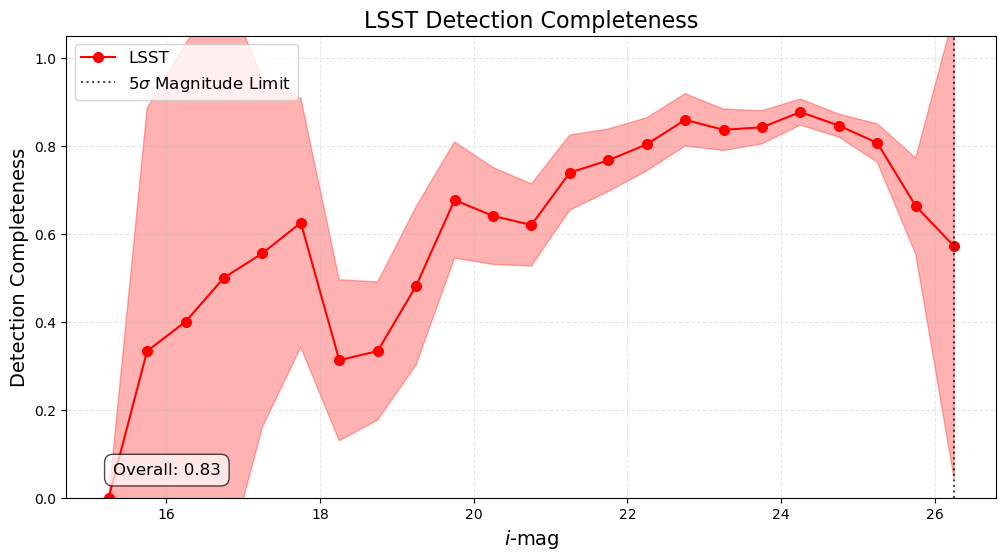

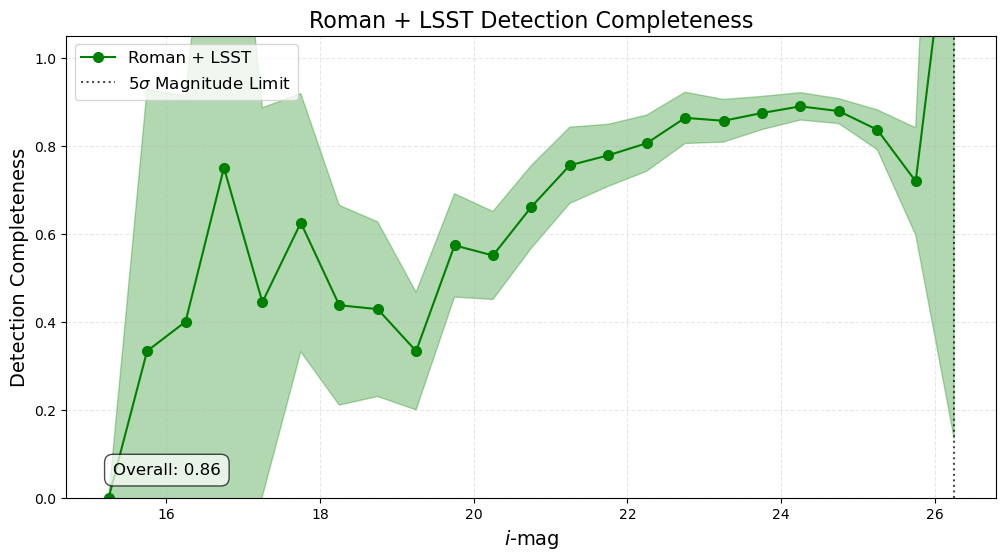

In [16]:
comp_data1 = calculate_completeness(matched_dd_truth, matched_truth[truth_mask])
comp_data2 = calculate_completeness(matched_dd_truth_ups, matched_truth_ups[truth_mask_ups])
comp_data3 = calculate_completeness(matched_lsst_det_truth, matched_truth[truth_mask])

# overall completeness stats
print(f"\nOverall Completeness Statistics:")
print(f"LSST Pipeline: {comp_data3['overall']:.4f} ± {comp_data3['overall_err']:.4f}")
print(f"LSST: {comp_data1['overall']:.4f} ± {comp_data1['overall_err']:.4f}")
print(f"Roman + LSST: {comp_data2['overall']:.4f} ± {comp_data2['overall_err']:.4f}")

# single completeness curves

plot_completeness(
    comp_data3,
    label="LSST Pipeline",
    title="LSST Pipeline Detection Completeness",
    show_errors=False,
    color='tab:blue',
    show_truth_dist=True
)

plot_completeness(
    comp_data1, 
    label="LSST", 
    title="LSST Detection Completeness",
    show_errors=False,
    show_truth_dist=True
)

plot_completeness(
    comp_data2,
    label="Roman + LSST",
    title="Roman + LSST Detection Completeness", 
    show_errors=False,
    show_truth_dist=True
)

plot_completeness(
    comp_data3,
    label="LSST Pipeline",
    title="LSST Pipeline Detection Completeness",
    show_errors=True,
    color='tab:blue'
)

plot_completeness(
    comp_data1, 
    label="LSST", 
    title="LSST Detection Completeness", 
    show_errors=True
)

plot_completeness(
    comp_data2,
    label="Roman + LSST",
    title="Roman + LSST Detection Completeness",
    show_errors=True
)

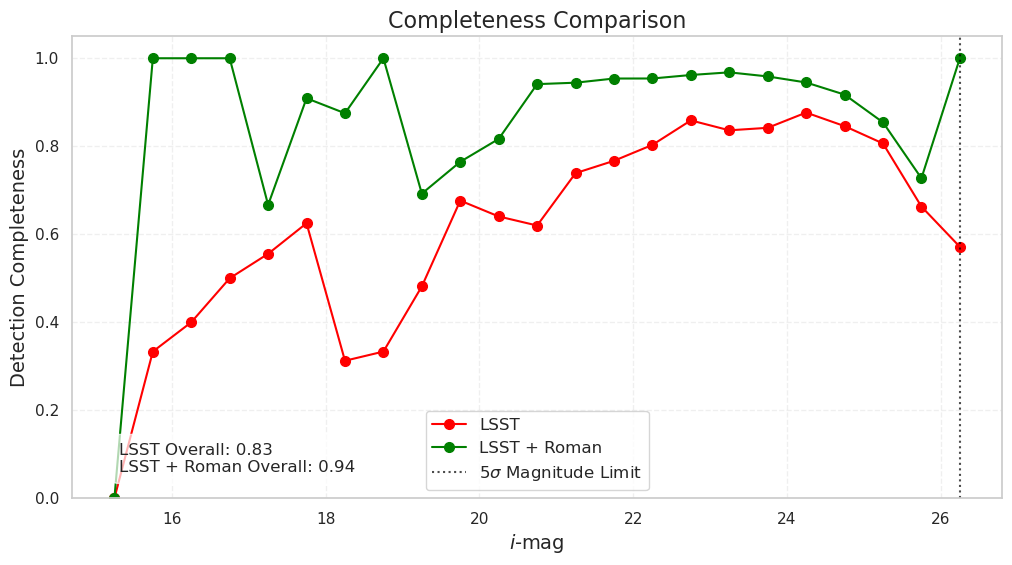

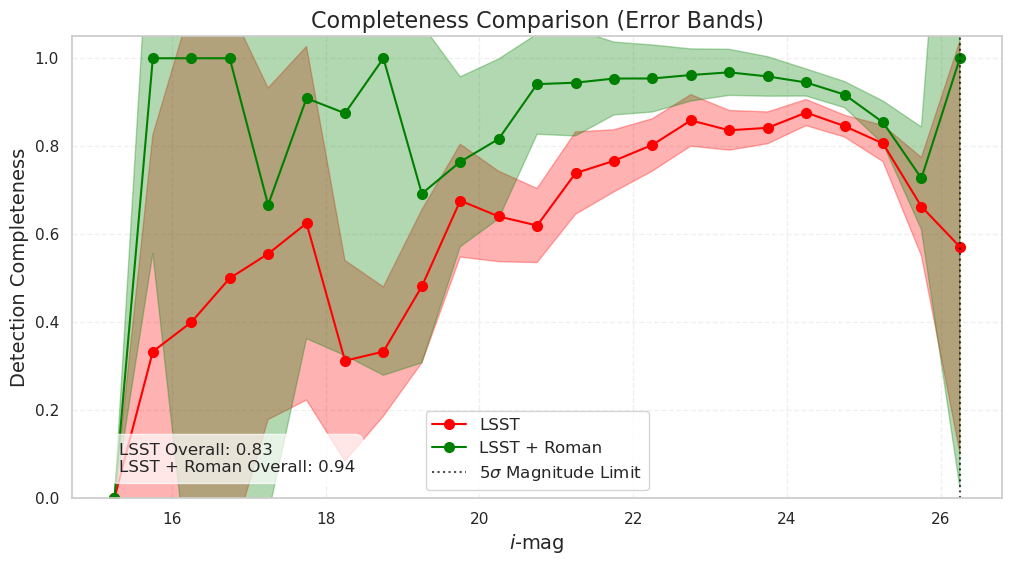

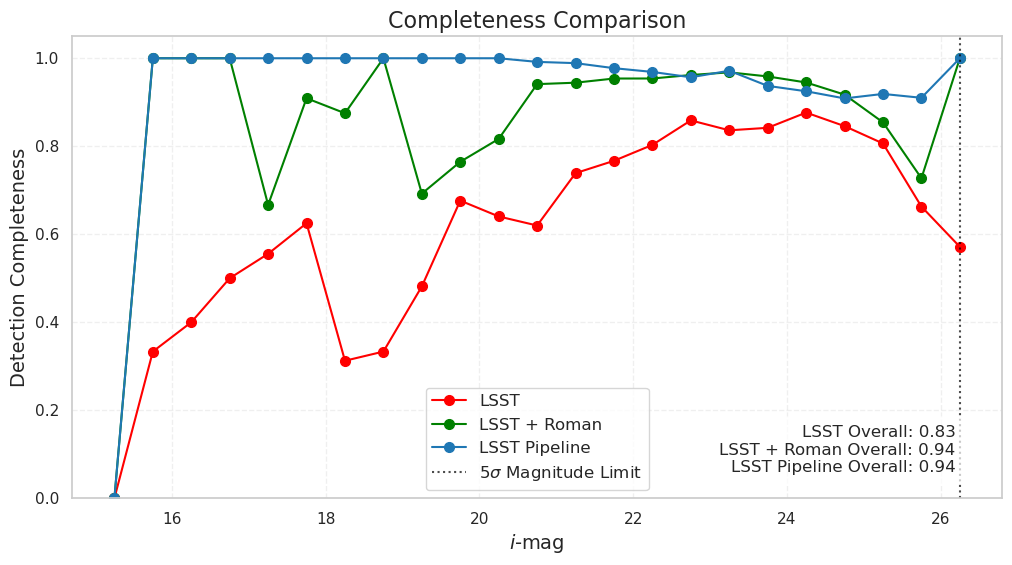

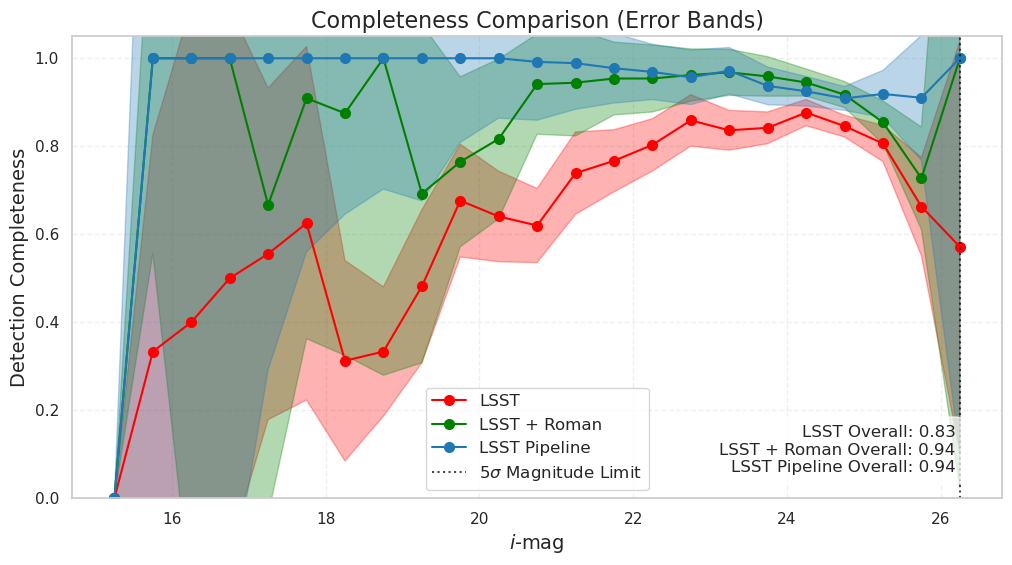

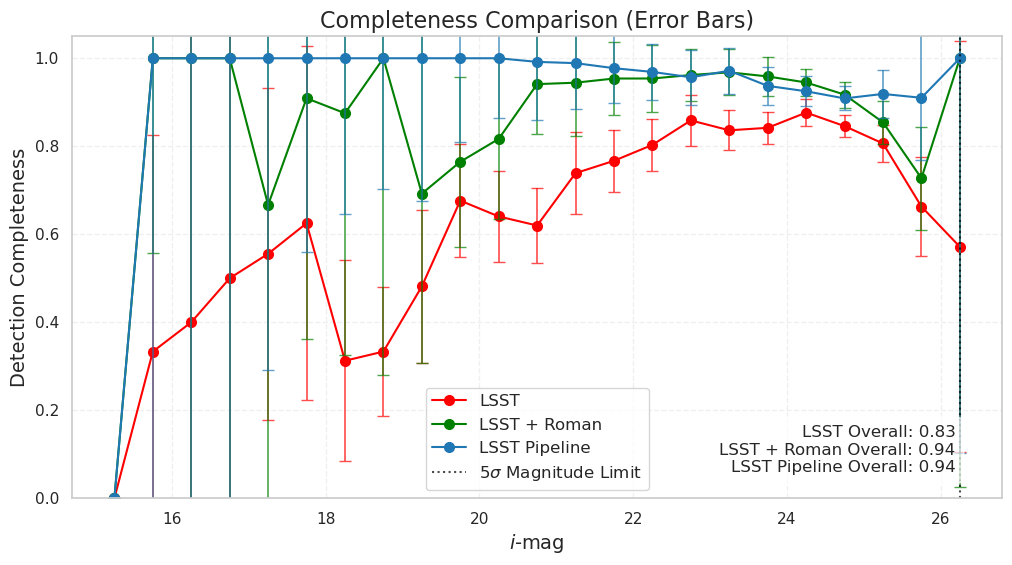

In [326]:
# --- comparison curves ---
# colors for the comparison plots
# order shld correspond to order of datasets in completeness_data_list
comparison_plot_colors = ["red", "green", "tab:blue"] # LSST, LSST + Roman, LSST pipeline respectively

# JUST LSST and ROMAN AND LSST
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2],
    labels=["LSST", "LSST + Roman"],       # labels for each dataset
    colors=comparison_plot_colors[:2],     # pass colors   
    title="Completeness Comparison", 
    show_errors=False,                      
)
# with error bands
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2],
    labels=["LSST", "LSST + Roman"],       
    colors=comparison_plot_colors[:2],         
    title="Completeness Comparison (Error Bands)", 
    show_errors=True,                      
    error_style='band'                     # filled bands for errors
)

# ALL THREE
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Detection Completeness Comparison", 
    show_errors=False,                      
)

# with error bands
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Completeness Comparison (Error Bands)", 
    show_errors=True,                      
    error_style='band'                    
)

# with error bars
plot_completeness_comparison(
    completeness_data_list=[comp_data1, comp_data2, comp_data3],
    labels=["LSST", "LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors,         
    title="Completeness Comparison (Error Bars)",  
    show_errors=True,                      
    error_style='bars'                     # error bars
)

plot_completeness_comparison(
    completeness_data_list=[comp_data2, comp_data3],
    labels=["LSST + Roman", "LSST Pipeline"],       
    colors=comparison_plot_colors[1:],         
    title="Completeness Comparison",  
    show_errors=False,                      
    show_truth_dist=True
)

## FOF Plot

### Helper Functions

In [14]:
import FoFCatalogMatching
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column
from astropy.nddata import Cutout2D

# points within 1 arcsecs of each other are grouped together only if there's no more than 3 friends within 1 arcsec
# None following distance means points are grouped together without any constraint on number of friends
def find_matches(cat_a, cat_b, cat_a_name, cat_b_name, linking_length=1.0, max_friends=1):
    """
    Find matches between two catalogs using Friends-of-Friends algorithm.
    
    Parameters:
    -----------
    cat_a, cat_b : astropy.table.Table
        The two catalogs to match.
    cat_a_name, cat_b_name : str
        Names for the two catalogs.
    linking_length : float, optional
        The linking length in arcseconds. Default is 0.5.
    max_friends : int or None, optional
        The maximum number of friends allowed in a group. 
        Use None for no limit. Default is 1.
    
    Returns:
    --------
    astropy.table.Table
        Matched catalog with group IDs.
    """
    # first linking length groups points within that distance, limited by max_friends
    linking_lengths = {linking_length: max_friends}
    # use lsst truth catalog to get 1-1 match with LSST Det/Roman Det to recreat Fig 11 from Troxel Paper     
    return FoFCatalogMatching.match({cat_a_name: cat_a, cat_b_name: cat_b},
                               linking_lengths)

In [15]:
# does same mag cut to truth that detection also has
def get_lsst_cat_ras_decs(lsst_cat, mag_limit=None, mag_col='mag_i'):
    lsst_df = lsst_cat.copy()
    if mag_limit:
        lsst_df = lsst_cat[(lsst_cat[mag_col] < mag_limit)]
    ra_dec_df = lsst_df[['ra','dec']]
    mags = lsst_df['mag_i']
    return Table.from_pandas(ra_dec_df), list(mags)

# Adapted from https://nbviewer.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_fof.nbconvert.ipynb
def autofit_text(ax, text, x, y):
    fontsize = 11
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="none", alpha=0)

    while fontsize > 1:
        t = ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, 
                    color='white', bbox=bbox_props)
        
        # grab the renderer
        r = ax.figure.canvas.get_renderer()
        bb = t.get_window_extent(renderer=r).transformed(ax.transData.inverted())
        
        # check if text fits within the cell
        if bb.width < 1 and bb.height < 1:
            return
        
        t.remove()
        fontsize -= 1

    # if we got here, text is too large to fit at any readable size
    ax.text(x, y, '.', ha='center', va='center', fontsize=8, color='white')
    
def plot_matches(results, x_axis_name, xlabel, ylabel):
    # now we want to count the number of cat a and cat b objects *for each group*
    # but instead of looping over groups, we can do this

    # first we need to know which rows are from the x-axis cat (catalog A) and which are from y-axis cat (catalog B)
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask

    # then np.bincount will give num of id occurrences in each group (like historgram but with int input)
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    # print(n_truth[n_truth>10])
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    # unique, counts = np.unique(n_a, return_counts=True)
    # print("n_a:", dict(zip(unique, counts)))
    # unique2, counts2 = np.unique(n_b, return_counts=True)
    # print("n_b:", dict(zip(unique2, counts2)))

    # now n_a and n_b are the number of cat a/cat b objects in each group
    # we want to make a 2d histrogram of (n_a, n_b). 
    n_max = max(n_a.max(), n_b.max()) + 1
    hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # how we want to visualize our histograms
    # hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # how they choose to visualize their histograms
    plt.figure(figsize=(12,10))
    plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower', cmap='Oranges')
    plt.xlabel(f'Number of {xlabel}')
    plt.ylabel(f'Number of {ylabel}')
    plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$')
    ax = plt.gca()
    for i in range(n_max):
        for j in range(n_max):
            if hist_2d[i, j] > 0:
                text = str(hist_2d[i, j])
                autofit_text(ax, text, j, i)

In [19]:
# for all SNR levels
baseline_mag_5sigma_10yr_i = 26.8  # From Rubin key numbers
years = 5
truth_mag_limit = truth_catalog_cut(baseline_mag_5sigma_10yr_i, years)
print(f"Truth catalog cut: mag_i ≤ {truth_mag_limit}")  # 26.42

Truth catalog cut: mag_i ≤ 26.423712505420024


### Getting the FOF matching results

In [32]:
run_dir_lsst = 'run6_sm_dlvl2'
run_dir_both = 'run5_ups_roman_dlvl2'

In [38]:
dd_test_det

ra        dec
0      50.956891 -42.006051
1      50.950712 -42.007752
2      50.951701 -42.001143
3      50.950380 -42.001344
4      50.952715 -42.002732
...          ...        ...
18031  54.971976 -41.953772
18032  54.980024 -41.954526
18033  54.977691 -41.956011
18034  54.980864 -41.957205
18035  54.979826 -41.956835

[18036 rows x 2 columns]

In [33]:
lsst_test_det = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/test_lsst_det_fof_info.json')
dd_test_det = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/pred_s0.3_n0.5_radec.json')

dd_det_table = Table.from_pandas(dd_test_det)

lsst_test_det_ups = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_both}/test_lsst_det_fof_info.json')
dd_test_det_ups = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_both}/pred_s0.3_n0.5_radec.json')

dd_det_table_ups = Table.from_pandas(dd_test_det_ups)

lsst_test_det_table, test_det_mags = get_lsst_cat_ras_decs(lsst_test_det)
lsst_test_det_table_ups, test_det_mags_ups = get_lsst_cat_ras_decs(lsst_test_det_ups)

matched_truth = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_lsst}/test_truth11_cat.json')
matched_truth_ups = pd.read_json(f'/home/shared/hsc/roman_lsst/lsst_runs/{run_dir_both}/test_truth11_cat.json')

truth_mask = (matched_truth['mag_i'] < truth_mag_limit)
truth_mask_ups = (matched_truth_ups['mag_i'] < truth_mag_limit)

FileNotFoundError: File /home/shared/hsc/roman_lsst/lsst_runs/run5_ups_roman_dlvl2/test_lsst_det_fof_info.json does not exist

### Just LSST

In [22]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_truth'
cat_b_name = 'lsst_det'
lsst_det_lsst_truth1 = find_matches(cat_a=matched_truth[truth_mask], cat_b=lsst_test_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
lsst_det_lsst_truth05 = find_matches(cat_a=matched_truth[truth_mask], cat_b=lsst_test_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

In [23]:
lsst_det_lsst_truth1

<Table length=28325>
row_index catalog_key group_id
  int64      str10     int64  
--------- ----------- --------
        0  lsst_truth        0
    13868    lsst_det        0
        1  lsst_truth        1
    13859    lsst_det        1
        2  lsst_truth        2
    13865    lsst_det        2
        3  lsst_truth        3
    13933    lsst_det        3
        4  lsst_truth        4
    13861    lsst_det        4
      ...         ...      ...
    21103    lsst_det    21287
    21104    lsst_det    21288
    21105    lsst_det    21289
    21108    lsst_det    21290
    21109    lsst_det    21291
    21110    lsst_det    21292
    21111    lsst_det    21293
    21112    lsst_det    21294
    21113    lsst_det    21295
    21114    lsst_det    21296

In [36]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_truth'
cat_b_name = 'dd_det'
dd_det_lsst_truth1 = find_matches(cat_a=matched_truth[truth_mask], cat_b=dd_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_truth05 = find_matches(cat_a=matched_truth[truth_mask], cat_b=dd_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

In [ ]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_det'
cat_b_name = 'dd_det'
dd_det_lsst_det1 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_det05 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_det_table,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

#### Plots

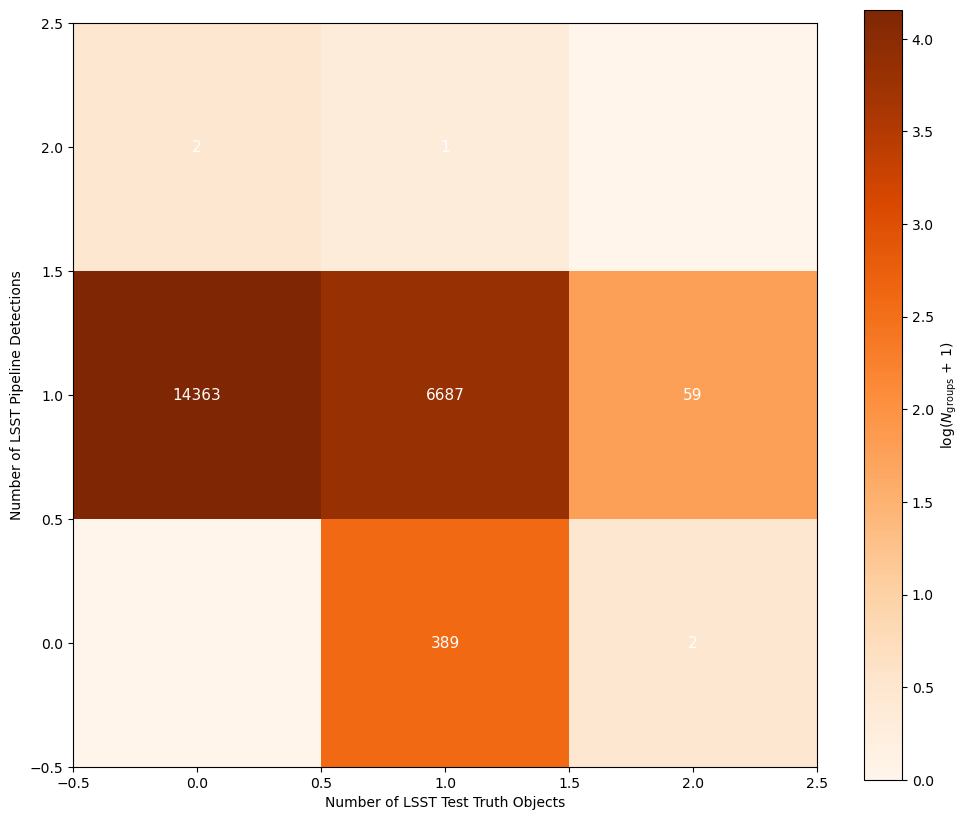

In [41]:
plot_matches(lsst_det_lsst_truth05, x_axis_name='lsst_truth', xlabel='LSST Test Truth Objects', ylabel='LSST Pipeline Detections')

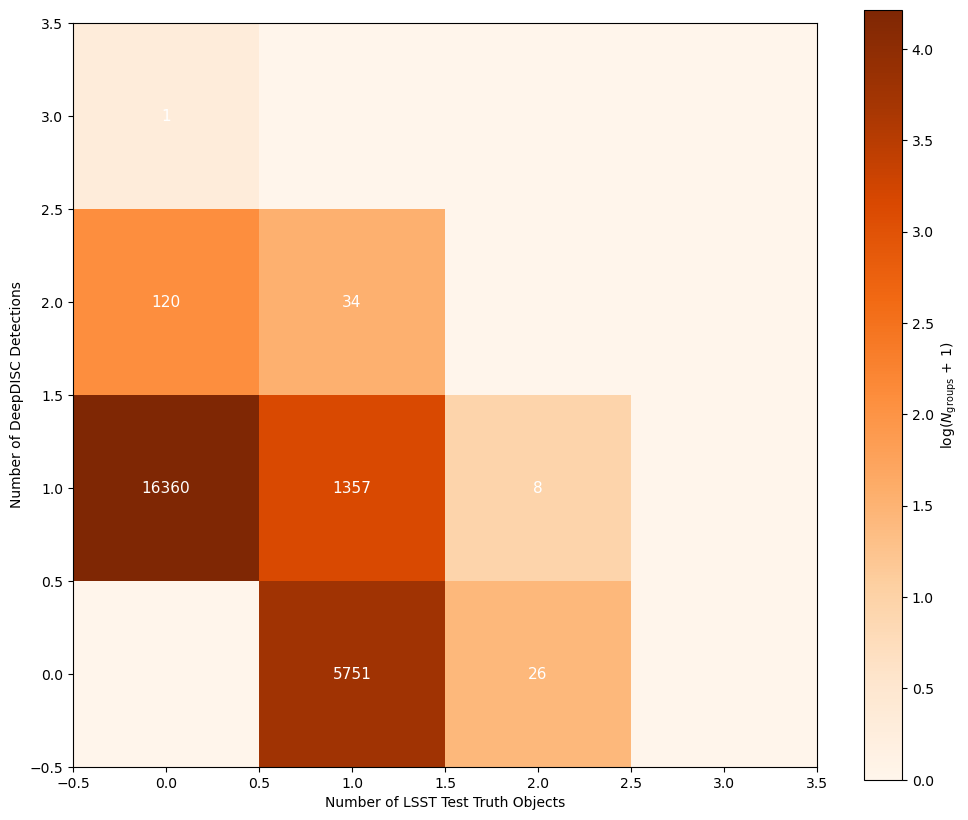

In [37]:
plot_matches(dd_det_lsst_truth05, x_axis_name='lsst_truth', xlabel='LSST Test Truth Objects', ylabel='DeepDISC Detections')

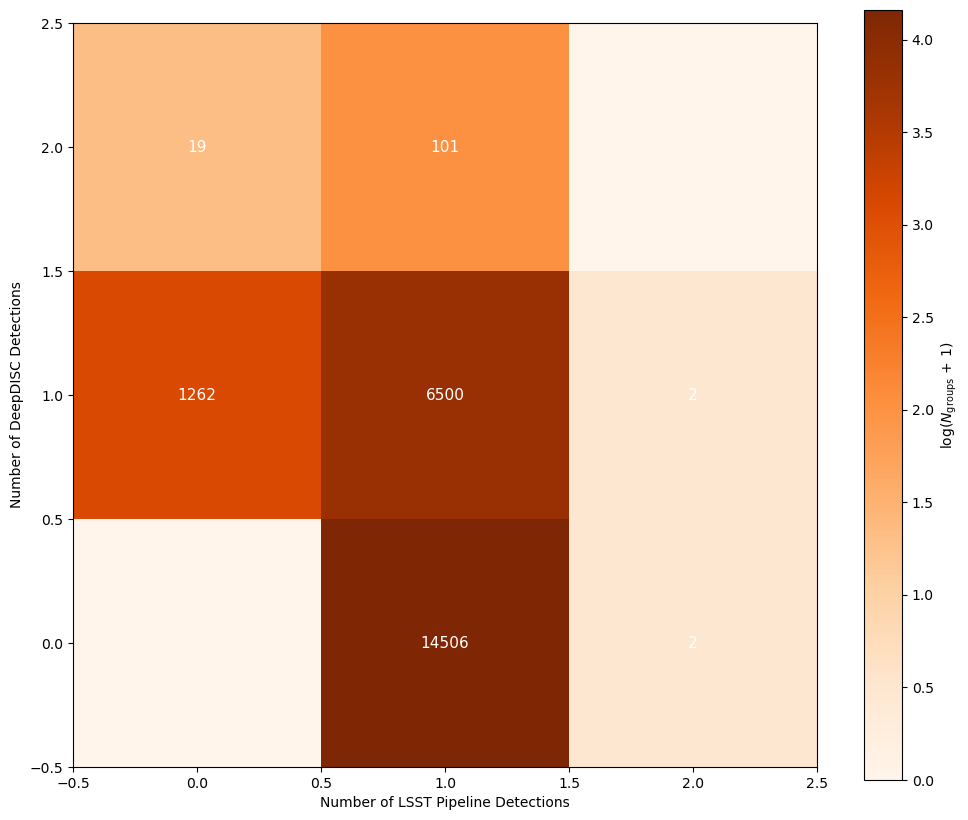

In [43]:
plot_matches(dd_det_lsst_det05, x_axis_name='lsst_det', xlabel='LSST Pipeline Detections', ylabel='DeepDISC Detections')

### Roman + LSST

In [126]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_truth'
cat_b_name = 'lsst_det'
lsst_det_lsst_truth1_rl = find_matches(cat_a=matched_truth_ups[truth_mask_ups], cat_b=lsst_test_det_table_ups,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
lsst_det_lsst_truth05_rl = find_matches(cat_a=matched_truth_ups[truth_mask_ups], cat_b=lsst_test_det_table_ups,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

In [127]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_truth'
cat_b_name = 'dd_det'
dd_det_lsst_truth1_rl = find_matches(cat_a=matched_truth_ups[truth_mask_ups], cat_b=dd_det_table_ups,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_truth05_rl = find_matches(cat_a=matched_truth_ups[truth_mask_ups], cat_b=dd_det_table_ups,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

In [128]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_det'
cat_b_name = 'dd_det'
dd_det_lsst_det1_rl = find_matches(cat_a=lsst_test_det_table_ups, cat_b=dd_det_table_ups,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_det05_rl = find_matches(cat_a=lsst_test_det_table_ups, cat_b=dd_det_table_ups,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

#### Plots

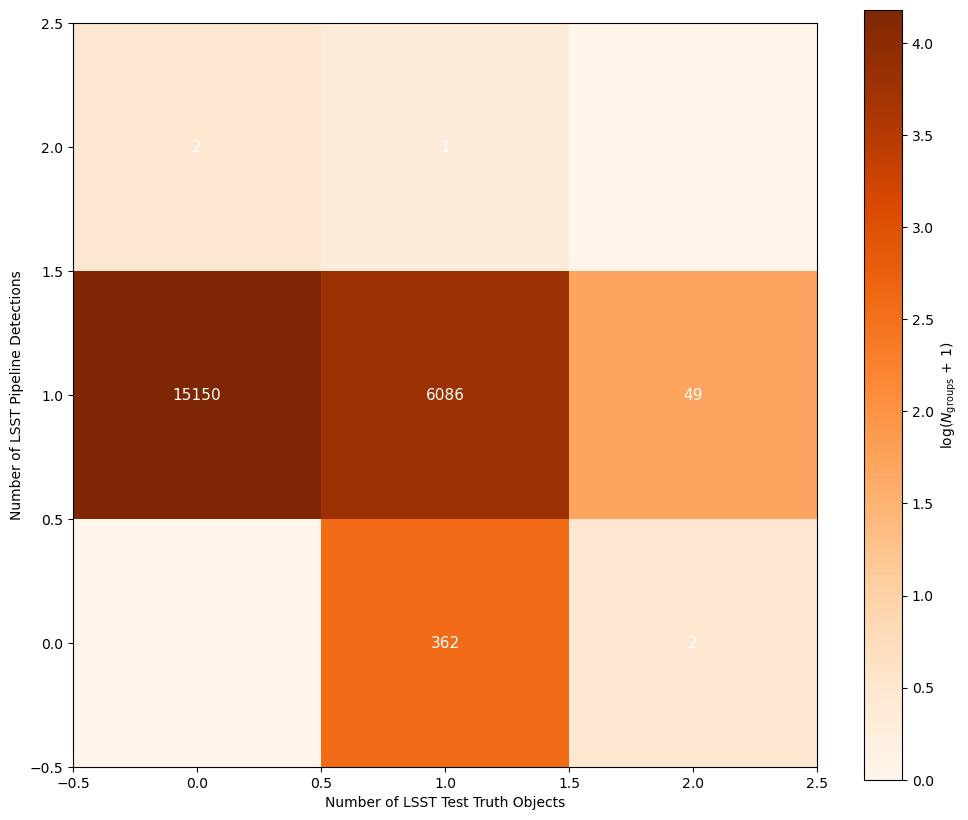

In [130]:
plot_matches(lsst_det_lsst_truth05_rl, x_axis_name='lsst_truth', xlabel='LSST Test Truth Objects', ylabel='LSST Pipeline Detections')

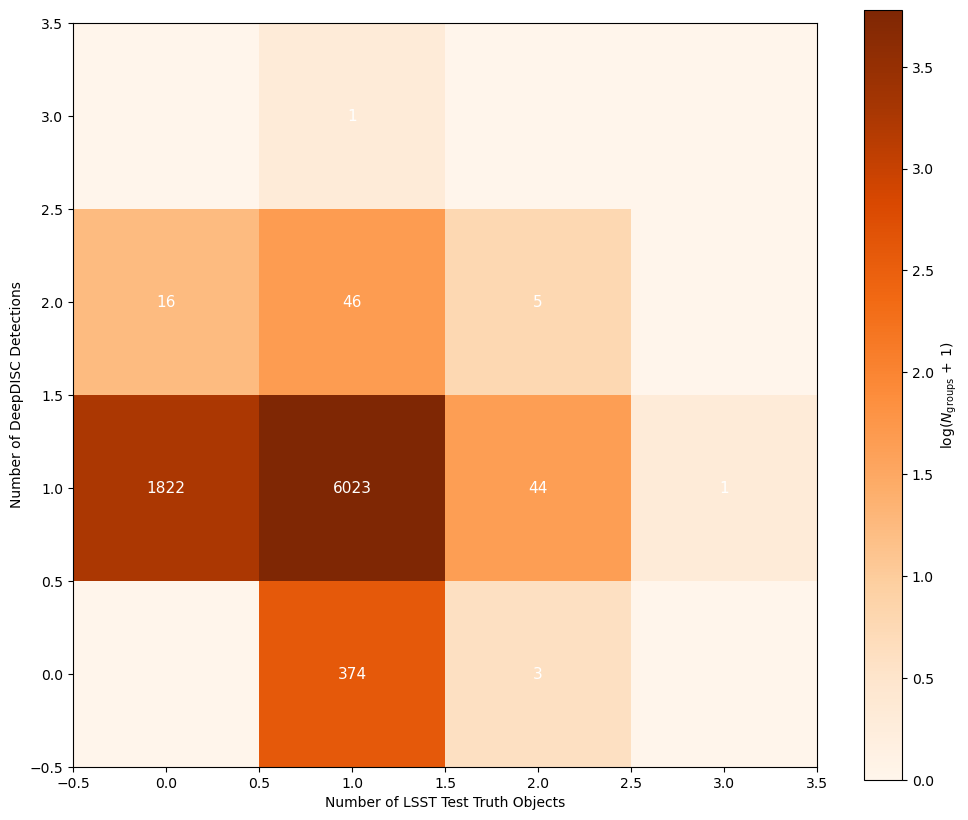

In [114]:
plot_matches(dd_det_lsst_truth05_rl, x_axis_name='lsst_truth', xlabel='LSST Test Truth Objects', ylabel='DeepDISC Detections')

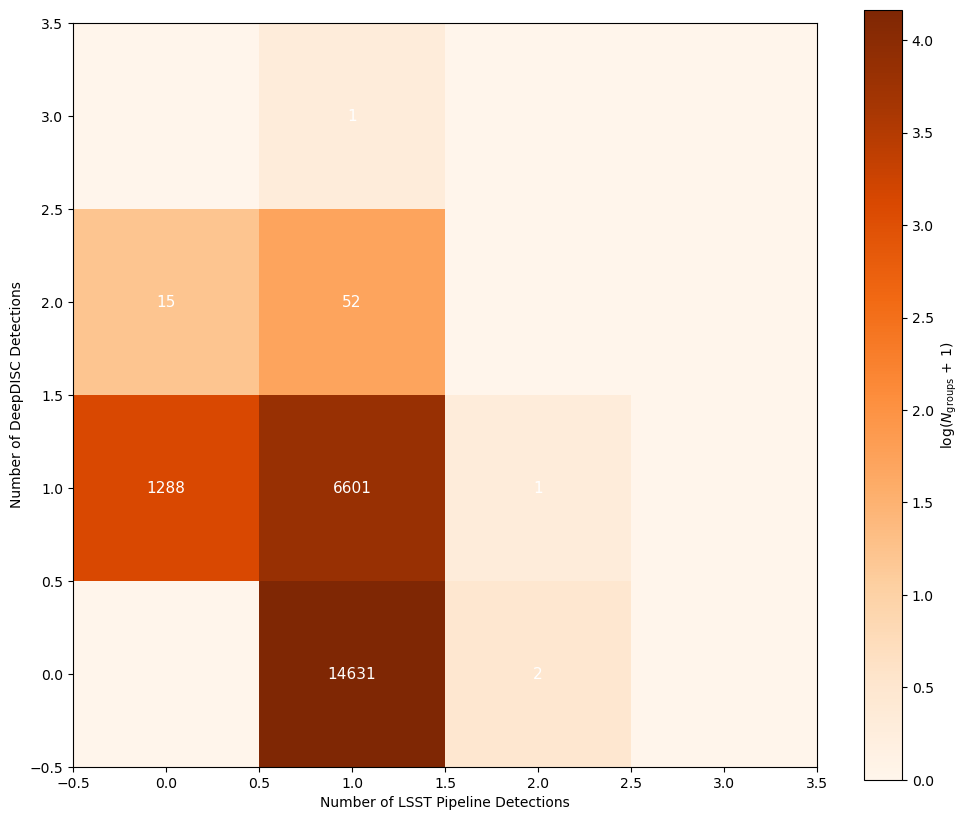

In [61]:
plot_matches(dd_det_lsst_det05_rl, x_axis_name='lsst_det', xlabel='LSST Pipeline Detections', ylabel='DeepDISC Detections')

### Script - All Together with FOF Plots separated by Mag

Overall Truth Catalog Cut Used: mag_i < 26.42

Loading data...
Data loaded successfully.

=== Processing LSST Only Run ===

--- Running Comparison for LSST Only: 18.0 <= mag_i < 22.0 ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


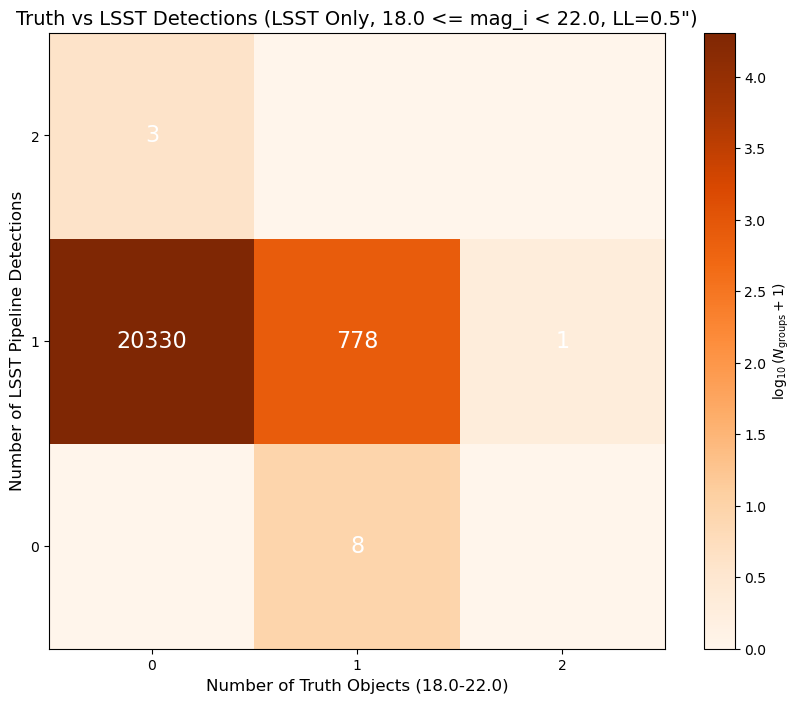

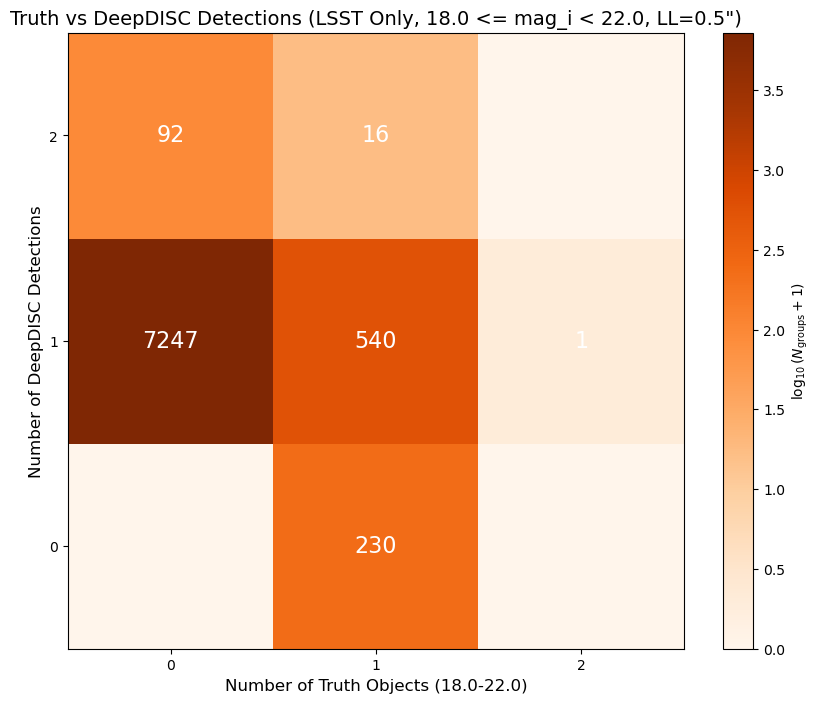


--- Running Comparison for LSST Only: 22.0 <= mag_i < 24.0 ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


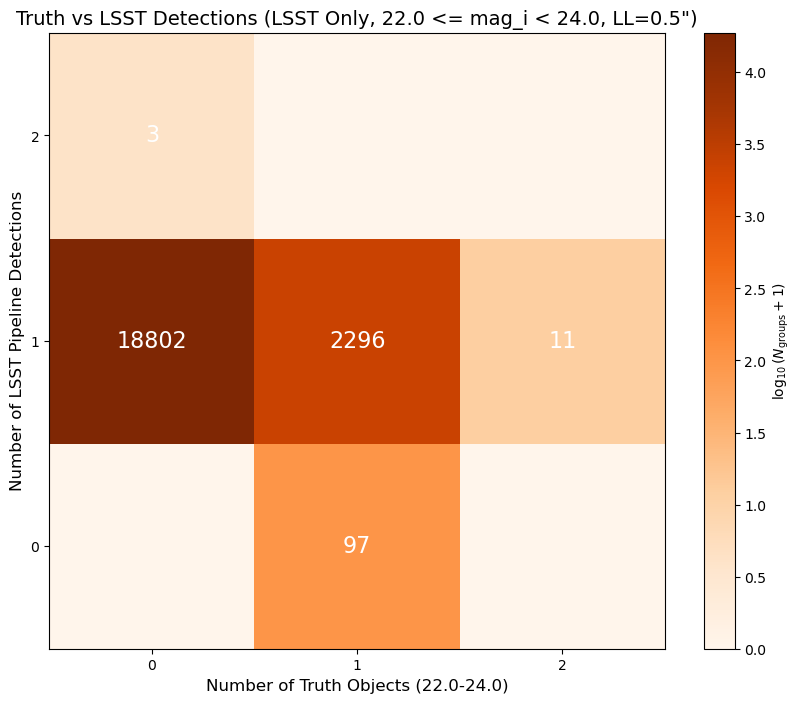

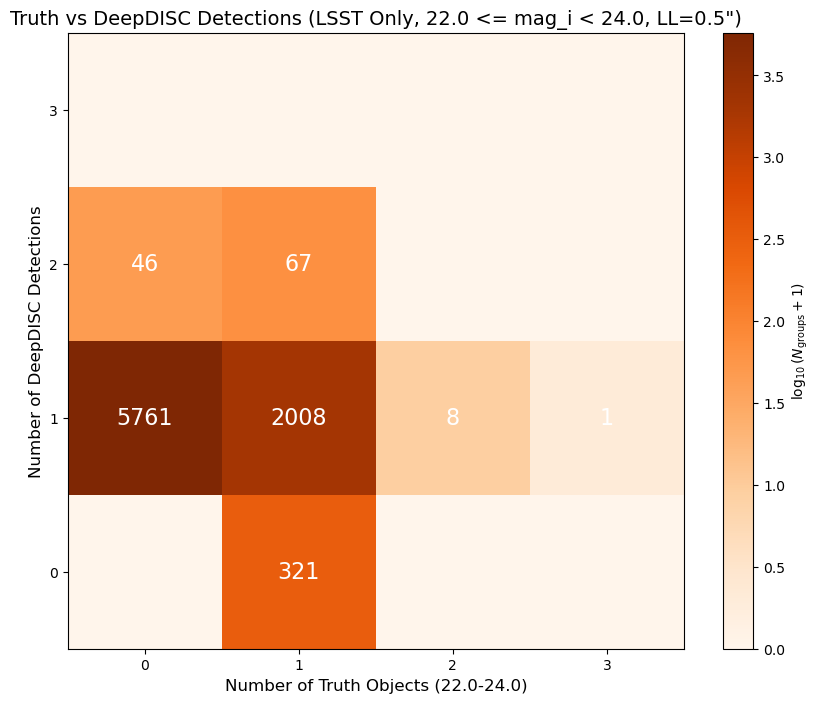


--- Running Comparison for LSST Only: 24.0 <= mag_i < 25.5 ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


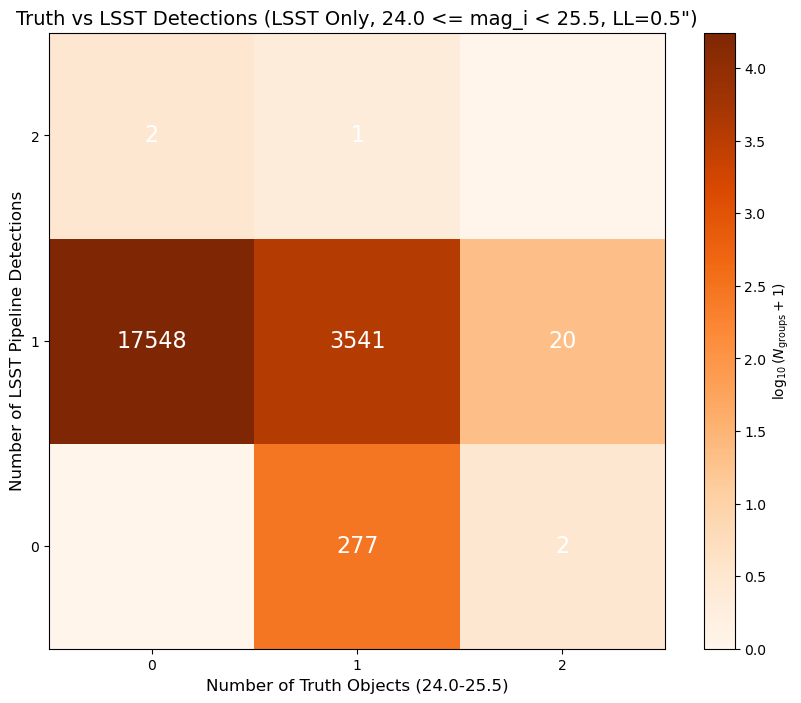

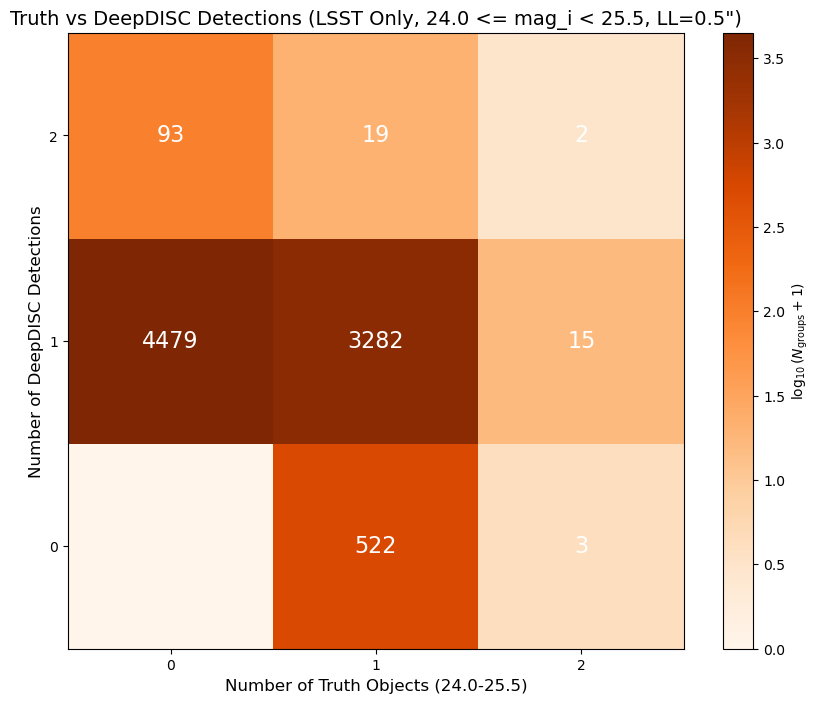


--- Running Comparison for LSST Only: 25.5 <= mag_i < 26.4 ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


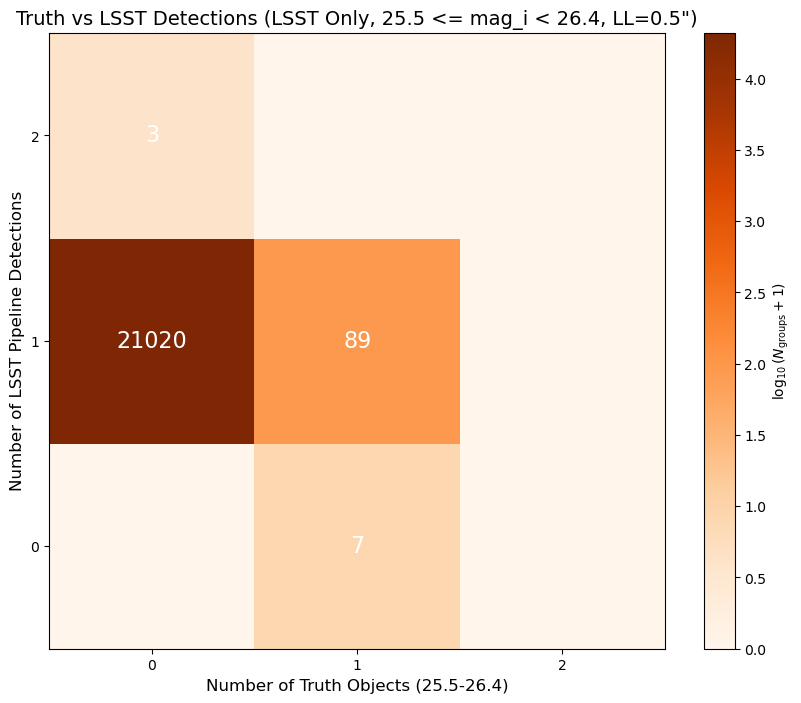

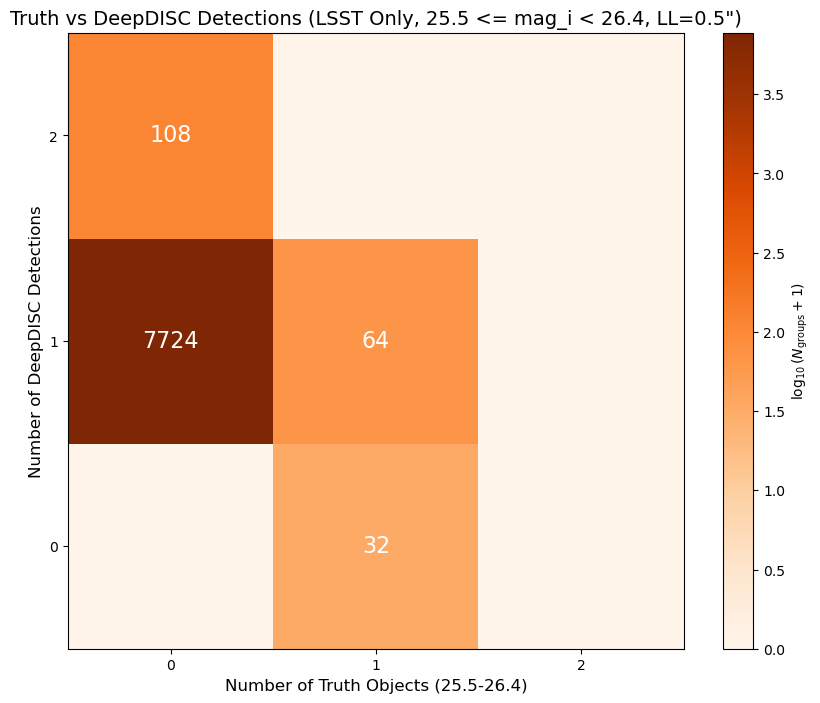


=== Processing LSST + Roman Run ===

--- Running Comparison for LSST + Roman: 18.0 <= mag_i < 22.0 ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


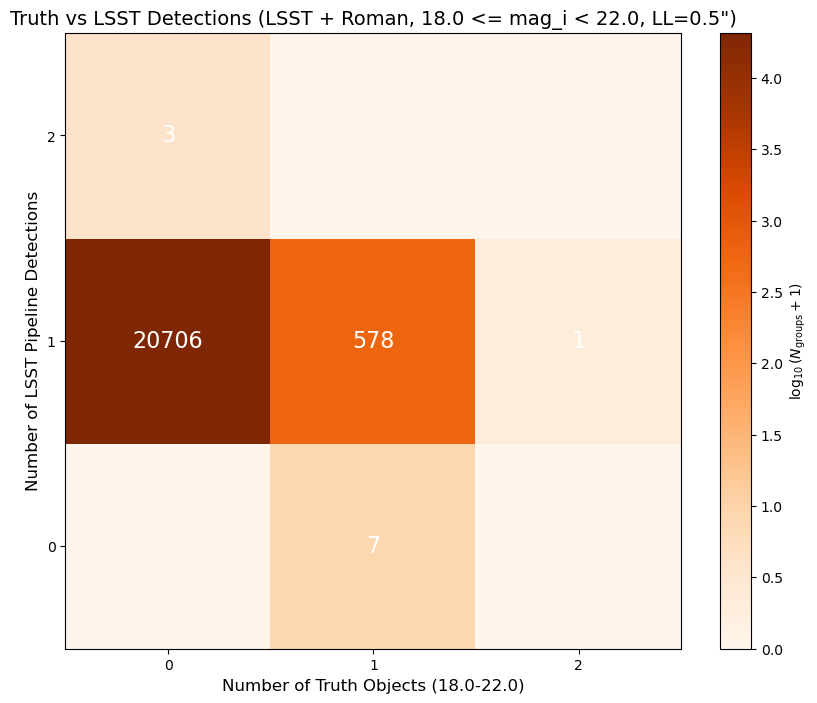

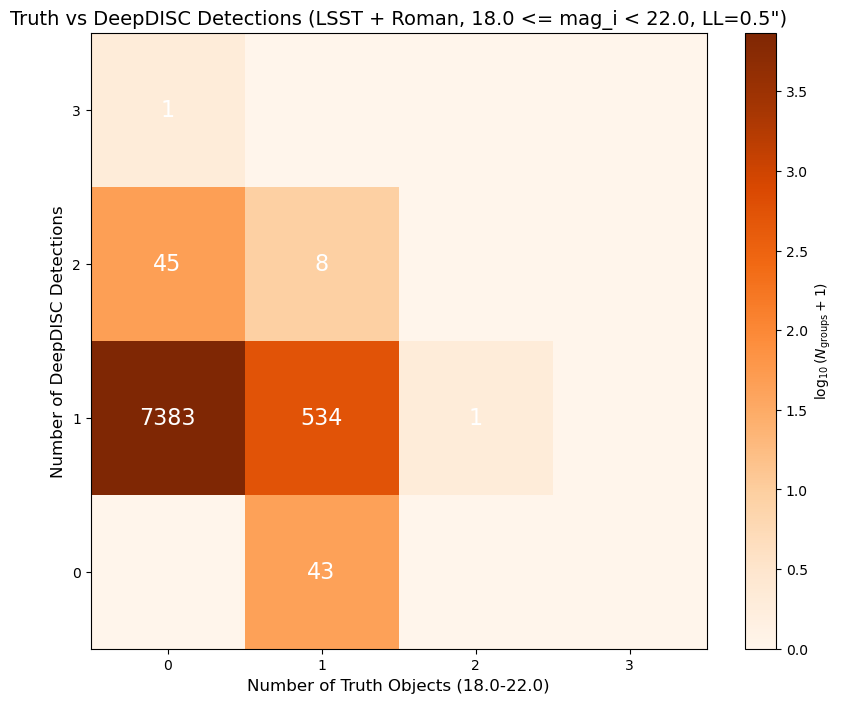


--- Running Comparison for LSST + Roman: 22.0 <= mag_i < 24.0 ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


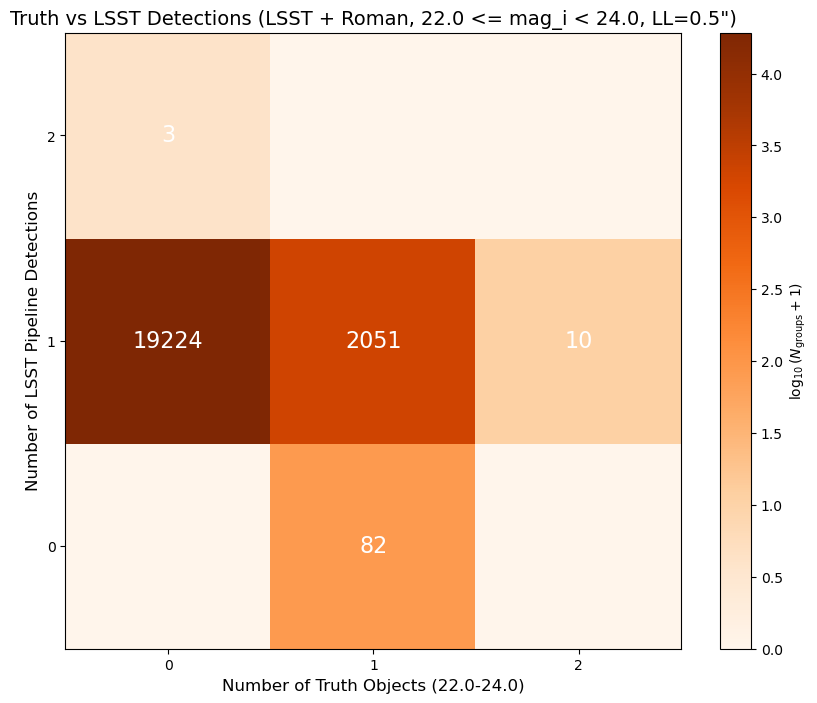

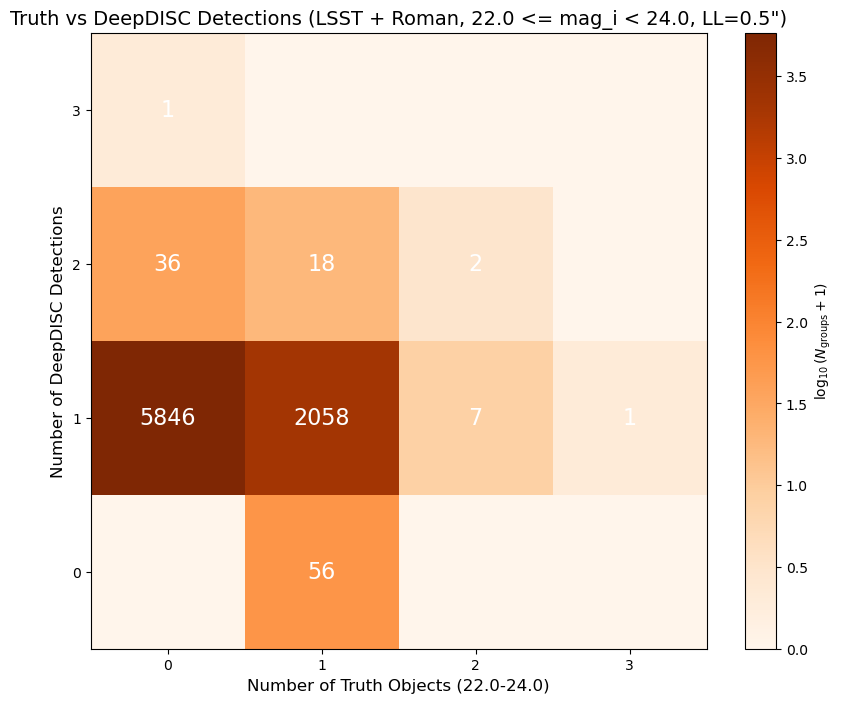


--- Running Comparison for LSST + Roman: 24.0 <= mag_i < 25.5 ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


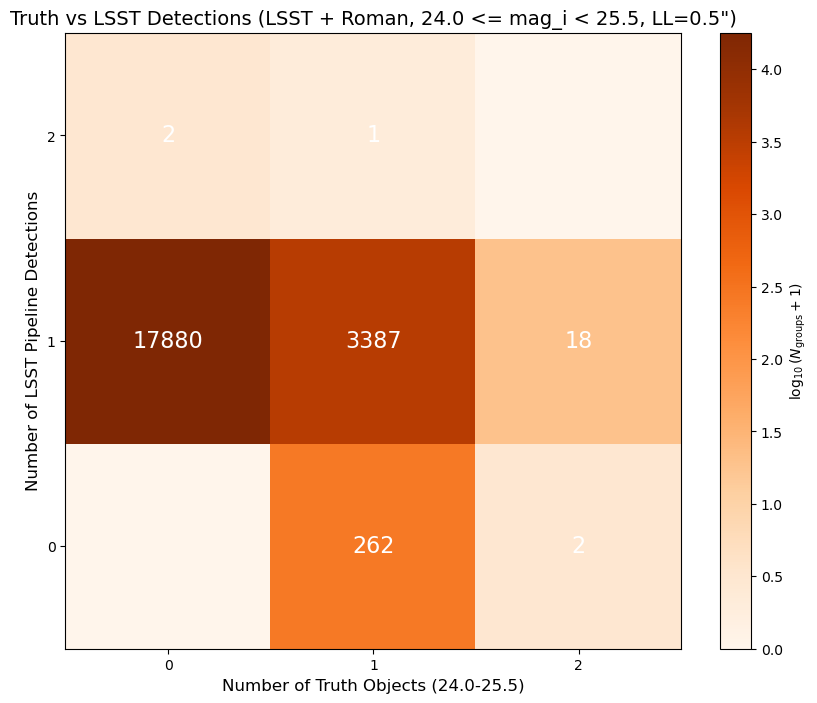

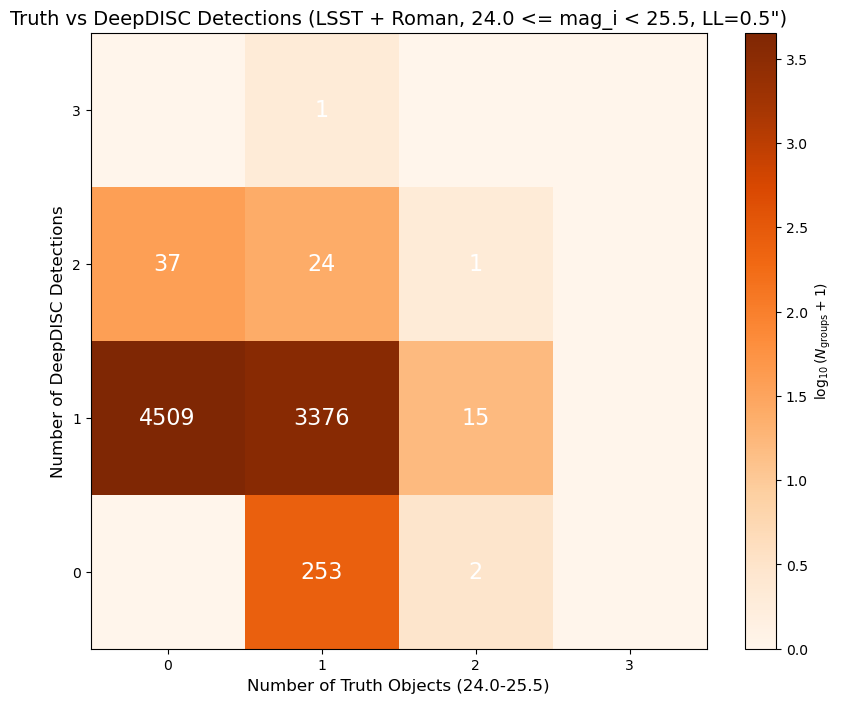


--- Running Comparison for LSST + Roman: 25.5 <= mag_i < 26.4 ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


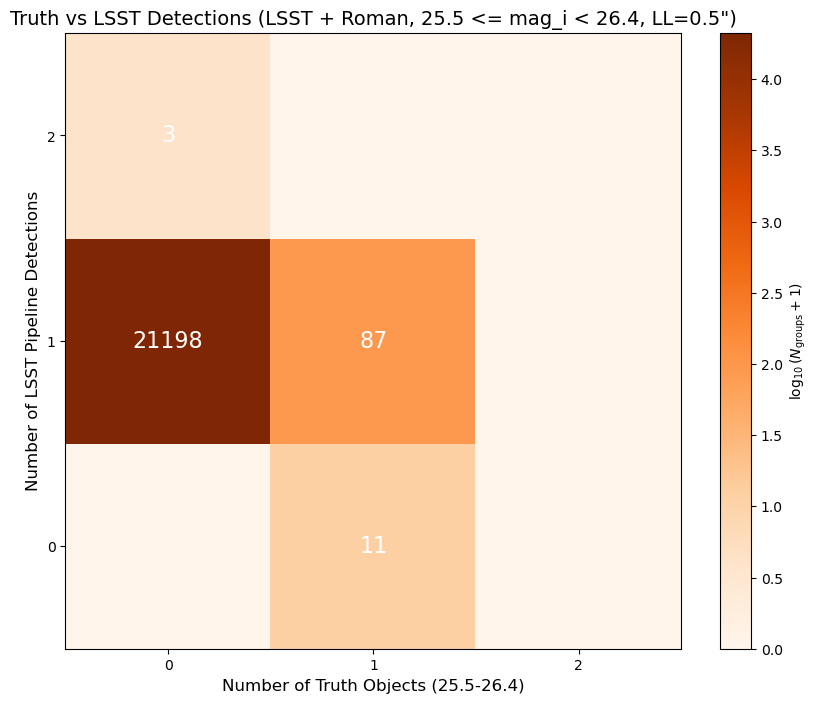

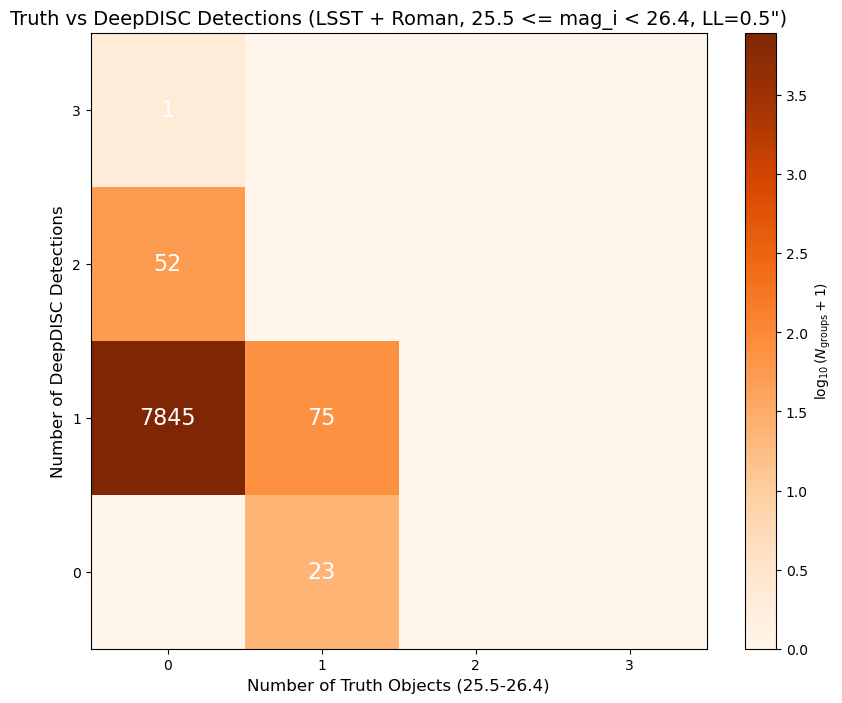


=== Processing LSST Only Run - All Magnitudes ===

--- Running Comparison for LSST Only - All Magnitudes: All Magnitudes ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


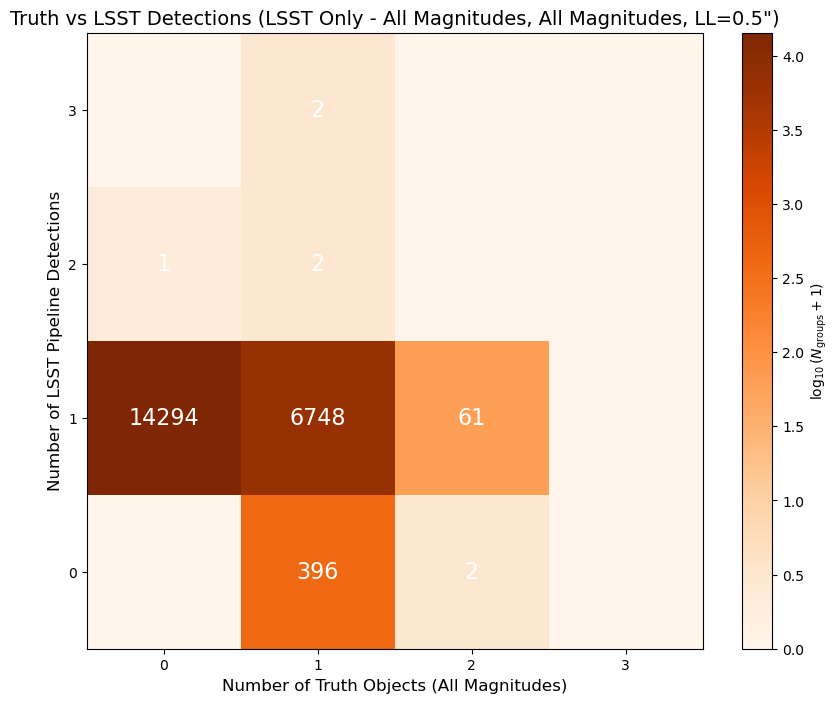

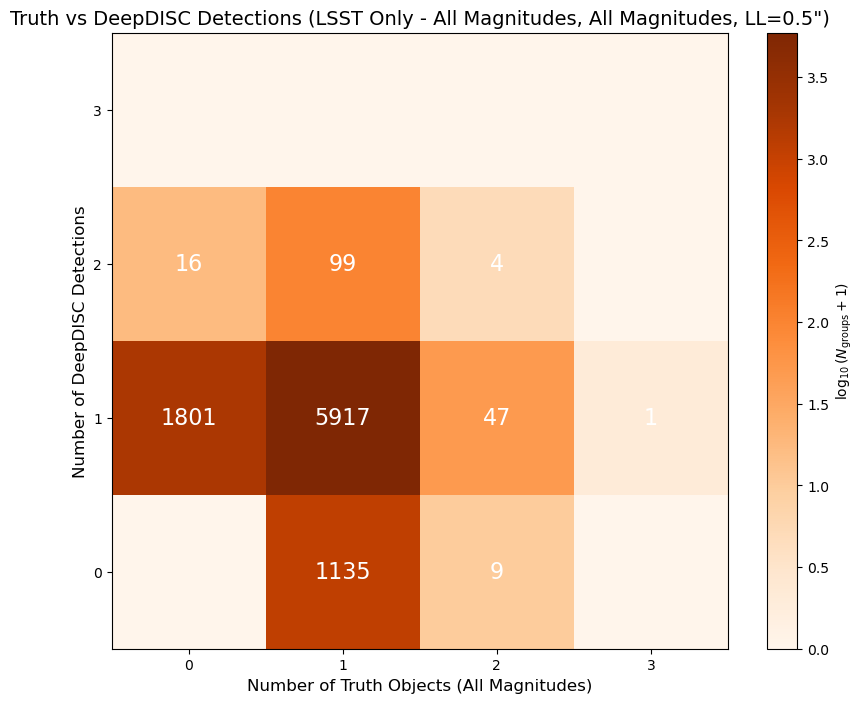


=== Processing LSST + Roman Run - All Magnitudes ===

--- Running Comparison for LSST + Roman - All Magnitudes: All Magnitudes ---
Matching truth vs lsst_det...
Matching truth vs dd_det...


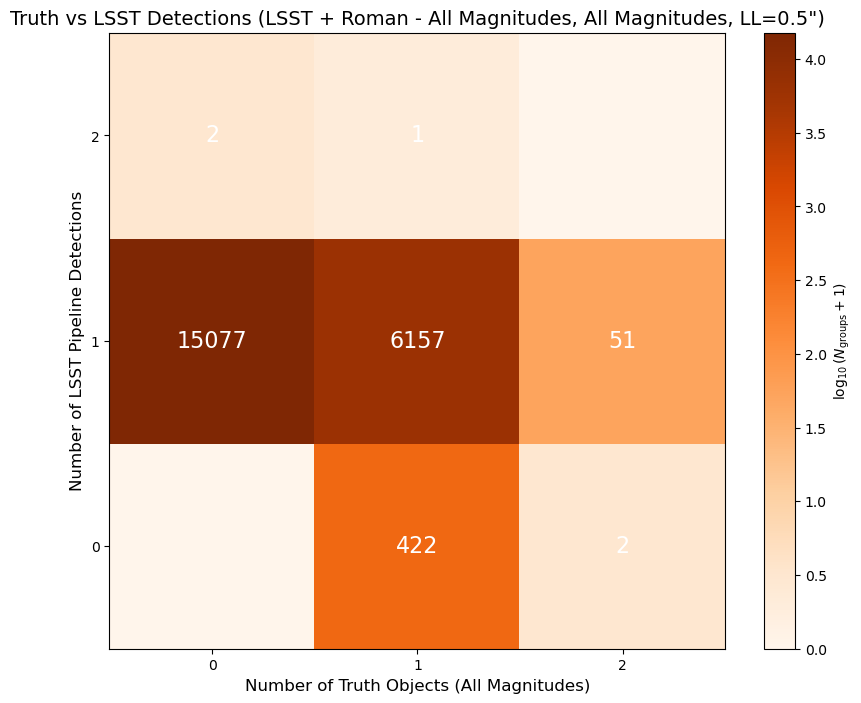

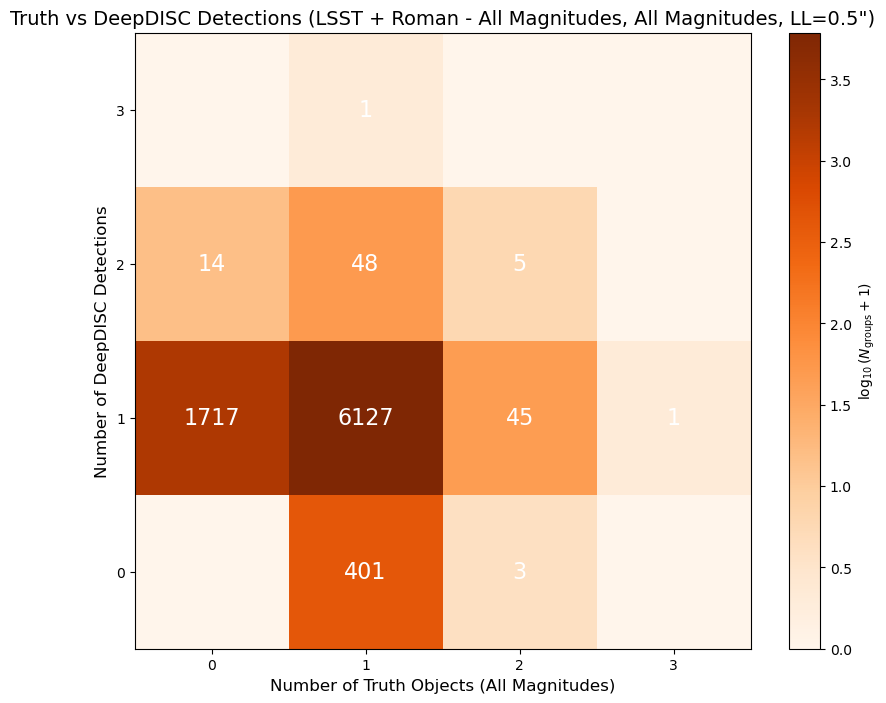


Analysis complete.


In [25]:
import FoFCatalogMatching
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column
from astropy.nddata import Cutout2D
import warnings


# --- Config ---
MAG_COL = 'mag_i'
BASELINE_MAG_5SIGMA_10YR_I = 26.8
YEARS = 5
RUN_DIR_LSST = 'run5_sm_dlvl5'
RUN_DIR_BOTH = 'run5_ups_roman_dlvl5'
# linking length for FoF matching (in arcseconds)
LINKING_LENGTH_ARCSEC = 0.5

# MAG_BINS = [(18, 22), (22, 24), (24, 25.5), (25.5, 26.5)]
MAG_BINS = [(18, 22), (22, 24), (24, 25.5), (25.5, truth_mag_limit)]
PLOT_TEXT_FONTSIZE = 16 
PLOT_MIN_TEXT_FONTSIZE = 6

# Helper Functions

# same for all SNR levels
def calculate_truth_mag_limit(baseline_mag_5sigma_10yr, years):
    """
    Calculate truth catalog magnitude cut at Rubin's nominal 5sigma depth adjusted 
    for the specified number of observation years.
    
    This cut is intended to be used consistently for defining the faint 
    limit of the truth sample for analysis (e.g., completeness), 
    including FOF matching.
    
    Parameters:
    baseline_mag_5sigma_10yr (float): 10-year 5σ depth (e.g., 26.8 for i-band)
    years (float): Analysis time baseline in years
    
    Returns:
    float: Magnitude cut for truth catalog
    """
    time_factor = np.sqrt(10 / years) # represents (sqrt(N_obs_10yr) / sqrt(N_obs_years))
    # delta_mag = 2.5 * log10(SNR_ratio)
    # SNR_ratio corresponds to 1 / time_factor for reaching the *same* SNR
    m_cut = baseline_mag_5sigma_10yr - 2.5 * np.log10(time_factor)
    return m_cut

def find_matches(cat_a, cat_b, cat_a_name, cat_b_name, linking_length=1.0, max_friends=1):
    """
    Find matches between two catalogs using Friends-of-Friends package 

    Parameters:
    -----------
    cat_a, cat_b : astropy.table.Table
        The two catalogs to match. MUST contain 'ra' and 'dec' columns
    cat_a_name, cat_b_name : str
        Names for the two catalogs
    linking_length : float, optional
        The linking length in arcseconds. Default is 1.0
    max_friends : int or None, optional
        The maximum number of friends allowed initially linked to a single point
        Use None for no limit. Default is 1 (restrictive initial linking)

    Returns:
    --------
    astropy.table.Table
        Matched catalog with group IDs. Returns None if matching fails.
    """
    # inputs need to be Astropy Tables
    if not isinstance(cat_a, Table):
        raise TypeError(f"cat_a must be an astropy Table, got {type(cat_a)}")
    if not isinstance(cat_b, Table):
        raise TypeError(f"cat_b must be an astropy Table, got {type(cat_b)}")

    # need ra and dec cols
    if 'ra' not in cat_a.colnames or 'dec' not in cat_a.colnames:
        raise ValueError(f"cat_a ('{cat_a_name}') must contain 'ra' and 'dec' columns.")
    if 'ra' not in cat_b.colnames or 'dec' not in cat_b.colnames:
        raise ValueError(f"cat_b ('{cat_b_name}') must contain 'ra' and 'dec' columns.")

    # Check for empty catalogs
    if len(cat_a) == 0:
        print(f"Warning: Catalog '{cat_a_name}' is empty. Skipping match.")
        return None
    if len(cat_b) == 0:
        print(f"Warning: Catalog '{cat_b_name}' is empty. Skipping match.")
        return None

    linking_lengths_dict = {linking_length: max_friends}

    try:
        matched_results = FoFCatalogMatching.match(
            catalog_dict={cat_a_name: cat_a, cat_b_name: cat_b},
            linking_lengths=linking_lengths_dict
        )
        return matched_results
    except Exception as e:
        print(f"Error during FoF matching between {cat_a_name} and {cat_b_name}: {e}")
        return None


def get_catalog_subset(catalog_df, mag_col=MAG_COL, mag_range=None):
    """
    Filters a catalog DataFrame by magnitude and selects RA, Dec

    Parameters:
    -----------
    catalog_df : pandas.DataFrame
        Input catalog DataFrame. Must contain 'ra', 'dec', and mag_col
    mag_col : str
        Name of the magnitude column to filter on
    mag_range : tuple (min_mag, max_mag) or None
        Magnitude range to select. If None, no magnitude cut is applied

    Returns:
    --------
    astropy.table.Table or None
        Table containing 'ra' and 'dec' for the filtered objects, or None if empty.
    """
    if not isinstance(catalog_df, pd.DataFrame):
        if isinstance(catalog_df, Table):
            catalog_df = catalog_df.to_pandas()
        else:
            raise TypeError("Input catalog must be a pandas DataFrame or Astropy Table.")

    filtered_df = catalog_df.copy()

    if mag_range is not None:
        min_mag, max_mag = mag_range
        if mag_col not in filtered_df.columns:
              print(f"Warning: Magnitude column '{mag_col}' not found in catalog. Cannot apply mag filter.")
        else:
            filtered_df = filtered_df[(filtered_df[mag_col] >= min_mag) & (filtered_df[mag_col] < max_mag)]

    if 'ra' not in filtered_df.columns or 'dec' not in filtered_df.columns:
        raise ValueError("Input catalog must contain 'ra' and 'dec' columns.")
    ra_dec_df = filtered_df[['ra', 'dec']]

    if ra_dec_df.empty:
        return None

    return Table.from_pandas(ra_dec_df)

# Adapted from https://nbviewer.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_fof.nbconvert.ipynb
def autofit_text(ax, text, x, y, fontsize=PLOT_TEXT_FONTSIZE, min_fontsize=PLOT_MIN_TEXT_FONTSIZE):
    """
    Places text on axes, attempting to autofit by reducing font size

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    text : str
        The text string to plot.
    x, y : float
        Coordinates for the text center.
    fontsize : int
        Initial font size.
    min_fontsize : int
        Minimum font size to try.
    """
    current_fontsize = fontsize
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="none", alpha=0) # Transparent background

    while current_fontsize >= min_fontsize:
        t = ax.text(x, y, text, ha='center', va='center', fontsize=current_fontsize,
                    color='white', bbox=bbox_props)
        try:
            r = ax.figure.canvas.get_renderer()
            bb = t.get_window_extent(renderer=r).transformed(ax.transData.inverted())
            # if text fits within the cell (approximate 1x1 data units)
            if bb.width < 0.95 and bb.height < 0.95: 
                return # everything fits
        except Exception as e:
            return

        t.remove() # remove text if it didn't fit
        current_fontsize -= 1

    # if loop finishes, text didn't fit even at the smallest size
    ax.text(x, y, '.', ha='center', va='center', fontsize=min_fontsize, color='black') # just place a dot


def plot_matches(results, x_axis_cat_name, y_axis_cat_name, xlabel, ylabel, title):
    """
    Generates a 2D histogram plot of FoF matching results.

    Parameters:
    -----------
    results : astropy.table.Table
        The output table from find_matches
    x_axis_cat_name, y_axis_cat_name : str
        The names used for catalog_key in the results table
    xlabel, ylabel : str
        Labels for the x and y axes of the plot
    title : str
        Title for the plot
    """
    if results is None or len(results) == 0:
        print(f"Skipping plot generation: No match results provided for '{title}'.")
        return


    cat_a_mask = results['catalog_key'] == x_axis_cat_name
    cat_b_mask = results['catalog_key'] == y_axis_cat_name

    if not np.any(cat_a_mask) or not np.any(cat_b_mask):
        print(f"Warning: One or both catalogs ({x_axis_cat_name}, {y_axis_cat_name}) have no members in the FoF result groups for '{title}'. Cannot generate plots.")
        return

    # counting occurrences of each group ID for each cat
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)

    # find max num of objects per group for plot limits
    # Add 1 because counts are 0-based, +1 for the upper limit of extent
    n_max_a = n_a.max() + 1
    n_max_b = n_b.max() + 1
    # combined max for a square plot,
    n_plot_max = max(n_max_a, n_max_b, 3) # 3 ensures plot shows at least up to 2x2

    # 2D histogram: count groups with (n_a, n_b) members
    # n_b * n_plot_max + n_a as a unique idx for each (n_a, n_b) pair
    hist_2d = np.bincount(n_b * n_plot_max + n_a, minlength=n_plot_max*n_plot_max).reshape(n_plot_max, n_plot_max)

    plt.figure(figsize=(10, 8))
    # adding 1 to avoid log(0)
    img = plt.imshow(np.log10(hist_2d + 1),
                     extent=(-0.5, n_plot_max - 0.5, -0.5, n_plot_max - 0.5),
                     origin='lower', cmap='Oranges', aspect='equal')

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, wrap=True)

    # ticks only to ints
    tick_positions = np.arange(0, n_plot_max)
    plt.xticks(tick_positions)
    plt.yticks(tick_positions)
    axis_limit = min(n_plot_max, 10) # limit display to 10x10 for readability
    plt.xlim(-0.5, axis_limit -0.5)
    plt.ylim(-0.5, axis_limit -0.5)

    plt.colorbar(img, label=r'$\log_{10}(N_{\rm groups} + 1)$')

    # counts text
    ax = plt.gca()
    for i in range(n_plot_max): # iter up to n_plot_max for data
        for j in range(n_plot_max):
            if i < axis_limit and j < axis_limit:
                count = hist_2d[i, j]
                if count > 0:
                    text = str(count)
                    autofit_text(ax, text, j, i, fontsize=PLOT_TEXT_FONTSIZE, min_fontsize=PLOT_MIN_TEXT_FONTSIZE)

    plt.grid(False)


def run_comparison(truth_df, lsst_det_df, dd_det_df, mag_range, linking_length,
                   run_label, truth_mag_col=MAG_COL):
    """
    Runs FoF matching and generates plots for a specific mag range.

    Parameters:
    -----------
    truth_df : pandas.DataFrame
        The full truth catalog DataFrame.
    lsst_det_df : pandas.DataFrame
        The full LSST detection catalog DataFrame.
    dd_det_df : pandas.DataFrame
        The full DeepDISC detection catalog DataFrame.
    mag_range : tuple (min_mag, max_mag)
        mag range to analyze.
    linking_length : float
        Linking length in arcseconds for FoF.
    run_label : str
        Label for the dataset run (e.g., 'LSST Only', 'LSST+Roman').
    truth_mag_col : str
        Name of the magnitude column in the truth catalog.
    """
    min_mag, max_mag = mag_range
    mag_range_str = f"{min_mag:.1f} <= {truth_mag_col} < {max_mag:.1f}"
    print(f"\n--- Running Comparison for {run_label}: {mag_range_str} ---")

    # --- prep cats for this mag range ---
    truth_subset_table = get_catalog_subset(truth_df, mag_col=truth_mag_col, mag_range=mag_range)

    # RA/Dec tables for det cats
    lsst_det_table = get_catalog_subset(lsst_det_df, mag_range=None) # Use all detections
    dd_det_table = get_catalog_subset(dd_det_df, mag_range=None)   # Use all detections

    if truth_subset_table is None or len(truth_subset_table) == 0:
        print(f"No truth objects found in magnitude range {mag_range_str}. Skipping comparisons.")
        return
    if lsst_det_table is None or len(lsst_det_table) == 0:
        print(f"LSST detection catalog is empty. Skipping comparisons involving it.")
    if dd_det_table is None or len(dd_det_table) == 0:
        print(f"DeepDISC detection catalog is empty. Skipping comparisons involving it.")
    
    # --- Matching ---
    cat_a_name_truth = 'truth'
    cat_b_name_lsst = 'lsst_det'
    cat_b_name_dd = 'dd_det'

    # Truth vs LSST Detections
    print(f"Matching {cat_a_name_truth} vs {cat_b_name_lsst}...")
    results_truth_lsst = None
    if lsst_det_table is not None:
         results_truth_lsst = find_matches(
             cat_a=truth_subset_table, cat_b=lsst_det_table,
             cat_a_name=cat_a_name_truth, cat_b_name=cat_b_name_lsst,
             linking_length=linking_length
         )

    # Truth vs DeepDISC Detections
    print(f"Matching {cat_a_name_truth} vs {cat_b_name_dd}...")
    results_truth_dd = None
    if dd_det_table is not None:
        results_truth_dd = find_matches(
            cat_a=truth_subset_table, cat_b=dd_det_table,
            cat_a_name=cat_a_name_truth, cat_b_name=cat_b_name_dd,
            linking_length=linking_length
        )

    # LSST Detections vs DeepDISC Detections
    # print(f"Matching {cat_b_name_lsst} vs {cat_b_name_dd}...")
    # results_lsst_dd = None
    # if lsst_det_table is not None and dd_det_table is not None:
    #     results_lsst_dd = find_matches(
    #         cat_a=lsst_det_table, cat_b=dd_det_table,
    #         cat_a_name=cat_b_name_lsst, cat_b_name=cat_b_name_dd,
    #         linking_length=linking_length
    #     )

    # --- Plots ---
    plot_title_suffix = f"({run_label}, {mag_range_str}, LL={linking_length}\")"

    # Truth vs LSST
    if results_truth_lsst is not None:
        plot_matches(results_truth_lsst,
                     x_axis_cat_name=cat_a_name_truth, y_axis_cat_name=cat_b_name_lsst,
                     xlabel=f'Number of Truth Objects ({min_mag:.1f}-{max_mag:.1f})',
                     ylabel='Number of LSST Pipeline Detections',
                     title=f'Truth vs LSST Detections {plot_title_suffix}')
    else:
        plot_matches(None, '', '',
                  xlabel=f'Number of Truth Objects ({min_mag:.1f}-{max_mag:.1f})',
                  ylabel='Number of LSST Pipeline Detections',
                  title=f'Truth vs LSST Detections {plot_title_suffix}')


    # Truth vs DeepDISC
    if results_truth_dd is not None:
        plot_matches(results_truth_dd,
                     x_axis_cat_name=cat_a_name_truth, y_axis_cat_name=cat_b_name_dd,
                     xlabel=f'Number of Truth Objects ({min_mag:.1f}-{max_mag:.1f})',
                     ylabel='Number of DeepDISC Detections',
                     title=f'Truth vs DeepDISC Detections {plot_title_suffix}')
    else:
        plot_matches(None, '', '',
                  xlabel=f'Number of Truth Objects ({min_mag:.1f}-{max_mag:.1f})',
                  ylabel='Number of DeepDISC Detections',
                  title=f'Truth vs DeepDISC Detections {plot_title_suffix}')

    # LSST vs DeepDISC
    # if results_lsst_dd is not None:
    #     plot_matches(results_lsst_dd,
    #                  x_axis_cat_name=cat_b_name_lsst, y_axis_cat_name=cat_b_name_dd,
    #                  xlabel='Number of LSST Pipeline Detections',
    #                  ylabel='Number of DeepDISC Detections',
    #                  title=f'LSST vs DeepDISC Detections {plot_title_suffix}')
    # else:
    #      plot_matches(None, '', '',
    #                   xlabel='Number of LSST Pipeline Detections',
    #                   ylabel='Number of DeepDISC Detections',
    #                   title=f'LSST vs DeepDISC Detections {plot_title_suffix}')

    plt.show()

def run_comparison_all_magnitudes(truth_df, lsst_det_df, dd_det_df, linking_length,
                   run_label, truth_mag_col=MAG_COL):
    """
    Runs FoF matching and generates plots for all magnitudes (no mag cut).

    Parameters:
    -----------
    truth_df : pandas.DataFrame
        The full truth catalog DataFrame.
    lsst_det_df : pandas.DataFrame
        The full LSST detection catalog DataFrame.
    dd_det_df : pandas.DataFrame
        The full DeepDISC detection catalog DataFrame.
    linking_length : float
        Linking length in arcseconds for FoF.
    run_label : str
        Label for the dataset run (e.g., 'LSST Only', 'LSST+Roman').
    truth_mag_col : str
        Name of the magnitude column in the truth catalog.
    """
    mag_range_str = "All Magnitudes"
    print(f"\n--- Running Comparison for {run_label}: {mag_range_str} ---")

    truth_subset_table = get_catalog_subset(truth_df, mag_col=truth_mag_col, mag_range=None)
    lsst_det_table = get_catalog_subset(lsst_det_df, mag_range=None)
    dd_det_table = get_catalog_subset(dd_det_df, mag_range=None)

    if truth_subset_table is None or len(truth_subset_table) == 0:
        print(f"No truth objects found. Skipping comparisons.")
        return
    if lsst_det_table is None or len(lsst_det_table) == 0:
        print(f"LSST detection catalog is empty. Skipping comparisons involving it.")
    if dd_det_table is None or len(dd_det_table) == 0:
        print(f"DeepDISC detection catalog is empty. Skipping comparisons involving it.")

    # --- Matching ---
    cat_a_name_truth = 'truth'
    cat_b_name_lsst = 'lsst_det'
    cat_b_name_dd = 'dd_det'

    # Truth vs LSST Detections
    print(f"Matching {cat_a_name_truth} vs {cat_b_name_lsst}...")
    results_truth_lsst = None
    if lsst_det_table is not None:
         results_truth_lsst = find_matches(
             cat_a=truth_subset_table, cat_b=lsst_det_table,
             cat_a_name=cat_a_name_truth, cat_b_name=cat_b_name_lsst,
             linking_length=linking_length
         )

    # Truth vs DeepDISC Detections
    print(f"Matching {cat_a_name_truth} vs {cat_b_name_dd}...")
    results_truth_dd = None
    if dd_det_table is not None:
        results_truth_dd = find_matches(
            cat_a=truth_subset_table, cat_b=dd_det_table,
            cat_a_name=cat_a_name_truth, cat_b_name=cat_b_name_dd,
            linking_length=linking_length
        )

    # --- Plots ---
    plot_title_suffix = f"({run_label}, {mag_range_str}, LL={linking_length}\")"

    # Truth vs LSST
    if results_truth_lsst is not None:
        plot_matches(results_truth_lsst,
                     x_axis_cat_name=cat_a_name_truth, y_axis_cat_name=cat_b_name_lsst,
                     xlabel='Number of Truth Objects (All Magnitudes)',
                     ylabel='Number of LSST Pipeline Detections',
                     title=f'Truth vs LSST Detections {plot_title_suffix}')
    else:
         plot_matches(None, '', '',
                      xlabel='Number of Truth Objects (All Magnitudes)',
                      ylabel='Number of LSST Pipeline Detections',
                      title=f'Truth vs LSST Detections {plot_title_suffix}')

    # Truth vs DeepDISC
    if results_truth_dd is not None:
        plot_matches(results_truth_dd,
                     x_axis_cat_name=cat_a_name_truth, y_axis_cat_name=cat_b_name_dd,
                     xlabel='Number of Truth Objects (All Magnitudes)',
                     ylabel='Number of DeepDISC Detections',
                     title=f'Truth vs DeepDISC Detections {plot_title_suffix}')
    else:
         plot_matches(None, '', '',
                      xlabel='Number of Truth Objects (All Magnitudes)',
                      ylabel='Number of DeepDISC Detections',
                      title=f'Truth vs DeepDISC Detections {plot_title_suffix}')

    plt.show()


# ------ MAIN -----------

# overall truth mag limit
truth_mag_limit = calculate_truth_mag_limit(BASELINE_MAG_5SIGMA_10YR_I, YEARS)
print(f"Overall Truth Catalog Cut Used: {MAG_COL} < {truth_mag_limit:.2f}")

if MAG_BINS[-1][1] > truth_mag_limit:
    print(f"Adjusting last mag bin upper limit to {truth_mag_limit:.2f}")
    MAG_BINS[-1] = (MAG_BINS[-1][0], truth_mag_limit)

if MAG_BINS[-1][1] < truth_mag_limit and MAG_BINS[-1][0] < truth_mag_limit:
    new_bin_start = MAG_BINS[-1][1]
    if new_bin_start < truth_mag_limit:
        print(f"Adding final mag bin: ({new_bin_start:.2f}, {truth_mag_limit:.2f})")
        MAG_BINS.append((new_bin_start, truth_mag_limit))


# loading in the data
print("\nLoading data...")
try:
    # LSST run
    lsst_test_det_df = pd.read_json(f'./lsst_runs/{RUN_DIR_LSST}/test_lsst_det_fof_info.json')
    dd_test_det_df = pd.read_json(f'./lsst_runs/{RUN_DIR_LSST}/pred_s0.3_n0.5_radec.json')
    truth_df_lsst = pd.read_json(f'./lsst_runs/{RUN_DIR_LSST}/test_truth11_cat.json')

    # LSST + Roman run
    lsst_test_det_df_ups = pd.read_json(f'./lsst_runs/{RUN_DIR_BOTH}/test_lsst_det_fof_info.json')
    dd_test_det_df_ups = pd.read_json(f'./lsst_runs/{RUN_DIR_BOTH}/pred_s0.3_n0.5_radec.json')
    truth_df_both = pd.read_json(f'./lsst_runs/{RUN_DIR_BOTH}/test_truth11_cat.json')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"\nError loading data file: {e}")
    print("Please ensure the JSON files exist in the specified paths:")
    print(f"  - ./lsst_runs/{RUN_DIR_LSST}/")
    print(f"  - ./lsst_runs/{RUN_DIR_BOTH}/")
    raise

# --- Plots for each mag bin ---

# LSST Only
print("\n=== Processing LSST Only Run ===")
for mag_bin in MAG_BINS:
    run_comparison(truth_df=truth_df_lsst,
                   lsst_det_df=lsst_test_det_df,
                   dd_det_df=dd_test_det_df,
                   mag_range=mag_bin,
                   linking_length=LINKING_LENGTH_ARCSEC,
                   run_label='LSST Only',
                   truth_mag_col=MAG_COL)

# LSST + Roman
print("\n=== Processing LSST + Roman Run ===")
for mag_bin in MAG_BINS:
    run_comparison(truth_df=truth_df_both,
                   lsst_det_df=lsst_test_det_df_ups,
                   dd_det_df=dd_test_det_df_ups,
                   mag_range=mag_bin,
                   linking_length=LINKING_LENGTH_ARCSEC,
                   run_label='LSST + Roman',
                   truth_mag_col=MAG_COL)

# --- Now plots for all mags ---

# LSST Only
print("\n=== Processing LSST Only Run - All Magnitudes ===")
run_comparison_all_magnitudes(truth_df=truth_df_lsst,
                   lsst_det_df=lsst_test_det_df,
                   dd_det_df=dd_test_det_df,
                   linking_length=LINKING_LENGTH_ARCSEC,
                   run_label='LSST Only - All Magnitudes',
                   truth_mag_col=MAG_COL)

# LSST + Roman
print("\n=== Processing LSST + Roman Run - All Magnitudes ===")
run_comparison_all_magnitudes(truth_df=truth_df_both,
                   lsst_det_df=lsst_test_det_df_ups,
                   dd_det_df=dd_test_det_df_ups,
                   linking_length=LINKING_LENGTH_ARCSEC,
                   run_label='LSST + Roman - All Magnitudes',
                   truth_mag_col=MAG_COL)

## Unrecognized Blend Plot

In [108]:
def calculate_blend_fraction(results, x_axis_name, mags, mag_bins):
    # first we need to know which rows are from the x-axis cat (catalog A) and which are from y-axis cat (catalog B)
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    
    # let's go with the convention that we have LSST Det/Truth on the x-axis (cat_a)
    # then the unrecognized blends will be where LSST Det/Truth thought it was one object but DeepDISC detected it as 2
    blend_mask = (n_a == 1) & (n_b > 1) # where 
    # group_ids for LSST objects only
    lsst_group_ids = results['group_id'][cat_a_mask]
    # mask for blended LSST objects
    lsst_blend_mask = np.isin(lsst_group_ids, np.where(blend_mask)[0])
    # now we use this mask to select magnitudes of blended objects
    blend_mags = mags[lsst_blend_mask]
    
    blend_objects_per_bin, _ = np.histogram(blend_mags, bins=mag_bins)
    total_objects_per_bin, _ = np.histogram(mags, bins=mag_bins)
    
    blend_fraction = blend_objects_per_bin / total_objects_per_bin
    
    return blend_fraction

def plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, title, xlabel='i'):
    plt.figure(figsize=(10, 6))
    plt.plot(mag_bins[:-1], blend_fraction_1arcsec, '-', label='Matching 1"')
    plt.plot(mag_bins[:-1], blend_fraction_05arcsec, '-g', label='Matching 0.5"')

    plt.xlabel(f'${xlabel}$ magnitude')
    plt.ylabel('Unrecognized blend fraction')
    plt.title(f'Proportion of Unrecognized Blends to Total Matched Objects - {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)

def calculate_blend_fraction_with_errors(results, x_axis_name, mags, mag_bins):
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    
    blend_mask = (n_a == 1) & (n_b > 1)
    lsst_group_ids = results['group_id'][cat_a_mask]
    lsst_blend_mask = np.isin(lsst_group_ids, np.where(blend_mask)[0])
    blend_mags = mags[lsst_blend_mask]
    
    blend_objects_per_bin, _ = np.histogram(blend_mags, bins=mag_bins)
    total_objects_per_bin, _ = np.histogram(mags, bins=mag_bins)
    
    blend_fraction = blend_objects_per_bin / total_objects_per_bin
    
    # binomial errors
    # (sqrt(p(1-p)/n) where p is blend fraction and n is total number of objects in each bin)
    # bins w/ non-zero total objects
    errors = np.zeros_like(blend_fraction)
    mask = total_objects_per_bin > 0
    errors[mask] = np.sqrt(blend_fraction[mask] * (1 - blend_fraction[mask]) / total_objects_per_bin[mask])
    
    return blend_fraction, errors

def plot_unrec_blend_with_errors(blend_fraction_1arcsec, errors_1arcsec, 
                               blend_fraction_05arcsec, errors_05arcsec, 
                               mag_bins, title, xlabel='i'):
    plt.figure(figsize=(10, 6))
    
    bin_centers = (mag_bins[:-1] + mag_bins[1:]) / 2
    
#     plt.errorbar(bin_centers, blend_fraction_1arcsec, yerr=errors_1arcsec, 
#                 fmt='-', label='Matching 1"', capsize=3)
#     plt.errorbar(bin_centers, blend_fraction_05arcsec, yerr=errors_05arcsec, 
#                 fmt='-', label='Matching 0.5"', color='green', capsize=3)
    
    plt.errorbar(bin_centers, blend_fraction_1arcsec, yerr=errors_1arcsec, 
                fmt='-', label='DeepDISC LSST', color='red', capsize=3)
    plt.errorbar(bin_centers, blend_fraction_05arcsec, yerr=errors_05arcsec, 
                fmt='-', label='DeepDISC LSST + Roman', color='green', capsize=3)

    plt.xlabel(f'${xlabel}$ magnitude')
    plt.ylabel('Unrecognized blend fraction')
    plt.title(f'Proportion of Unrecognized Blends to Total Matched Objects - {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
def calculate_overall_blend_fraction(results, x_axis_name):
    # first we need to know which rows are from the x-axis cat (catalog A) and which are from y-axis cat (catalog B)
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    
    blend_mask = (n_a == 1) & (n_b > 1)
    
    total_matches = np.sum(n_a > 0)  # num of matched LSST objects
    total_blends = np.sum(blend_mask)  # num of unrecognized blends
    
    blend_fraction = total_blends / total_matches
    
    return blend_fraction

In [109]:
mags = np.array(test_det_mags)
mags_ups = np.array(test_det_mags_ups)
# mag_bins = np.arange(min(magnitudes), max(magnitudes), 1)
mag_bins = np.arange(15.5, truth_mag_limit, 0.5)

### Script - All Unrecognized Blend plot with Error Bars

Starting analysis...
Overall Truth Catalog Cut Used: mag_i < 26.42
Using Magnitude Bin Edges for plotting: [18.5        19.         19.5        20.         20.5        21.
 21.5        22.         22.5        23.         23.5        24.
 24.5        25.         25.5        26.         26.42371251]

Loading data...
Data loaded successfully.

--- Running Matching (LL=0.5") and Calculating Unrecognized Blend Fractions ---

Processing LSST Only Run...
Matching Truth vs LSST Pipeline (LSST Only)...
Calculating LSST Pipeline Unrecognized Blend Fraction (LSST Only)...
Matching Truth vs DeepDISC (LSST Only)...
Info: Magnitude column 'mag_i' not found in DataFrame for catalog 'dd_det'. Magnitudes from this source will be NaN in FoF results.
Calculating DeepDISC Unrecognized Blend Fraction (LSST Only)...

Processing LSST + Roman Run...
Matching Truth vs LSST Pipeline (LSST+Roman)...
Calculating LSST Pipeline Unrecognized Blend Fraction (LSST+Roman)...
Matching Truth vs DeepDISC (LSST+Roman)...
I

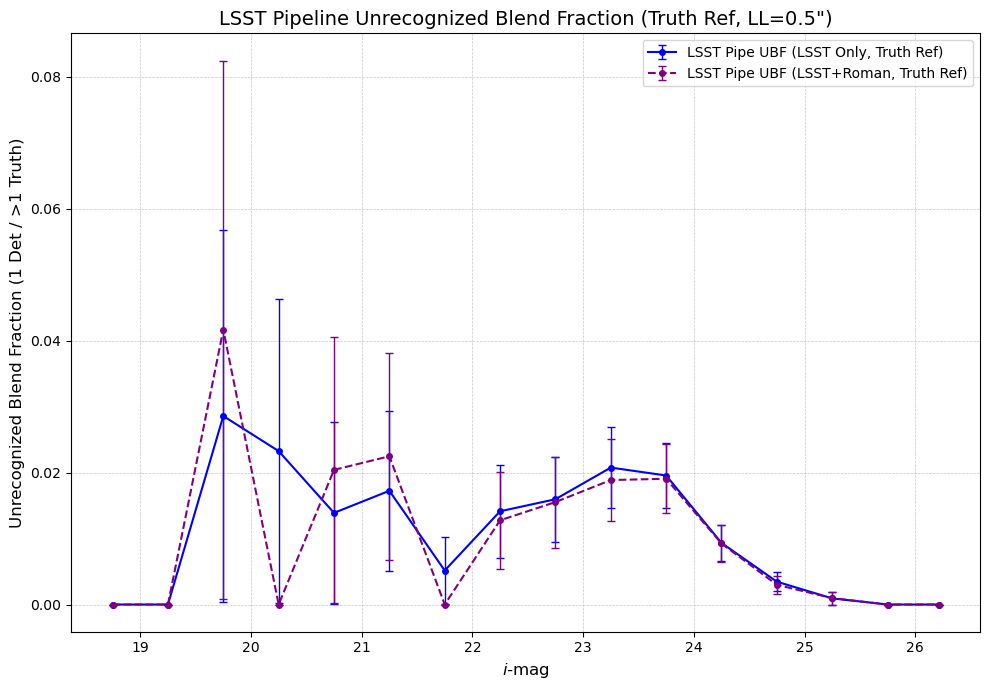

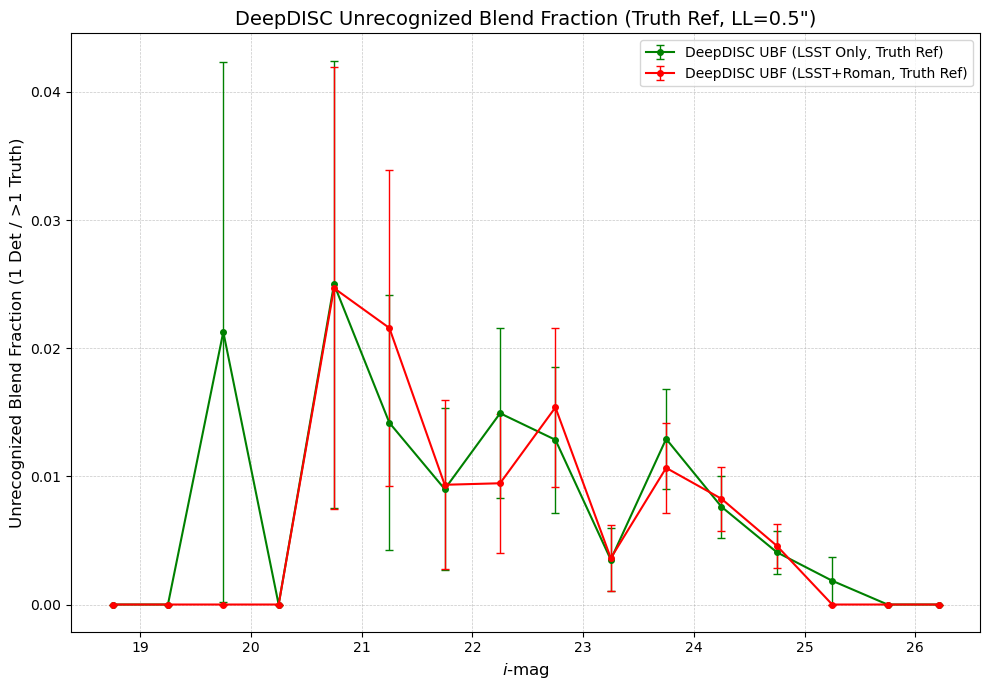

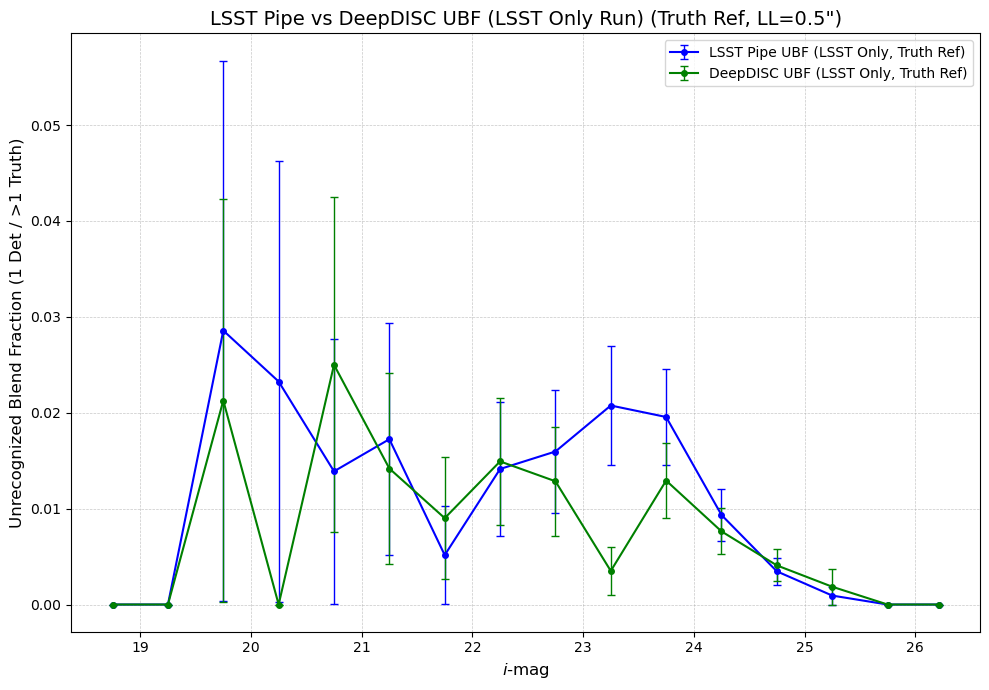

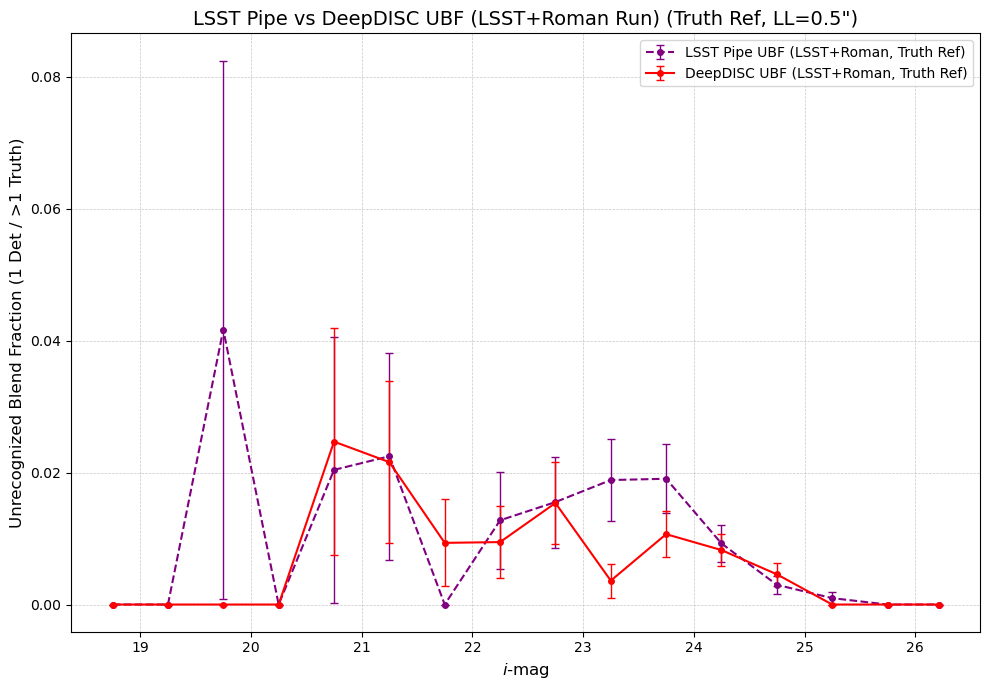

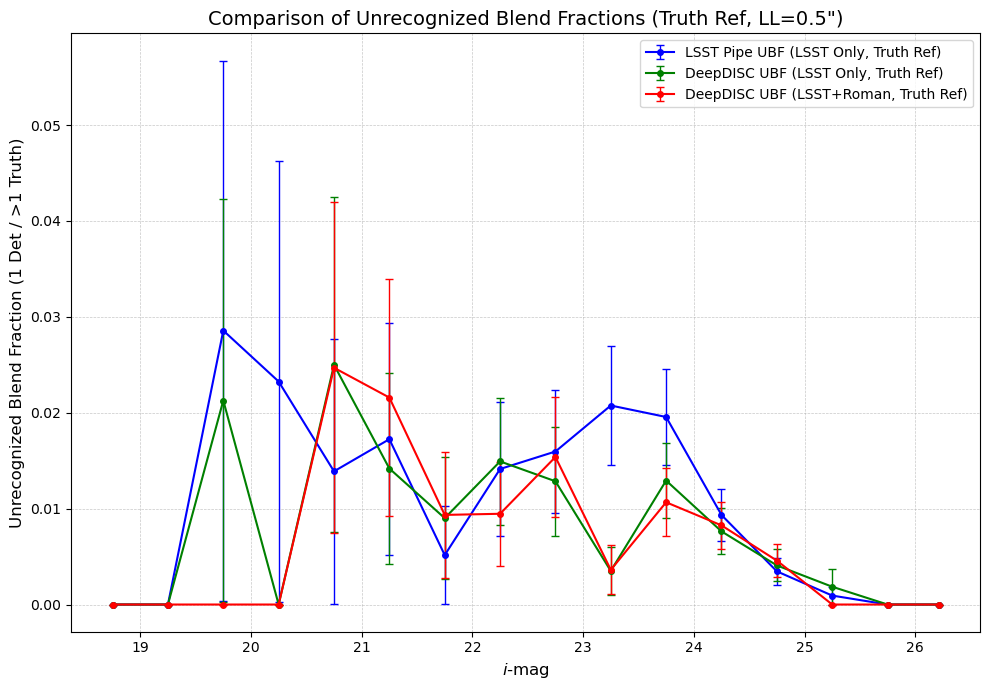


Analysis complete.


In [38]:
import FoFCatalogMatching
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
import warnings

# ==============================================================================
# Config
# ==============================================================================
MAG_COL = 'mag_i'
BASELINE_MAG_5SIGMA_10YR_I = 26.8
YEARS = 5
RUN_DIR_LSST = 'run5_sm_dlvl5'
RUN_DIR_BOTH = 'run5_ups_roman_dlvl5'
FULL_DD_PRED_JSON_LSST_FILENAME = f'./lsst_runs/{RUN_DIR_LSST}/pred_s0.3_n0.5.json'
FULL_DD_PRED_JSON_BOTH_FILENAME = f'./lsst_runs/{RUN_DIR_BOTH}/pred_s0.3_n0.5.json'

LINKING_LENGTH_ARCSEC = 0.5
SHOW_ERROR_BARS_ON_PLOTS = True

# --- Styles for Unrecognized Blend Fraction ---
UNRECOGNIZED_BLEND_PLOT_COLORS = {
    'lsst_only_lsst_vs_truth': 'blue',
    'lsst_roman_lsst_vs_truth': 'purple',
    'lsst_only_dd_vs_truth': 'green',
    'lsst_roman_dd_vs_truth': 'red',
}
UNRECOGNIZED_BLEND_PLOT_STYLES = {
    'lsst_only_lsst_vs_truth': '-',
    'lsst_roman_lsst_vs_truth': '--',
    'lsst_only_dd_vs_truth': '-', # :
    'lsst_roman_dd_vs_truth': '-', #-.
}
UNRECOGNIZED_BLEND_PLOT_LABELS = {
    'lsst_only_lsst_vs_truth': 'LSST Pipe UBF (LSST Only, Truth Ref)',
    'lsst_roman_lsst_vs_truth': 'LSST Pipe UBF (LSST+Roman, Truth Ref)',
    'lsst_only_dd_vs_truth': 'DeepDISC UBF (LSST Only, Truth Ref)',
    'lsst_roman_dd_vs_truth': 'DeepDISC UBF (LSST+Roman, Truth Ref)',
}

# Helper Functions
# same for all SNR levels
def calculate_truth_mag_limit(baseline_mag_5sigma_10yr, years):
    """
    Calculate truth catalog magnitude cut at Rubin's nominal 5sigma depth adjusted 
    for the specified number of observation years.
    
    This cut is intended to be used consistently for defining the faint 
    limit of the truth sample for analysis (e.g., completeness), 
    including FOF matching.
    
    Parameters:
    baseline_mag_5sigma_10yr (float): 10-year 5σ depth (e.g., 26.8 for i-band)
    years (float): Analysis time baseline in years
    
    Returns:
    float: Magnitude cut for truth catalog
    """
    time_factor = np.sqrt(10 / years) # represents (sqrt(N_obs_10yr) / sqrt(N_obs_years))
    # delta_mag = 2.5 * log10(SNR_ratio)
    # SNR_ratio corresponds to 1 / time_factor for reaching the *same* SNR
    m_cut = baseline_mag_5sigma_10yr - 2.5 * np.log10(time_factor)
    return m_cut

def get_catalog_subset_for_matching(catalog_df, mag_col=MAG_COL, mag_range=None):
    """
    Filters a catalog DataFrame by magnitude (optional) and selects
    columns needed for FoF input ('ra', 'dec').
    """
    if not isinstance(catalog_df, pd.DataFrame):
        raise TypeError("Input catalog must be a pandas DataFrame.")

    filtered_df = catalog_df.copy()

    if mag_range is not None:
        min_mag, max_mag = mag_range
        if mag_col not in filtered_df.columns:
             print(f"Warning: Magnitude column '{mag_col}' not found in catalog. Cannot apply magnitude filter for get_catalog_subset_for_matching.")
        else:
            filtered_df[mag_col] = pd.to_numeric(filtered_df[mag_col], errors='coerce')
            filtered_df = filtered_df.dropna(subset=[mag_col])
            filtered_df = filtered_df[(filtered_df[mag_col] >= min_mag) & (filtered_df[mag_col] < max_mag)]

    required_cols = ['ra', 'dec']
    if not all(col in filtered_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in filtered_df.columns]
        print(f"Error: Input DataFrame missing required columns for FoF: {missing}")
        return None

    subset_df = filtered_df[required_cols]
    if subset_df.empty:
        return None
    return Table.from_pandas(subset_df)


def find_matches(cat_a, cat_b, cat_a_name, cat_b_name, linking_length=1.0, max_friends=1):
    """
    Find matches between two catalogs using Friends-of-Friends algorithm.
    Requires 'ra', 'dec' columns in input tables. Returns table with
    'row_index', 'catalog_key', 'group_id'.
    """
    if not isinstance(cat_a, Table):
        if cat_a is None: return None
        raise TypeError(f"cat_a must be an astropy Table, got {type(cat_a)}")
    if not isinstance(cat_b, Table):
        if cat_b is None: return None
        raise TypeError(f"cat_b must be an astropy Table, got {type(cat_b)}")

    if len(cat_a) == 0 or len(cat_b) == 0:
        # print(f"Warning: One or both catalogs empty for FoF: {cat_a_name} (len {len(cat_a)}), {cat_b_name} (len {len(cat_b)})")
        return None

    required_cols = ['ra', 'dec']
    if not all(col in cat_a.colnames for col in required_cols):
        print(f"Error: cat_a ('{cat_a_name}') missing required columns: {required_cols}.")
        return None
    if not all(col in cat_b.colnames for col in required_cols):
        print(f"Error: cat_b ('{cat_b_name}') missing required columns: {required_cols}.")
        return None

    linking_lengths_dict = {linking_length: max_friends}
    try:
        matched_results = FoFCatalogMatching.match(
            catalog_dict={cat_a_name: cat_a, cat_b_name: cat_b},
            linking_lengths=linking_lengths_dict
        )
        if matched_results is None: return None
        if len(matched_results) == 0: return matched_results

        fof_req_cols = ['catalog_key', 'group_id', 'row_index']
        if not all(col in matched_results.colnames for col in fof_req_cols):
            print(f"Warning: FoF results for {cat_a_name} vs {cat_b_name} missing essential columns (expected {fof_req_cols}, got {matched_results.colnames}).")
            return None
        return matched_results
    except Exception as e:
        print(f"Error during FoF matching between {cat_a_name} and {cat_b_name}: {e}")
        return None


def add_magnitudes_to_fof_results(fof_results, cat_a_key, cat_b_key, cat_a_df_full, cat_b_df_full, mag_col_name):
    """
    Adds a 'mag' column to the FoF results table by looking up
    values from the original full DataFrames using 'row_index'.
    Assumes original dfs have a standard 0-based integer index
    The 'mag_col_name' refers to the column to be created in fof_results and sourced from input dfs
    """
    if fof_results is None: return None
    if len(fof_results) == 0:
        fof_results[mag_col_name] = []
        return fof_results

    # np.full creates a new arr of a specified shape and fill it with a constant value
    fof_results[mag_col_name] = np.full(len(fof_results), np.nan, dtype=float)

    for cat_key, cat_df_full in [(cat_a_key, cat_a_df_full), (cat_b_key, cat_b_df_full)]:
        if mag_col_name not in cat_df_full.columns:
            print(f"Info: Magnitude column '{mag_col_name}' not found in DataFrame for catalog '{cat_key}'. Magnitudes from this source will be NaN in FoF results.")
            continue

        mask = fof_results['catalog_key'] == cat_key
        if np.any(mask):
            indices = fof_results['row_index'][mask].astype(int)
            try:
                valid_indices_mask = (indices >= 0) & (indices < len(cat_df_full))
                valid_original_indices = indices[valid_indices_mask]

                # corresponding positions in fof_results
                fof_table_indices_for_update = np.where(mask)[0][valid_indices_mask]

                if len(valid_original_indices) < len(indices):
                    num_invalid = len(indices) - len(valid_original_indices)
                    print(f"Warning: {num_invalid} row_indices for '{cat_key}' out of bounds for its DataFrame (len={len(cat_df_full)}). These will result in NaN magnitudes.")

                if len(valid_original_indices) > 0:
                    mags_to_add = cat_df_full[mag_col_name].iloc[valid_original_indices].values
                    fof_results[mag_col_name][fof_table_indices_for_update] = mags_to_add

            except IndexError: # unnecesary bc bounds check above but just in case
                print(f"Warning: Indexing error retrieving magnitudes for '{cat_key}'. Check indices.")
            except Exception as e:
                print(f"Warning: Unexpected error retrieving magnitudes for '{cat_key}': {e}")
    return fof_results

def calculate_unrecognized_blend_fraction(results_with_mags, detection_cat_key, truth_cat_key,
                                          mag_bins, mag_col_name_in_fof=MAG_COL):
    """
    Calculates the unrecognized blend fraction per magnitude bin.
    An unrecognized blend: n_det=1 and n_truth>1 in an FoF group.
    Fraction = (Number of det objects in blended groups) / (Total number of det objects matched to truth)
    Magnitudes for binning: Uses detection_cat_key's magnitude if available in results_with_mags.
                            For DeepDISC, we don't output mags so just uses the brightest truth mag from the same FoF group
    Returns: bin_centers, fraction, errors, total_det_counts, blended_det_counts, blended_det_original_indices
    """
    num_bins = len(mag_bins) - 1
    bin_centers = (np.array(mag_bins[:-1]) + np.array(mag_bins[1:])) / 2
    blended_det_original_indices = []
    fail_return = bin_centers, np.full(num_bins, np.nan), np.full(num_bins, np.nan), \
                  np.zeros(num_bins, dtype=int), np.zeros(num_bins, dtype=int), \
                  blended_det_original_indices # empty list on failure

    if results_with_mags is None or len(results_with_mags) == 0:
        print("UBF calc: FoF results table is None or empty.")
        return fail_return

    req_cols = ['group_id', 'catalog_key', 'row_index', mag_col_name_in_fof]
    if not all(col in results_with_mags.colnames for col in req_cols):
        print(f"Error: Input table missing required columns for UBF calculation (expected {req_cols}, got {results_with_mags.colnames}).")
        return fail_return

    det_mask_fof = results_with_mags['catalog_key'] == detection_cat_key
    truth_mask_fof = results_with_mags['catalog_key'] == truth_cat_key

    if not np.any(det_mask_fof) or not np.any(truth_mask_fof):
        print(f"UBF calc: One or both catalogs ('{detection_cat_key}', '{truth_cat_key}') not found in FoF results.")
        return fail_return

    group_ids_fof = results_with_mags['group_id']
    unique_group_ids, group_inverse = np.unique(group_ids_fof, return_inverse=True)
    n_unique_groups = len(unique_group_ids)

    n_det_per_group = np.bincount(group_inverse[det_mask_fof], minlength=n_unique_groups)
    n_truth_per_group = np.bincount(group_inverse[truth_mask_fof], minlength=n_unique_groups)

    # --- Unrecognized Blend Groups (n_det=1, n_truth>1) ---
    blended_group_indices_map = np.where((n_det_per_group == 1) & (n_truth_per_group > 1))[0]
    blended_group_id_values = unique_group_ids[blended_group_indices_map]

    all_matched_det_mags_for_binning = []
    blended_det_mags_for_binning = []

    det_indices_in_fof_table = np.where(det_mask_fof)[0]
    num_det_missing_mag_and_truth_fallback = 0

    for det_fof_idx in det_indices_in_fof_table:
        current_group_id = group_ids_fof[det_fof_idx]
        unique_group_idx_map_location = np.where(unique_group_ids == current_group_id)[0]
        if len(unique_group_idx_map_location) == 0: 
            continue
        group_has_truth = n_truth_per_group[unique_group_idx_map_location[0]] > 0
        
        if not group_has_truth:
            continue

        mag_for_binning = results_with_mags[mag_col_name_in_fof][det_fof_idx]

        if np.isnan(mag_for_binning):
            truth_mags_in_group = results_with_mags[mag_col_name_in_fof][
                (group_ids_fof == current_group_id) & truth_mask_fof & (~np.isnan(results_with_mags[mag_col_name_in_fof]))
            ]
            if len(truth_mags_in_group) > 0:
                mag_for_binning = np.nanmin(truth_mags_in_group)
            else:
                num_det_missing_mag_and_truth_fallback +=1
        
        all_matched_det_mags_for_binning.append(mag_for_binning)

        if current_group_id in blended_group_id_values:
            blended_det_mags_for_binning.append(mag_for_binning)
            # original row index
            original_row_idx = results_with_mags['row_index'][det_fof_idx]
            blended_det_original_indices.append(original_row_idx) 
            
    if num_det_missing_mag_and_truth_fallback > 0:
        print(f"Info for {detection_cat_key} vs {truth_cat_key}: {num_det_missing_mag_and_truth_fallback} detection objects had NaN magnitude and no truth magnitude fallback in their group.")

    all_matched_det_mags_for_binning_np = np.array(all_matched_det_mags_for_binning)
    blended_det_mags_for_binning_np = np.array(blended_det_mags_for_binning)

    blended_det_counts_per_bin, _ = np.histogram(blended_det_mags_for_binning_np[~np.isnan(blended_det_mags_for_binning_np)], bins=mag_bins)
    total_det_counts_per_bin, _ = np.histogram(all_matched_det_mags_for_binning_np[~np.isnan(all_matched_det_mags_for_binning_np)], bins=mag_bins)
    
    # just initialize these arrs with same shape
    ub_fraction = np.full(num_bins, np.nan) 
    errors = np.full(num_bins, np.nan)
    
    valid_mask = total_det_counts_per_bin > 0
    ub_fraction[valid_mask] = blended_det_counts_per_bin[valid_mask] / total_det_counts_per_bin[valid_mask]
    
    calc_error_mask = valid_mask & (ub_fraction >= 0) & (ub_fraction <= 1)
    if np.any(calc_error_mask):
        p_safe = ub_fraction[calc_error_mask]
        n_safe = total_det_counts_per_bin[calc_error_mask]
        actual_n_for_error = n_safe[n_safe > 0]
        actual_p_for_error = p_safe[n_safe > 0]

        if len(actual_n_for_error) > 0:
            errors_subset = np.sqrt(actual_p_for_error * (1 - actual_p_for_error) / actual_n_for_error)
            original_indices_calc_error_mask = np.where(calc_error_mask)[0]
            final_indices_for_errors = original_indices_calc_error_mask[n_safe > 0]
            
            if len(errors_subset) == len(final_indices_for_errors):
                 errors[final_indices_for_errors] = errors_subset
            else:
                 print(f"Warning: Mismatch assigning errors back in UBF calculation for {detection_cat_key} vs {truth_cat_key}.")

    return bin_centers, ub_fraction, errors, total_det_counts_per_bin.astype(int), blended_det_counts_per_bin.astype(int), blended_det_original_indices

def plot_comparison_fractions(plot_data_list, title, xlabel=r'$i$-mag', ylabel='Fraction', show_error_bars=SHOW_ERROR_BARS_ON_PLOTS):
    """
    Plots multiple fraction curves on the same axes
    Can optionally hide error bars
    """
    plt.figure(figsize=(10, 7))

    if not plot_data_list:
        print(f"Warning: No data provided to plot_comparison_fractions for '{title}'.")
        plt.title(f"{title}\n(No Data)")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True, alpha=0.3)
        plt.ylim(bottom=-0.05, top=1.05)
        return

    all_labels = []
    for data in plot_data_list:
        required_keys = ['bin_centers', 'fractions', 'errors', 'label', 'color', 'style']
        if not all(key in data for key in required_keys) or data['bin_centers'] is None:
            print(f"Warning: Skipping data entry due to missing keys or None data for plot '{title}'. Entry: {data.get('label', 'Unknown')}")
            continue

        valid_mask = ~np.isnan(data['fractions'])
        if show_error_bars:
            valid_mask = valid_mask & ~np.isnan(data['errors'])

        label = data['label']
        all_labels.append(label)

        y_err_values = data['errors'][valid_mask] if show_error_bars else None

        if np.any(valid_mask):
            plt.errorbar(data['bin_centers'][valid_mask],
                         data['fractions'][valid_mask],
                         yerr=y_err_values,
                         label=label,
                         color=data['color'],
                         linestyle=data['style'],
                         fmt='o', markersize=4, capsize=3 if show_error_bars else 0,
                         elinewidth=1 if show_error_bars else None,
                         markeredgewidth=1)
        else:
            plt.plot([], [], label=label, color=data['color'], linestyle=data['style'])
            print(f"Info: No valid data points to plot for '{label}' in '{title}'. It will appear in legend only.")

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, wrap=True)
    if all_labels:
        plt.legend(fontsize=10, loc='best')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()


# ==============================================================================
# Main
# ==============================================================================

print("Starting analysis...")
truth_mag_limit = calculate_truth_mag_limit(BASELINE_MAG_5SIGMA_10YR_I, YEARS)
print(f"Overall Truth Catalog Cut Used: {MAG_COL} < {truth_mag_limit:.2f}")

if truth_mag_limit <= 15.5:
    print("Error: truth_mag_limit is too low to form bins starting at 15.5. Exiting.")
    exit()

# magn bin edges for plotting
bin_edges = np.arange(18.5, truth_mag_limit, 0.5)
if len(bin_edges) == 0:
    bin_edges_array = np.array([18.5, truth_mag_limit])
elif not np.isclose(bin_edges[-1], truth_mag_limit) and bin_edges[-1] < truth_mag_limit:
    bin_edges_array = np.append(bin_edges, truth_mag_limit)
elif not np.isclose(bin_edges[-1], truth_mag_limit) and bin_edges[-1] > truth_mag_limit: # arange might overshoot slightly if truth_mag_limit is just above a step
    bin_edges_array = bin_edges[bin_edges < truth_mag_limit]
    bin_edges_array = np.append(bin_edges_array, truth_mag_limit)
else: # last ele of arange is alr truth_mag_limit (or close enough)
    bin_edges_array = bin_edges

bin_edges_array = np.unique(bin_edges_array)
print(f"Using Mag Bin Edges for plotting: {bin_edges_array}")

if len(bin_edges_array) < 2:
    print("Error: Not enough distinct bin edges to form at least one bin. Exiting.")
    exit()
num_bins = len(bin_edges_array) - 1


print("\nLoading data...")
try:
    lsst_test_det_df_lsst = pd.read_json(f'./lsst_runs/{RUN_DIR_LSST}/test_lsst_det_fof_info.json').reset_index(drop=True)
#     dd_test_det_df_lsst = pd.read_json(f'./lsst_runs/{RUN_DIR_LSST}/pred_s0.3_n0.5_radec.json').reset_index(drop=True)
    dd_test_det_df_lsst = pd.read_json(FULL_DD_PRED_JSON_LSST_FILENAME).reset_index(drop=True)

    truth_df_lsst = pd.read_json(f'./lsst_runs/{RUN_DIR_LSST}/test_truth11_cat.json').reset_index(drop=True)

    lsst_test_det_df_both = pd.read_json(f'./lsst_runs/{RUN_DIR_BOTH}/test_lsst_det_fof_info.json').reset_index(drop=True)
#     dd_test_det_df_both = pd.read_json(f'./lsst_runs/{RUN_DIR_BOTH}/pred_s0.3_n0.5_radec.json').reset_index(drop=True)
    dd_test_det_df_both = pd.read_json(FULL_DD_PRED_JSON_BOTH_FILENAME).reset_index(drop=True)

    truth_df_both = pd.read_json(f'./lsst_runs/{RUN_DIR_BOTH}/test_truth11_cat.json').reset_index(drop=True)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"\nError loading data file: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit()

unrecognized_blend_results = {
    'lsst_only_lsst_vs_truth': {'total_counts': np.zeros(num_bins, dtype=int), 'blended_counts': np.zeros(num_bins, dtype=int)},
    'lsst_roman_lsst_vs_truth': {'total_counts': np.zeros(num_bins, dtype=int), 'blended_counts': np.zeros(num_bins, dtype=int)},
    'lsst_only_dd_vs_truth': {'total_counts': np.zeros(num_bins, dtype=int), 'blended_counts': np.zeros(num_bins, dtype=int)},
    'lsst_roman_dd_vs_truth': {'total_counts': np.zeros(num_bins, dtype=int), 'blended_counts': np.zeros(num_bins, dtype=int)},
}

print(f"\n--- Running Matching (LL={LINKING_LENGTH_ARCSEC}\") and Calculating Unrecognized Blend Fractions ---")
truth_key = 'truth'
lsst_det_key = 'lsst_det'
dd_det_key = 'dd_det'

# --- LSST Only Run ---
print("\nProcessing LSST Only Run...")
truth_table_lsst = get_catalog_subset_for_matching(truth_df_lsst) # no mag cut, full catalog for matching
lsst_det_table_lsst = get_catalog_subset_for_matching(lsst_test_det_df_lsst)
dd_det_table_lsst = get_catalog_subset_for_matching(dd_test_det_df_lsst)

# Match Truth vs LSST Pipeline (LSST Only)
print("Matching Truth vs LSST Pipeline (LSST Only)...")
fof_res_raw_tvl_lsst = find_matches(truth_table_lsst, lsst_det_table_lsst, truth_key, lsst_det_key, LINKING_LENGTH_ARCSEC)
fof_res_tvl_lsst = add_magnitudes_to_fof_results(fof_res_raw_tvl_lsst, truth_key, lsst_det_key, truth_df_lsst, lsst_test_det_df_lsst, MAG_COL)

print("Calculating LSST Pipeline Unrecognized Blend Fraction (LSST Only)...")

if fof_res_tvl_lsst is not None:
    centers, frac, err, total, blended, blended_indices = calculate_unrecognized_blend_fraction(fof_res_tvl_lsst, lsst_det_key, truth_key, bin_edges_array, MAG_COL)
    unrecognized_blend_results['lsst_only_lsst_vs_truth'].update({
        'bin_centers': centers, 'fractions': frac, 'errors': err, 
        'total_counts': total, 'blended_counts': blended,
        'blended_det_original_indices': blended_indices
    })
else:
    print(f"Skipping UBF for LSST Pipe (LSST Only): FoF matching failed or returned empty.")
    unrecognized_blend_results['lsst_only_lsst_vs_truth']['blended_det_original_indices'] = []
    
# Match Truth vs DeepDISC (LSST Only)
print("Matching Truth vs DeepDISC (LSST Only)...")
fof_res_raw_tvd_lsst = find_matches(truth_table_lsst, dd_det_table_lsst, truth_key, dd_det_key, LINKING_LENGTH_ARCSEC)
fof_res_tvd_lsst = add_magnitudes_to_fof_results(fof_res_raw_tvd_lsst, truth_key, dd_det_key, truth_df_lsst, dd_test_det_df_lsst, MAG_COL)

print("Calculating DeepDISC Unrecognized Blend Fraction (LSST Only)...")

if fof_res_tvd_lsst is not None:
    centers, frac, err, total, blended, blended_indices = calculate_unrecognized_blend_fraction(fof_res_tvd_lsst, dd_det_key, truth_key, bin_edges_array, MAG_COL)
    unrecognized_blend_results['lsst_only_dd_vs_truth'].update({
        'bin_centers': centers, 'fractions': frac, 'errors': err, 
        'total_counts': total, 'blended_counts': blended,
        'blended_det_original_indices': blended_indices
    })
else:
    print(f"Skipping UBF for DeepDISC (LSST Only): FoF matching failed or returned empty.")
    unrecognized_blend_results['lsst_only_dd_vs_truth']['blended_det_original_indices'] = []
    
# --- LSST + Roman Run ---
print("\nProcessing LSST + Roman Run...")
truth_table_both = get_catalog_subset_for_matching(truth_df_both)
lsst_det_table_both = get_catalog_subset_for_matching(lsst_test_det_df_both)
dd_det_table_both = get_catalog_subset_for_matching(dd_test_det_df_both)

# Match Truth vs LSST Pipeline (LSST+Roman)
print("Matching Truth vs LSST Pipeline (LSST+Roman)...")
fof_res_raw_tvl_both = find_matches(truth_table_both, lsst_det_table_both, truth_key, lsst_det_key, LINKING_LENGTH_ARCSEC)
fof_res_tvl_both = add_magnitudes_to_fof_results(fof_res_raw_tvl_both, truth_key, lsst_det_key, truth_df_both, lsst_test_det_df_both, MAG_COL)

print("Calculating LSST Pipeline Unrecognized Blend Fraction (LSST+Roman)...")
    
if fof_res_tvl_both is not None:
    centers, frac, err, total, blended, blended_indices = calculate_unrecognized_blend_fraction(fof_res_tvl_both, lsst_det_key, truth_key, bin_edges_array, MAG_COL)
    unrecognized_blend_results['lsst_roman_lsst_vs_truth'].update({
        'bin_centers': centers, 'fractions': frac, 'errors': err, 
        'total_counts': total, 'blended_counts': blended,
        'blended_det_original_indices': blended_indices # <<< Store the indices >>>
    })
else:
    print(f"Skipping UBF for LSST Pipe (LSST+Roman): FoF matching failed or returned empty.")
    unrecognized_blend_results['lsst_roman_lsst_vs_truth']['blended_det_original_indices'] = []

# Match Truth vs DeepDISC (LSST+Roman)
print("Matching Truth vs DeepDISC (LSST+Roman)...")
fof_res_raw_tvd_both = find_matches(truth_table_both, dd_det_table_both, truth_key, dd_det_key, LINKING_LENGTH_ARCSEC)
fof_res_tvd_both = add_magnitudes_to_fof_results(fof_res_raw_tvd_both, truth_key, dd_det_key, truth_df_both, dd_test_det_df_both, MAG_COL)

print("Calculating DeepDISC Unrecognized Blend Fraction (LSST+Roman)...")

if fof_res_tvd_both is not None:
    centers, frac, err, total, blended, blended_indices = calculate_unrecognized_blend_fraction(fof_res_tvd_both, dd_det_key, truth_key, bin_edges_array, MAG_COL)
    unrecognized_blend_results['lsst_roman_dd_vs_truth'].update({
        'bin_centers': centers, 'fractions': frac, 'errors': err, 
        'total_counts': total, 'blended_counts': blended,
        'blended_det_original_indices': blended_indices
    })
else:
    print(f"Skipping UBF for DeepDISC (LSST+Roman): FoF matching failed or returned empty.")
    unrecognized_blend_results['lsst_roman_dd_vs_truth']['blended_det_original_indices'] = []   

# --- Overall Fractions ---
print("\n--- Overall Unrecognized Blend Fractions (Detection Cat Ref vs. Truth) ---")
for key, data in unrecognized_blend_results.items():
    label = UNRECOGNIZED_BLEND_PLOT_LABELS.get(key, key)
    if 'blended_counts' in data and 'total_counts' in data and \
       data['blended_counts'] is not None and data['total_counts'] is not None:
        
        total_blended_det_objects = np.nansum(data['blended_counts'])
        total_det_objects_matched_to_truth = np.nansum(data['total_counts']) # denom from UBF func

        if total_det_objects_matched_to_truth > 0:
            overall_fraction = total_blended_det_objects / total_det_objects_matched_to_truth
            p_overall, n_overall = overall_fraction, total_det_objects_matched_to_truth
            overall_error = np.sqrt(p_overall * (1 - p_overall) / n_overall) if (n_overall > 0 and p_overall >= 0 and p_overall <= 1) else np.nan
            print(f"{label}: {overall_fraction:.4f} +/- {overall_error:.4f} "
                  f"(N_blended_det_obj={int(total_blended_det_objects)}, "
                  f"N_total_det_obj_matched_to_truth={int(total_det_objects_matched_to_truth)})")
        else:
            print(f"{label}: No detection objects matched to truth for overall UBF calculation (N_total_det_obj_matched_to_truth=0).")
    else:
        print(f"{label}: Data not available for overall UBF calculation (counts missing or None).")


# --- preo data for plotting ---
def prepare_plot_data_generic(keys_to_plot, results_dict, labels_dict, colors_dict, styles_dict):
    plot_data = []
    for key in keys_to_plot:
        if key in results_dict and 'bin_centers' in results_dict[key] and results_dict[key]['bin_centers'] is not None: # Check for None bin_centers
            plot_data.append({
                'bin_centers': results_dict[key]['bin_centers'],
                'fractions': results_dict[key]['fractions'],
                'errors': results_dict[key]['errors'],
                'label': labels_dict.get(key, key),
                'color': colors_dict.get(key, key),
                'style': styles_dict.get(key, key)
            })
        else:
            data_label = labels_dict.get(key,key) if labels_dict else key
            print(f"Info: Data for '{data_label}' not available or incomplete for plotting (key: {key}).")
    return plot_data

# --- Comparison Plots ---
print("\n--- Generating Unrecognized Blend Fraction Comparison Plots ---")
plot_title_suffix_base = f'(Truth Ref, LL={LINKING_LENGTH_ARCSEC}")'
ubf_ylabel = 'Unrecognized Blend Fraction (1 Det / >1 Truth)'

# LSST Pipeline UBF (LSST Only vs LSST+Roman)
keys_p1 = ['lsst_only_lsst_vs_truth', 'lsst_roman_lsst_vs_truth']
plot_data1 = prepare_plot_data_generic(keys_p1, unrecognized_blend_results, UNRECOGNIZED_BLEND_PLOT_LABELS, UNRECOGNIZED_BLEND_PLOT_COLORS, UNRECOGNIZED_BLEND_PLOT_STYLES)
if plot_data1:
    plot_comparison_fractions(plot_data1,
                                   title=f'LSST Pipeline Unrecognized Blend Fraction {plot_title_suffix_base}',
                                   ylabel=ubf_ylabel)
    plt.show()
else:
    print("No data for Plot 1: LSST Pipeline UBF Comparison.")

# DeepDISC UBF (LSST Only vs LSST+Roman)
keys_p2 = ['lsst_only_dd_vs_truth', 'lsst_roman_dd_vs_truth']
plot_data2 = prepare_plot_data_generic(keys_p2, unrecognized_blend_results, UNRECOGNIZED_BLEND_PLOT_LABELS, UNRECOGNIZED_BLEND_PLOT_COLORS, UNRECOGNIZED_BLEND_PLOT_STYLES)
if plot_data2:
    plot_comparison_fractions(plot_data2,
                                   title=f'DeepDISC Unrecognized Blend Fraction {plot_title_suffix_base}',
                                   ylabel=ubf_ylabel)
    plt.show()
else:
    print("No data for Plot 2: DeepDISC UBF Comparison.")

# LSST Pipe vs DeepDISC UBF (LSST Only Run)
keys_p3 = ['lsst_only_lsst_vs_truth', 'lsst_only_dd_vs_truth']
plot_data3 = prepare_plot_data_generic(keys_p3, unrecognized_blend_results, UNRECOGNIZED_BLEND_PLOT_LABELS, UNRECOGNIZED_BLEND_PLOT_COLORS, UNRECOGNIZED_BLEND_PLOT_STYLES)
if plot_data3:
    plot_comparison_fractions(plot_data3,
                                   title=f'LSST Pipe vs DeepDISC UBF (LSST Only Run) {plot_title_suffix_base}',
                                   ylabel=ubf_ylabel)
    plt.show()
else:
    print("No data for Plot 3: LSST Pipe vs DeepDISC UBF (LSST Only).")

# LSST Pipe vs DeepDISC UBF (LSST+Roman Run)
keys_p4 = ['lsst_roman_lsst_vs_truth', 'lsst_roman_dd_vs_truth']
plot_data4 = prepare_plot_data_generic(keys_p4, unrecognized_blend_results, UNRECOGNIZED_BLEND_PLOT_LABELS, UNRECOGNIZED_BLEND_PLOT_COLORS, UNRECOGNIZED_BLEND_PLOT_STYLES)
if plot_data4:
    plot_comparison_fractions(plot_data4,
                                   title=f'LSST Pipe vs DeepDISC UBF (LSST+Roman Run) {plot_title_suffix_base}',
                                   ylabel=ubf_ylabel)
    plt.show()
else:
    print("No data for Plot 4: LSST Pipe vs DeepDISC UBF (LSST+Roman).")

# Overall Comparison (LSST Pipe LSSTOnly, DD LSSTOnly, DD LSST+Roman)
keys_p5 = ['lsst_only_lsst_vs_truth', 'lsst_only_dd_vs_truth', 'lsst_roman_dd_vs_truth']
plot_data5 = prepare_plot_data_generic(keys_p5, unrecognized_blend_results, UNRECOGNIZED_BLEND_PLOT_LABELS, UNRECOGNIZED_BLEND_PLOT_COLORS, UNRECOGNIZED_BLEND_PLOT_STYLES)
if plot_data5:
    plot_comparison_fractions(plot_data5,
                                   title=f'Comparison of Unrecognized Blend Fractions {plot_title_suffix_base}',
                                   ylabel=ubf_ylabel)
    plt.show()
else:
    print("No data for Plot 5: Overall UBF Comparison.")